In [1]:
# Copyright 2020 Bimghi Choi. All Rights Reserved.
# 예측 + 투자전략 시스템

# _*_ coding: utf-8 _*_

from tensorflow import keras
import tensorflow as tf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import os
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
#os.environ["CUDA_VISIBLE_DEVICES"]='0, 1'

In [2]:
import util
import preprocess as prepro
import models
import learn
from learn import GenerateResult
import math
import datetime

In [3]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

In [4]:
#tf.keras.backend.set_floatx('float64')

In [5]:
import gc
gc.collect()

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # 텐서플로가 첫 번째 GPU에 1GB 메모리만 할당하도록 제한
  try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')    
#    tf.config.experimental.set_visible_devices(gpus[1], 'GPU')    
    #tf.config.experimental.set_virtual_device_configuration(
    #    gpus[1],
    #    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])
  except RuntimeError as e:
    # 프로그램 시작시에 가장 장치가 설정되어야만 합니다
    print(e)

60

In [6]:
file_name = '~/Data/kospi200f_price_only_0515.csv'
item_name = 'kospi200f_loss_cut'
train_start = '2000-01-31'
train_end = '2019-01-02'
test_start = '2019-01-02'
test_end = '2020-05-15'

remove_columns = ['date', '종가']
target_column = '종가'
input_columns = []
target_type = 'rate'

model_name = 'loss_cut'
channel = False

trans_day = 1

target_alpha = 100
future_day = 1
train_end_back = -1
n_timestep = 120
time_interval = 1
input_size = 37
n_unit = 200
batch_size = 10
learning_rate = 0.0005
epochs = 2000

alpha = 0.5

comment = "모델1은 지수예측 모델2는 최적의 손절값 예측"

checkpoint_path = model_name + "/pred"+str(future_day)+"_trans"+str(trans_day)+".ckpt"

In [7]:
dataframe = util.read_datafile(file_name)
df = dataframe.copy()
#df = prepro.target_conversion(df, target_column, future_day, type=target_type)
for i in range(len(df[target_column]) -future_day):
    df.loc[i, target_column] = ((df.loc[i + future_day, target_column] - df.loc[i, target_column]) 
                                / df.loc[i, target_column]) * target_alpha 
    df.loc[i, '시가'] = df.loc[i + 1, '시가']
    df.loc[i, '고가'] = max(df.loc[i + 1:i + future_day, '고가'])
    df.loc[i, '저가'] = min(df.loc[i + 1:i + future_day, '저가'])
    

In [8]:
df.head(20)

date  시가지수(포인트)  고가지수(포인트)  저가지수(포인트)  종가지수(포인트)    수익률(%)  \
0   2000-01-31  -0.218225  -0.493106  -0.400439  -0.223565  0.212872   
1   2000-02-01  -0.213200  -0.230417  -0.373954  -0.595373 -0.407635   
2   2000-02-02  -0.208520  -0.448886  -0.367787  -0.200398  0.696677   
3   2000-02-03  -0.204125  -0.216603  -0.062403  -0.021445  0.366314   
4   2000-02-07  -0.200000   0.378008   0.426748   0.592789  0.949260   
5   2000-02-08  -0.196110   0.353748   0.677387   0.254527 -0.366454   
6   2000-02-09  -0.192447   0.306497   0.819824   0.658684  0.641075   
7   2000-02-10   0.330923   0.617187   0.552762   0.366383 -0.311193   
8   2000-02-11   0.977388   0.576306   0.048738  -0.013448 -0.428351   
9   2000-02-14  -0.649462  -0.806483  -0.954529  -1.222378 -1.533955   
10  2000-02-15  -1.074607  -1.359121  -1.825901  -1.959771 -1.104848   
11  2000-02-16  -1.939741  -2.072462  -2.426875  -1.820694  0.171634   
12  2000-02-17  -2.062374  -1.576333  -1.627765  -1.281362  0.934836   
13  2000-02-18  -1.203728  -1.119424  -1.312861  -1.662198 -0.622664   
14  2000-02-21  -2.011534  -2.360013  -2.117703  -2.493118 -1.243495   
15  2000-02-22  -2.301061  -2.151107  -2.119718  -2.142064  0.422501   
16  2000-02-23  -1.670887  -1.656883  -1.569320  -1.267786  1.605126   
17  2000-02-24  -1.366238  -1.422324  -1.358331  -1.490032 -0.528189   
18  2000-02-25  -1.680249  -1.665735  -1.510077  -1.461250  0.033092   
19  2000-02-28  -1.697353  -2.045428  -2.011407  -2.307633 -1.966604   

    수익률 (1주)(%)  수익률 (1개월)(%)  수익률 (3개월)(%)  수익률 (6개월)(%)  ...  \
0      1.352924     -0.851790     -0.382658     -0.162615  ...   
1      1.808646     -1.074203     -1.707405     -0.490731  ...   
2      2.107257     -0.769928     -1.558400      0.074389  ...   
3      1.488978     -0.625155     -1.268930     -0.079967  ...   
4      1.101574      1.281908     -1.288431      1.273730  ...   
5      1.138729      0.998930     -1.329397      0.942469  ...   
6      1.076862      1.233568     -1.637689      0.994675  ...   
7      0.651653      0.275024     -1.607973      0.269679  ...   
8      0.326747      0.131530     -1.828185      0.546650  ...   
9     -1.217328     -0.075927     -2.486079      0.140712  ...   
10    -1.601324     -0.717085     -2.587555     -0.669097  ...   
11    -1.786449     -0.703717     -2.563710     -0.401469  ...   
12    -1.133411     -0.976304     -1.810490      1.006196  ...   
13    -1.227625     -1.271035     -1.891012      0.605513  ...   
14    -1.039810     -0.905187     -2.286667     -0.665131  ...   
15    -0.214320     -0.740215     -1.957417     -0.444290  ...   
16     0.506204      0.050075     -1.494619     -0.699133  ...   
17    -0.294080     -0.319013     -1.472892     -1.661528  ...   
18     0.075897      0.493437     -1.430882     -2.424417  ...   
19    -0.289909     -1.729787     -1.563181     -3.097790  ...   

    거래대금 (52주 평균)(원)  외국인보유비중(%)  외국인시가총액(백만원)  시가총액 (52주 최저,보통)(백만원)  \
0           1.964201    0.440876      0.231939               0.000000   
1           1.999278    0.003465     -0.604454               0.000000   
2           2.033876   -0.306553     -0.279508               0.000000   
3           2.080728   -0.503997     -0.165628               0.000000   
4           2.300807   -0.886682      0.370201               0.000000   
5           2.205608   -0.301912      0.321561               0.000000   
6           2.162699    0.201239      1.214352               0.000000   
7           2.148073    0.595062      1.058559               0.000000   
8           2.140751    0.782832      0.670346               0.000000   
9           2.068529    0.655770     -1.072468               0.000000   
10          1.871704    0.323943     -2.264750               0.000000   
11          1.710663   -0.129153     -2.255663               0.000000   
12          1.586397    0.212513     -1.382554               0.000000   
13          1.662356    0.717799     -1.643104               0.000000   
14          1.6

In [9]:
import pandas_profiling
column_list = df.columns
idx = np.random.choice(len(column_list))
data = df.loc[:, [column_list[38], column_list[idx]]]
data = data[:-future_day]
pr = data.profile_report()
pr

In [10]:
def make_remaining_days(n_batches, n_steps):
    remaining_days = []
    for i in range(n_batches):
        temp = []    
        for j in range(n_steps):
            temp.append((n_batches - i) / n_batches)
        remaining_days.append(np.array(temp))
    return np.array(remaining_days)

In [11]:
@tf.function
def loss_fn_model1(train_y, preds):
    
    #preds = tf.cast(preds, dtype=tf.float64)
    #train_y = tf.cast(train_y, dtype=tf.float64)
    rates = train_y / 100
    updown = tf.math.sign(train_y)
    profits = 1 + rates*tf.math.sign(preds)
    
    loss1 = keras.losses.MSE(preds, train_y)
    
    batches = tf.shape(train_y)[0]

    return_plus = 0.000000000
    return_minus = 0.000000000
    for i in range(batches):
        if profits[i, -1, 0] - 1 > 0.0: return_plus += profits[i, -1, 0]-1      
        else: return_minus += 1-profits[i, -1, 0]    

    loss2 = (return_plus - return_minus)/tf.cast(batches, dtype=tf.float32)
    
    return loss1 - loss2


In [12]:
#@tf.function
def loss_fn_model2(m1, m2, train_x, train_y):
    
    train_y_target = np.expand_dims(train_y[:, :, 3], axis=2)
    
    rates = train_y_target / 100
    updown = tf.math.sign(train_y_target)
    preds = tf.cast(tf.math.sign(m1(train_x)), dtype=tf.float64)
    profits = tf.cast(1 + tf.convert_to_tensor(rates, dtype=tf.float64)*preds, dtype=tf.float64)
    
    batches = tf.cast(train_y.shape[0], dtype=tf.int32)
    steps = train_y.shape[1]     

    train_x_m2 = tf.concat([train_x, preds], 2)
    loss_cuts = tf.reshape(m2(train_x_m2)[:, -1, 0]*20, [-1])
    
    # 시가, 고가, 저가
    train_open_high_low = train_y[:, -1, :3].reshape((batches, 3))
    
    m2_targets = []
    for i in range(batches):
        if preds[i, -1, 0] > 0:
            if rates[i, -1, 0] > 0:
                m2_targets.append(train_open_high_low[i, 0] - train_open_high_low[i, 2])# 상승 예측시 저가가 손절값 이상 내려갈 때, 시가 - 저가
            else: m2_targets.append(abs(train_open_high_low[i, 0]*train_y_target[i, -1, 0]/100)*0.7) # 손실의 0.7을 손절값으로
        else:
            if rates[i, -1, 0] < 0:
                m2_targets.append(train_open_high_low[i, 1] - train_open_high_low[i, 0])# 하락 예측시 고가가 손절값 이상 올라갈 때, 고가 - 시가
            else: m2_targets.append(abs(train_open_high_low[i, 0]*train_y_target[i, -1, 0]/100)*0.7) # 손실의 0.7을 손절값으로
  
    return keras.losses.MSE(m2_targets, loss_cuts)


In [13]:
#@tf.function
def gradient1(model1, input_data, output_data):
    with tf.GradientTape() as tape:
        loss = loss_fn_model1(model1, input_data, output_data)
    return tape.gradient(loss, model1.trainable_variables)
#@tf.function
def gradient2(model1, model2, input_data, output_data):
    with tf.device('/CPU:0'):
        with tf.GradientTape() as tape:
            loss = loss_fn_model2(model1, model2, input_data, output_data)
        return tape.gradient(loss, model2.trainable_variables)

In [14]:

#strategy = tf.distribute.MirroredStrategy()
#with strategy.scope():
"""
model1 = tf.keras.Sequential([
    tf.keras.Input(shape=(n_timestep, input_size)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])
model1.summary()
model2 = tf.keras.Sequential([
    tf.keras.Input(shape=(n_timestep, input_size+1)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='tanh')
])
model2.summary()
"""
model1 = models.LSTM(n_timestep,input_size,n_unit,regularizers_alpha=0.01,drop_rate=0.5)
model2 = models.LSTM_sigm(n_timestep,input_size+1,n_unit,regularizers_alpha=0.01,drop_rate=0.5)

    #cp_callback = tf.keras.callbacks.ModelCheckpoint(
    #    checkpoint_path, verbose=1, save_weights_only=True,
        # 다섯 번째 에포크마다 가중치를 저장합니다
    #    save_freq=5)

model1.compile(optimizer='adam',
              loss=loss_fn_model1)
                  #callbacks=[cp-callback]
              #metrics=['accuracy'])
model1.save_weights(checkpoint_path)            

#    model2 = models.LSTM(n_timestep,input_size,n_unit,regularizers_alpha=0.01,drop_rate=0.5)
#    model2.compile(optimizer='adam',
#                  loss='mse')
                  #callbacks=[cp-callback]
              #metrics=['accuracy'])            

#modle_name = model_name + "tanh"            
#model2.save_weights("modle2_"+ checkpoint_path)

Train on 4551 samples, validate on 1 samples
Epoch 1/10
4551/4551 [==============================] - 17s 4ms/sample - loss: 9.1318 - val_loss: 2.0093
Epoch 2/10
4551/4551 [==============================] - 9s 2ms/sample - loss: 1.3134 - val_loss: 0.8898
Epoch 3/10
4551/4551 [==============================] - 9s 2ms/sample - loss: 0.6479 - val_loss: 0.4897
Epoch 4/10
4551/4551 [==============================] - 8s 2ms/sample - loss: 0.4501 - val_loss: 0.3677
Epoch 5/10
4551/4551 [==============================] - 8s 2ms/sample - loss: 0.3628 - val_loss: 0.2557
Epoch 6/10
4551/4551 [==============================] - 8s 2ms/sample - loss: 0.3056 - val_loss: 0.2272
Epoch 7/10
4551/4551 [==============================] - 8s 2ms/sample - loss: 0.2727 - val_loss: 0.1915
Epoch 8/10
4551/4551 [==============================] - 8s 2ms/sample - loss: 0.2749 - val_loss: 0.1810
Epoch 9/10
4551/4551 [==============================] - 8s 2ms/sample - loss: 0.2338 - val_loss: 0.2292
Epoch 10/10
4551/4

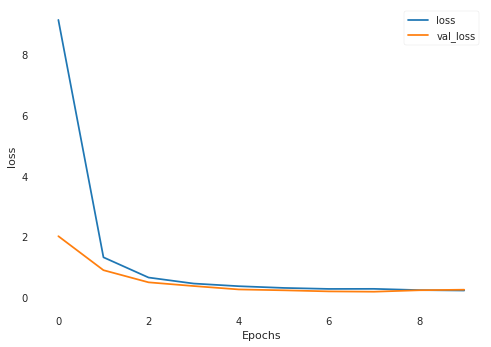

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 3s 4ms/sample - loss: 0.1059 - val_loss: 0.1266
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0790 - val_loss: 0.1208
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0697 - val_loss: 0.1043
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0633 - val_loss: 0.0966
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0595 - val_loss: 0.0989
Epoch 6/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0555 - val_loss: 0.0863
Epoch 7/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0531 - val_loss: 0.1115
Epoch 8/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0519 - val_loss: 0.0820
Epoch 9/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0489 - val_loss: 0.0922
Epoch 10/10
880/880 [=================

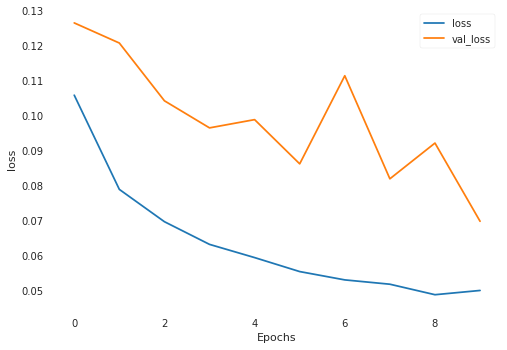

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0474 - val_loss: 0.0783
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0491 - val_loss: 0.0720
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0449 - val_loss: 0.0540
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0435 - val_loss: 0.0493
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0430 - val_loss: 0.0512
Epoch 6/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0440 - val_loss: 0.0537
Epoch 00006: early stopping
loss cuts = tf.Tensor([0.03542631], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.036662232, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.06684044], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.19080195, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.05711418], shape=(1,), dtype=float32)
mode

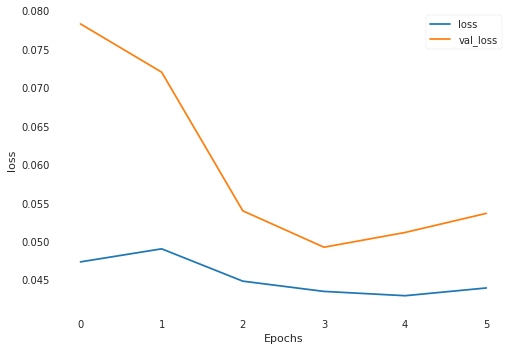

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0454 - val_loss: 0.1209
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0437 - val_loss: 0.1041
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0427 - val_loss: 0.1100
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0417 - val_loss: 0.0620
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0397 - val_loss: 0.1032
Epoch 6/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0392 - val_loss: 0.0626
Epoch 00006: early stopping
loss cuts = tf.Tensor([0.03083697], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.027802048, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03983682], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.120226115, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03689228], shape=(1,), dtype=float32)
mod

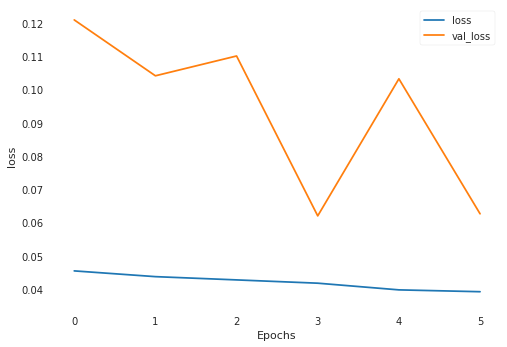

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0428 - val_loss: 0.1245
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0404 - val_loss: 0.3198
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0401 - val_loss: 0.0766
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0408 - val_loss: 0.0600
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0383 - val_loss: 0.0405
Epoch 6/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0390 - val_loss: 0.0504
Epoch 7/10
880/880 [==============================] - 1s 2ms/sample - loss: 0.0381 - val_loss: 0.3011
Epoch 00007: early stopping
loss cuts = tf.Tensor([0.0391629], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.004454487, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03801076], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.0

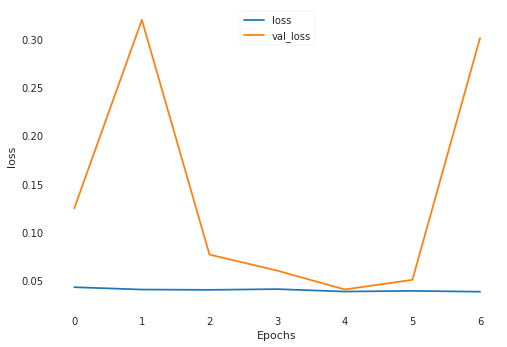

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0375 - val_loss: 0.1540
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0382 - val_loss: 0.0593
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0407 - val_loss: 0.0625
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0368 - val_loss: 0.0673
Epoch 00004: early stopping
loss cuts = tf.Tensor([0.01984904], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.12039568, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.05423144], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(1.0704566, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.04483825], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.71701103, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.04158468], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.61104476, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.

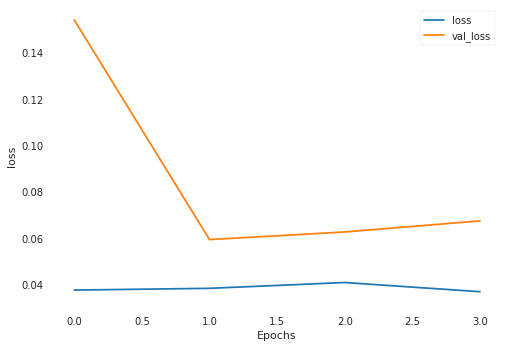

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0365 - val_loss: 0.0757
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0365 - val_loss: 0.0728
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0391 - val_loss: 0.0611
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0362 - val_loss: 0.0465
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0390 - val_loss: 0.0653
Epoch 6/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0367 - val_loss: 0.0672
Epoch 00006: early stopping
loss cuts = tf.Tensor([0.04602341], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.10859116, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.04012311], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.20029011, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.05263885], shape=(1,), dtype=float32)
model

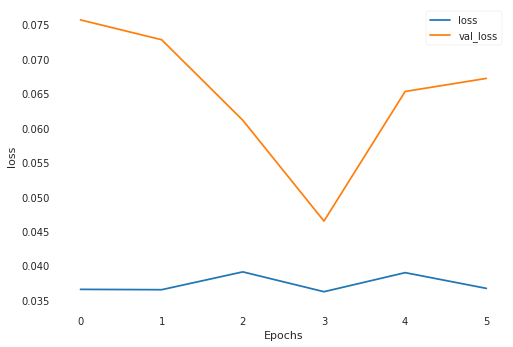

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0377 - val_loss: 0.0652
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0411 - val_loss: 0.1761
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0381 - val_loss: 0.0611
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0348 - val_loss: 0.0549
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0335 - val_loss: 0.0465
Epoch 6/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0371 - val_loss: 0.0364
Epoch 7/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0347 - val_loss: 0.0470
Epoch 8/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0346 - val_loss: 0.0515
Epoch 00008: early stopping
loss cuts = tf.Tensor([0.05799553], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.03613396, shape=(), dty

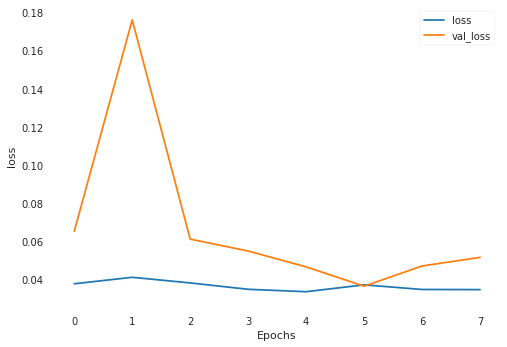

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0331 - val_loss: 0.0536
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0341 - val_loss: 0.0569
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0349 - val_loss: 0.0471
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0335 - val_loss: 0.0390
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0315 - val_loss: 0.0377
Epoch 6/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0320 - val_loss: 0.0616
Epoch 7/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0346 - val_loss: 0.0491
Epoch 00007: early stopping
loss cuts = tf.Tensor([0.03850298], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.17645016, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.0470939], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.35

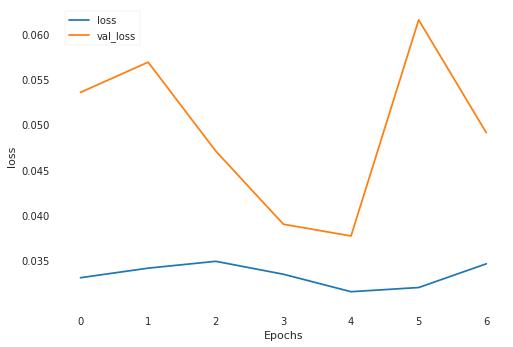

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0334 - val_loss: 0.1187
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0326 - val_loss: 0.0437
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0325 - val_loss: 0.1217
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0325 - val_loss: 0.0934
Epoch 00004: early stopping
loss cuts = tf.Tensor([0.03733978], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(9.522152, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.04242716], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(8.90456, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.04305476], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(8.829806, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.05232139], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(7.762722, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.05019876

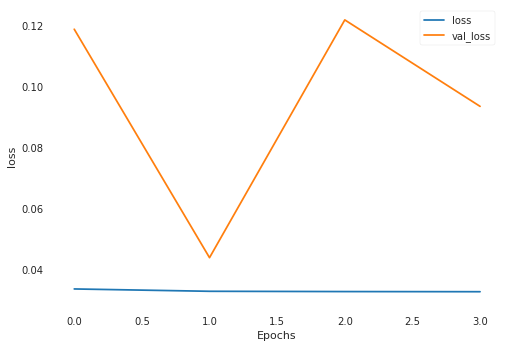

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0316 - val_loss: 0.0807
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0449 - val_loss: 0.0710
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0330 - val_loss: 0.0499
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0300 - val_loss: 0.0626
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0294 - val_loss: 0.0515
Epoch 00005: early stopping
loss cuts = tf.Tensor([0.04334856], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(3.6633406e-05, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.0404009], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.0042257435, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03665492], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.019579107, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.04487093], shape

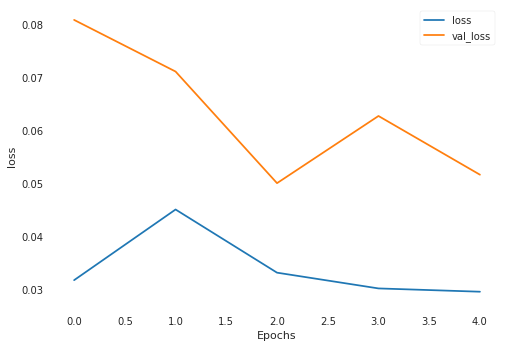

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0322 - val_loss: 0.0687
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0308 - val_loss: 0.0458
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0301 - val_loss: 0.0434
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0311 - val_loss: 0.0435
Epoch 5/10
880/880 [==============================] - 1s 2ms/sample - loss: 0.0314 - val_loss: 0.0466
Epoch 00005: early stopping
loss cuts = tf.Tensor([0.03925676], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.37198505, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03301634], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.23531944, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03850565], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.3538863, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.04267908], shape=(1,),

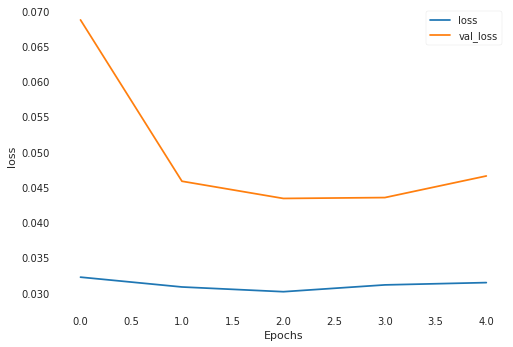

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0303 - val_loss: 0.0774
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0298 - val_loss: 0.0647
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0300 - val_loss: 0.0693
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0297 - val_loss: 0.0594
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0287 - val_loss: 0.0647
Epoch 6/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0343 - val_loss: 0.1130
Epoch 00006: early stopping
loss cuts = tf.Tensor([0.06301799], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.18437359, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02183891], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(1.5699314, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.01940158], shape=(1,), dtype=float32)
model2

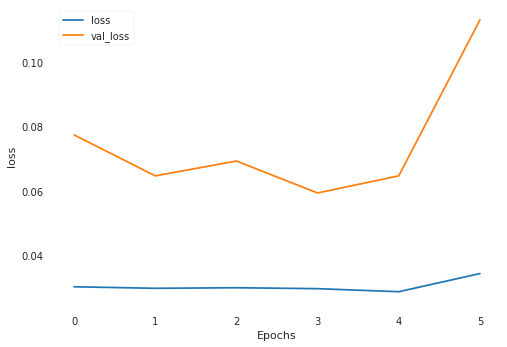

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0293 - val_loss: 0.0489
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0289 - val_loss: 0.0710
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0280 - val_loss: 0.0630
Epoch 00003: early stopping
loss cuts = tf.Tensor([0.04097607], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.6151172, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.04451557], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.73116875, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.04886593], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.8875362, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.04264723], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.6686616, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.05073779], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.9594763, shape=(), dtype=float32)
loss c

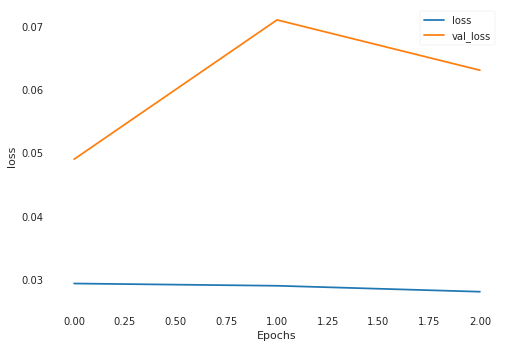

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0289 - val_loss: 0.0496
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0288 - val_loss: 0.0374
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0279 - val_loss: 0.0437
Epoch 4/10
880/880 [==============================] - 1s 2ms/sample - loss: 0.0306 - val_loss: 0.0348
Epoch 5/10
880/880 [==============================] - 1s 2ms/sample - loss: 0.0296 - val_loss: 0.0397
Epoch 6/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0275 - val_loss: 0.0383
Epoch 00006: early stopping
loss cuts = tf.Tensor([0.03328578], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.046533216, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03188683], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.035245065, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.0469889], shape=(1,), dtype=float32)
mode

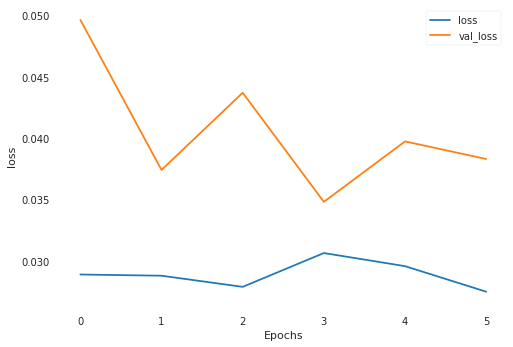

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0283 - val_loss: 0.0549
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0285 - val_loss: 0.0563
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0282 - val_loss: 0.0515
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0290 - val_loss: 0.0449
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0282 - val_loss: 0.0764
Epoch 6/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0284 - val_loss: 0.0569
Epoch 00006: early stopping
loss cuts = tf.Tensor([0.03540115], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.22761577, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02881329], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.37069592, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02449348], shape=(1,), dtype=float32)
model

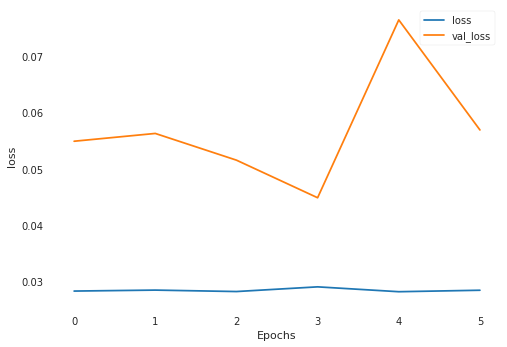

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0277 - val_loss: 0.0813
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0281 - val_loss: 0.0362
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0274 - val_loss: 0.0473
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0270 - val_loss: 0.0741
Epoch 00004: early stopping
loss cuts = tf.Tensor([0.02829931], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.00025556062, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.04624778], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.14059165, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.04525947], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.1261595, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02486045], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.002786896, shape=(), dtype=float32)
loss cuts = tf.Tensor

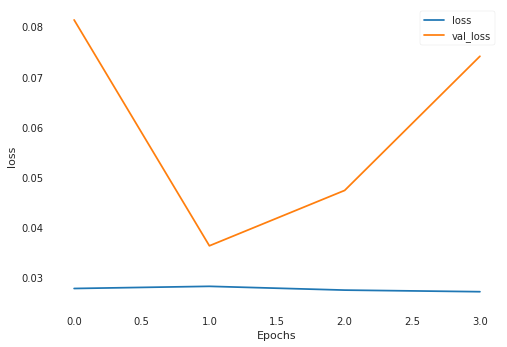

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0284 - val_loss: 0.1225
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0274 - val_loss: 0.0803
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0265 - val_loss: 0.0777
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0272 - val_loss: 0.1100
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0265 - val_loss: 0.1104
Epoch 00005: early stopping
loss cuts = tf.Tensor([0.01952266], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(11.09198, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.0234425], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(10.5759325, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02772146], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(10.026637, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03651153], shape=(1,), dt

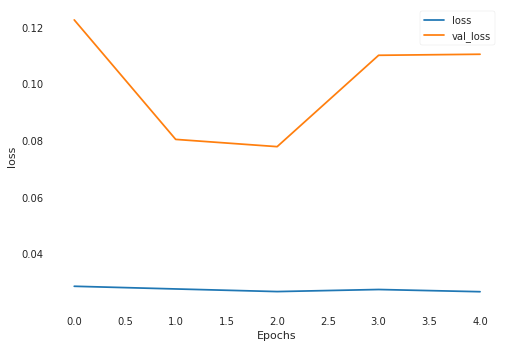

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0275 - val_loss: 0.1383
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0355 - val_loss: 0.1058
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0279 - val_loss: 0.0937
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0260 - val_loss: 0.0776
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0260 - val_loss: 0.0877
Epoch 6/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0254 - val_loss: 0.0697
Epoch 7/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0257 - val_loss: 0.0818
Epoch 8/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0256 - val_loss: 0.0806
Epoch 00008: early stopping
loss cuts = tf.Tensor([0.02027086], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.053077567, shape=(), dt

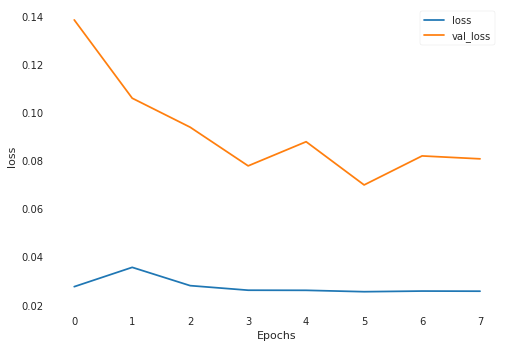

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0265 - val_loss: 0.1084
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0271 - val_loss: 0.0870
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0256 - val_loss: 0.0737
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0257 - val_loss: 0.0687
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0260 - val_loss: 0.0712
Epoch 6/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0257 - val_loss: 0.0695
Epoch 00006: early stopping
loss cuts = tf.Tensor([0.01801148], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.38192543, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.01753132], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.3938871, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.01590986], shape=(1,), dtype=float32)
model2

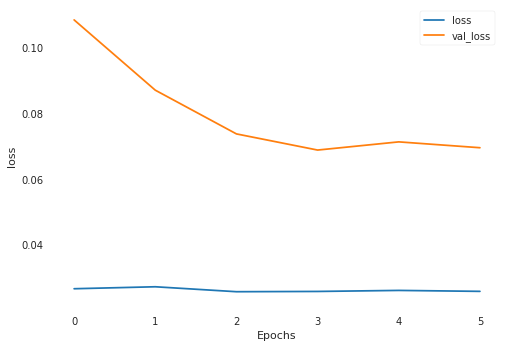

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0254 - val_loss: 0.0726
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0252 - val_loss: 0.2059
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0248 - val_loss: 0.0792
Epoch 00003: early stopping
loss cuts = tf.Tensor([0.03363874], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(4.6774206, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02131315], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(5.804467, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.01906144], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(6.0234933, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02551592], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(5.406513, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03157431], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(4.857718, shape=(), dtype=float32)
loss cuts 

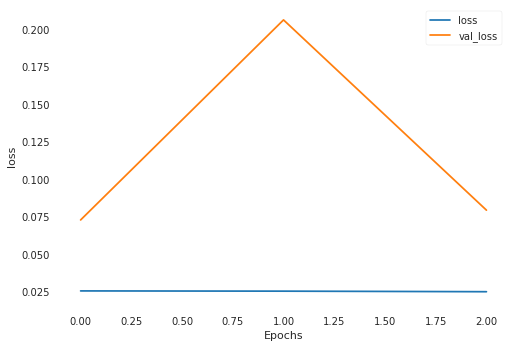

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0258 - val_loss: 0.1297
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0253 - val_loss: 0.0771
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0261 - val_loss: 0.0799
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0257 - val_loss: 0.0596
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0248 - val_loss: 0.0673
Epoch 6/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0247 - val_loss: 0.0782
Epoch 00006: early stopping
loss cuts = tf.Tensor([0.02969197], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.018217571, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03040739], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.022284815, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03176867], shape=(1,), dtype=float32)
mod

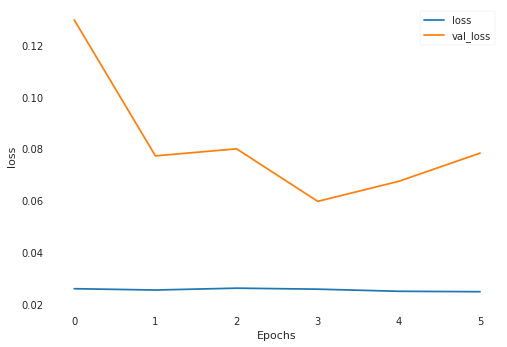

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0954 - val_loss: 0.1337
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0366 - val_loss: 0.0933
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0293 - val_loss: 0.0869
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0278 - val_loss: 0.0736
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0259 - val_loss: 0.0754
Epoch 6/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0242 - val_loss: 0.0626
Epoch 7/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0248 - val_loss: 0.0701
Epoch 8/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0243 - val_loss: 0.0663
Epoch 00008: early stopping
loss cuts = tf.Tensor([0.03639833], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.0737632, shape=(), dtyp

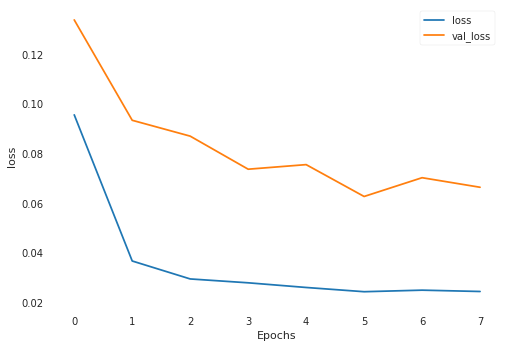

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0244 - val_loss: 0.0549
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0238 - val_loss: 0.0398
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0237 - val_loss: 0.0516
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0231 - val_loss: 0.0535
Epoch 00004: early stopping
loss cuts = tf.Tensor([0.02365842], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.07462093, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02803151], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.13005415, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03493892], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.24878001, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.04194319], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.40814695, shape=(), dtype=float32)
loss cuts = tf.Tensor([0

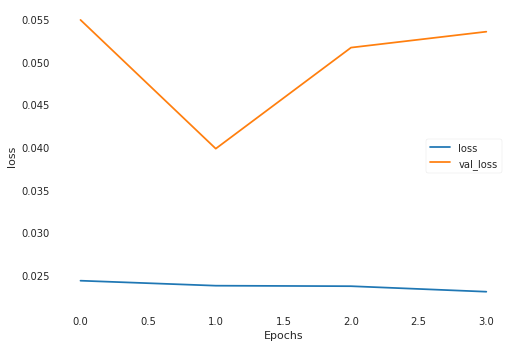

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0242 - val_loss: 0.1324
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0232 - val_loss: 0.1110
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0238 - val_loss: 0.1304
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0233 - val_loss: 0.1078
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0238 - val_loss: 0.1039
Epoch 6/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0230 - val_loss: 0.1094
Epoch 7/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0230 - val_loss: 0.1029
Epoch 8/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0233 - val_loss: 0.1266
Epoch 9/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0236 - val_loss: 0.1269
Epoch 00009: early stopping
loss cuts 

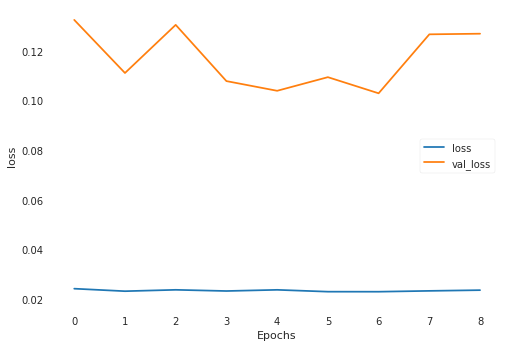

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0236 - val_loss: 0.0878
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0228 - val_loss: 0.0918
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0227 - val_loss: 0.0829
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0227 - val_loss: 0.0794
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0231 - val_loss: 0.0801
Epoch 6/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0228 - val_loss: 0.0814
Epoch 00006: early stopping
loss cuts = tf.Tensor([0.03087237], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.008441599, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02557297], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.00019908618, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02107474], shape=(1,), dtype=float32)
m

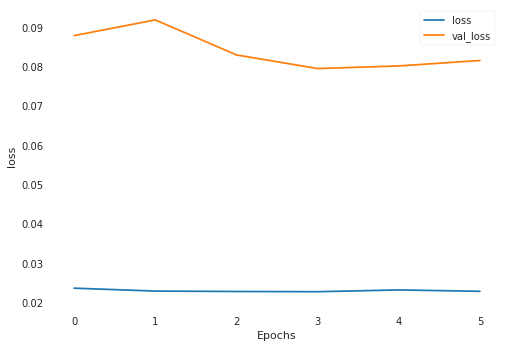

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0236 - val_loss: 0.1297
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0229 - val_loss: 0.0949
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0224 - val_loss: 0.1254
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0234 - val_loss: 0.0853
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0229 - val_loss: 0.1132
Epoch 6/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0221 - val_loss: 0.1023
Epoch 00006: early stopping
loss cuts = tf.Tensor([0.0194542], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.5850342, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02123555], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.5318029, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02630858], shape=(1,), dtype=float32)
model2 l

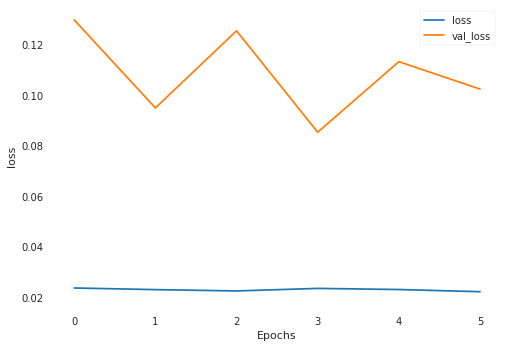

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0234 - val_loss: 0.0850
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0234 - val_loss: 0.0767
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0219 - val_loss: 0.0491
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0232 - val_loss: 0.0965
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0228 - val_loss: 0.0520
Epoch 00005: early stopping
loss cuts = tf.Tensor([0.02752453], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.18781115, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.022646], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.28189993, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.0235995], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.26201332, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02026423], shape=(1,), d

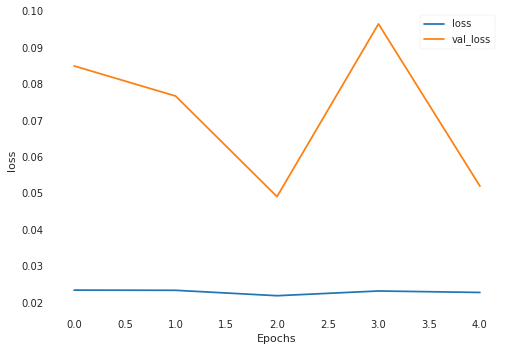

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0234 - val_loss: 0.0957
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0224 - val_loss: 0.0604
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0235 - val_loss: 0.0652
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0224 - val_loss: 0.0601
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0223 - val_loss: 0.0821
Epoch 6/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0217 - val_loss: 0.0388
Epoch 7/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0223 - val_loss: 0.0525
Epoch 8/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0223 - val_loss: 0.0631
Epoch 00008: early stopping
loss cuts = tf.Tensor([0.01433283], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(2.4338405, shape=(), dtyp

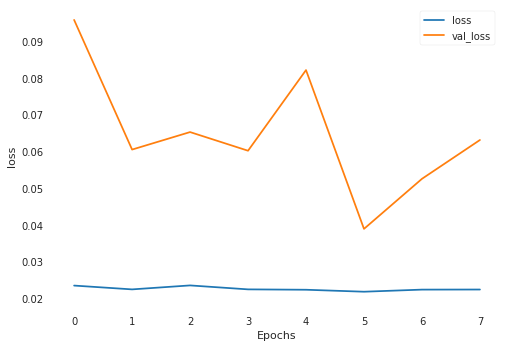

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0223 - val_loss: 0.0490
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0217 - val_loss: 0.0336
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0223 - val_loss: 0.0300
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0216 - val_loss: 0.0651
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0216 - val_loss: 0.0770
Epoch 00005: early stopping
loss cuts = tf.Tensor([0.02370952], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(6.0011067, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02372336], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(5.9997506, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02461275], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(5.912927, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02706819], shape=(1,), dt

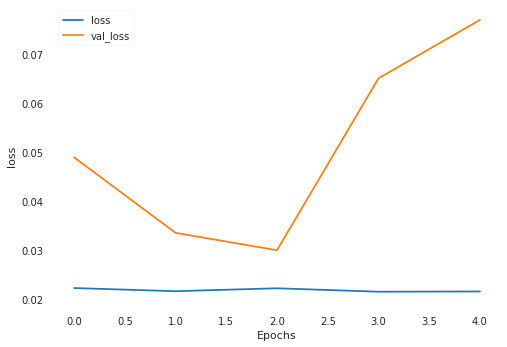

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0212 - val_loss: 0.0637
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0221 - val_loss: 0.0517
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0213 - val_loss: 0.0726
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0215 - val_loss: 0.0453
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0216 - val_loss: 0.0626
Epoch 6/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0215 - val_loss: 0.0553
Epoch 00006: early stopping
loss cuts = tf.Tensor([0.01938303], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.06882191, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02517985], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.021433843, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02319025], shape=(1,), dtype=float32)
mode

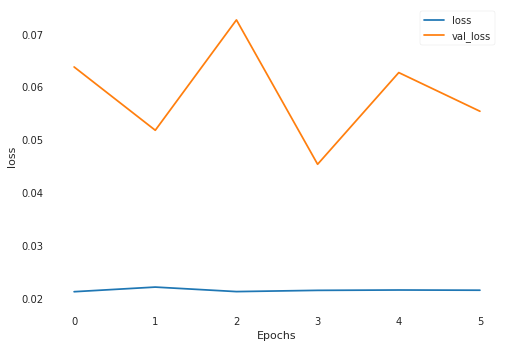

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0212 - val_loss: 0.0592
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0320 - val_loss: 0.0345
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0208 - val_loss: 0.0613
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0210 - val_loss: 0.0434
Epoch 00004: early stopping
loss cuts = tf.Tensor([0.02431911], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.012909006, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03086003], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.00029586026, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02079823], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.033869047, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.01709378], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.06662818, shape=(), dtype=float32)
loss cuts = tf.Tens

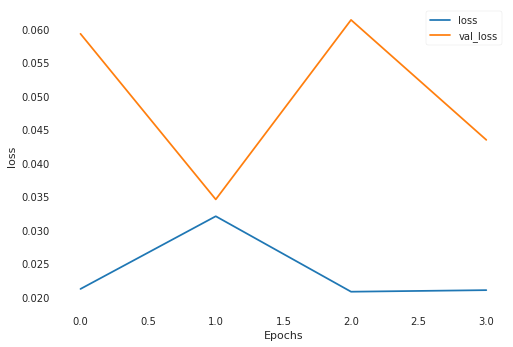

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0203 - val_loss: 0.0230
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0208 - val_loss: 0.0506
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0215 - val_loss: 0.0330
Epoch 00003: early stopping
loss cuts = tf.Tensor([0.03115481], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.0059141885, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03056094], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.007882108, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02502226], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.039822143, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02432788], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.04555764, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03002709], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.009891913, shape=(), dtype=float3

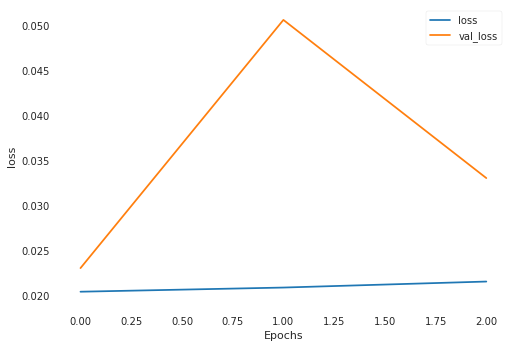

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0205 - val_loss: 0.0435
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0207 - val_loss: 0.0389
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0203 - val_loss: 0.0468
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0198 - val_loss: 0.0325
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0199 - val_loss: 0.0286
Epoch 6/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0205 - val_loss: 0.0250
Epoch 7/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0203 - val_loss: 0.0311
Epoch 8/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0213 - val_loss: 0.0250
Epoch 00008: early stopping
loss cuts = tf.Tensor([0.02299637], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.40969306, shape=(), dty

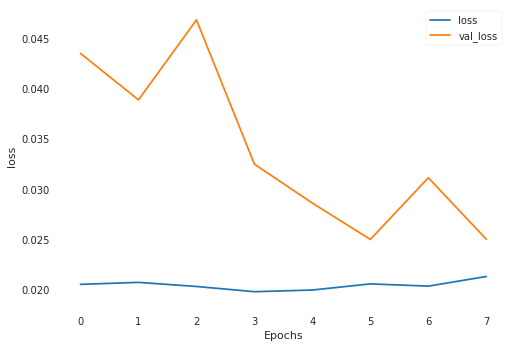

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0208 - val_loss: 0.0295
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0211 - val_loss: 0.0343
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0200 - val_loss: 0.0184
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0198 - val_loss: 0.0267
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0199 - val_loss: 0.0322
Epoch 00005: early stopping
loss cuts = tf.Tensor([0.03266643], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.35601684, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02554576], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.5462464, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02605285], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.5313577, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.0333885], shape=(1,), d

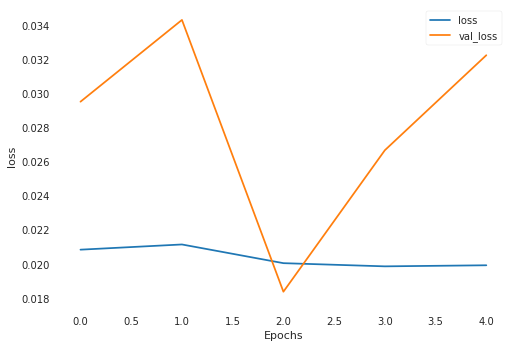

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0202 - val_loss: 0.0287
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0194 - val_loss: 0.0305
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0195 - val_loss: 0.0359
Epoch 00003: early stopping
loss cuts = tf.Tensor([0.01874126], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.03543281, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02586161], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.002100286, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02297463], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.010726445, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.01957778], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.02941416, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02029982], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.024669321, shape=(), dtype=float32)

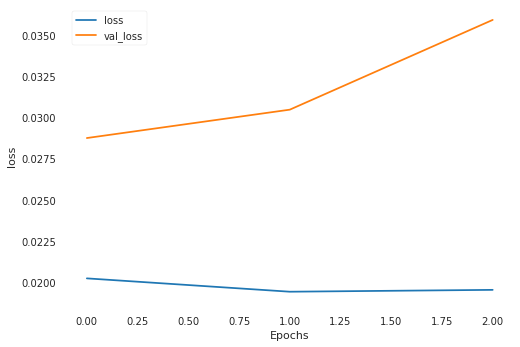

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0199 - val_loss: 0.0384
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0206 - val_loss: 0.0319
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0194 - val_loss: 0.0352
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0416 - val_loss: 0.1976
Epoch 00004: early stopping
loss cuts = tf.Tensor([0.02016471], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.038693156, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.04115865], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.04980617, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.04519241], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.0923237, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02753543], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.0024296453, shape=(), dtype=float32)
loss cuts = tf.Tensor(

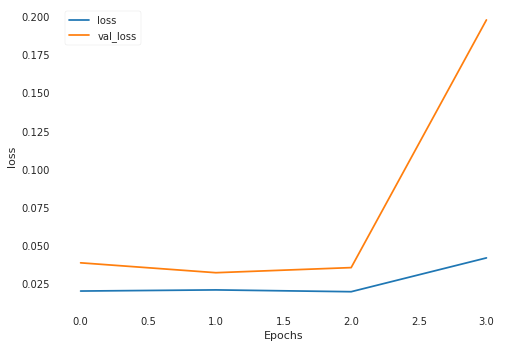

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0342 - val_loss: 0.0430
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0207 - val_loss: 0.0305
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0193 - val_loss: 0.0408
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0195 - val_loss: 0.0515
Epoch 00004: early stopping
loss cuts = tf.Tensor([0.02693342], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.0021141884, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03082231], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.015316099, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02519475], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.00012559583, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02545234], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.0002676111, shape=(), dtype=float32)
loss cuts = tf.T

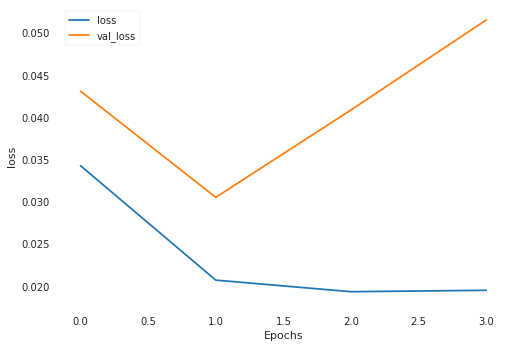

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0189 - val_loss: 0.0770
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0185 - val_loss: 0.0849
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0184 - val_loss: 0.0743
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0189 - val_loss: 0.0925
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0185 - val_loss: 0.0752
Epoch 00005: early stopping
loss cuts = tf.Tensor([0.02011522], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(7.945816, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02243014], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(7.686944, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02374168], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(7.542182, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02213375], shape=(1,), dtyp

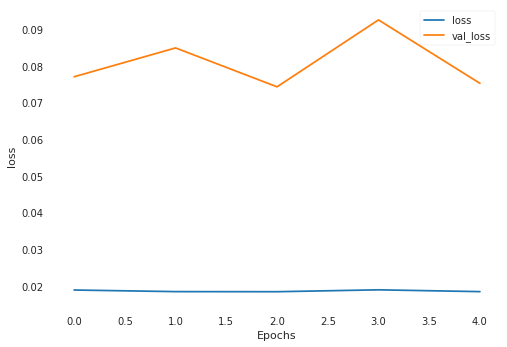

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0190 - val_loss: 0.0541
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0189 - val_loss: 0.0429
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0185 - val_loss: 0.0436
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0185 - val_loss: 0.0522
Epoch 00004: early stopping
loss cuts = tf.Tensor([0.0417437], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.04627921, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03376304], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.1404295, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03435579], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.13168496, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03019207], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.19905753, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.0

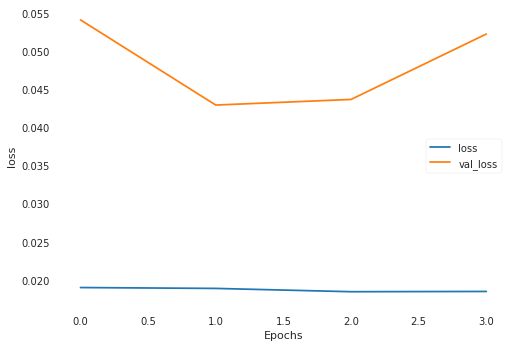

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0188 - val_loss: 0.0601
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0193 - val_loss: 0.0435
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0186 - val_loss: 0.0861
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0186 - val_loss: 0.0235
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0184 - val_loss: 0.0452
Epoch 6/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0194 - val_loss: 0.0572
Epoch 00006: early stopping
loss cuts = tf.Tensor([0.02474121], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.6887369, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02016387], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.8490675, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.01863866], shape=(1,), dtype=float32)
model2 

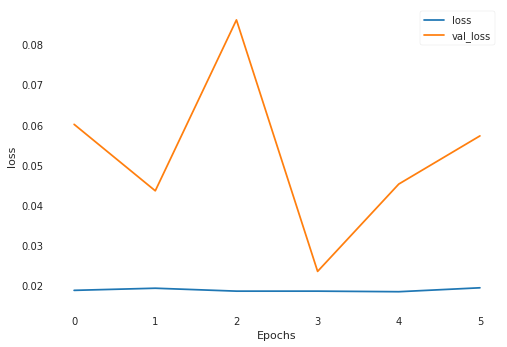

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0189 - val_loss: 0.0472
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0191 - val_loss: 0.0462
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0188 - val_loss: 0.0584
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0187 - val_loss: 0.0403
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0187 - val_loss: 0.0575
Epoch 6/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0184 - val_loss: 0.0451
Epoch 00006: early stopping
loss cuts = tf.Tensor([0.03269379], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.36466593, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03066845], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.31738466, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03506494], shape=(1,), dtype=float32)
model

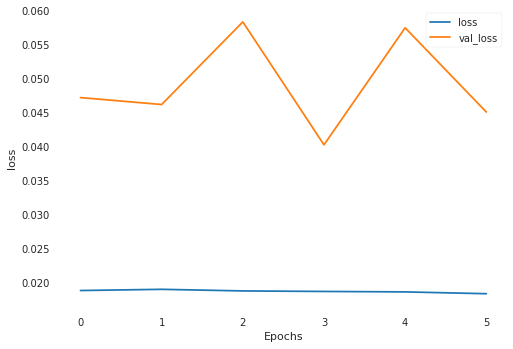

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0233 - val_loss: 0.1000
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0361 - val_loss: 0.0636
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0190 - val_loss: 0.0493
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0184 - val_loss: 0.0357
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0180 - val_loss: 0.0399
Epoch 6/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0178 - val_loss: 0.0242
Epoch 7/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0184 - val_loss: 0.0270
Epoch 8/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0178 - val_loss: 0.0313
Epoch 00008: early stopping
loss cuts = tf.Tensor([0.0291197], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.66847944, shape=(), dtyp

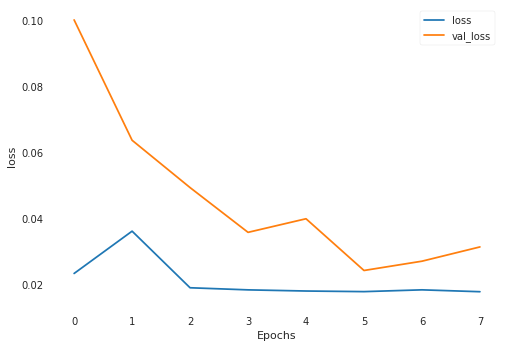

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0178 - val_loss: 0.0299
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0178 - val_loss: 0.0282
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0178 - val_loss: 0.0240
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0180 - val_loss: 0.0558
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0179 - val_loss: 0.0560
Epoch 00005: early stopping
loss cuts = tf.Tensor([0.03752558], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(3.7219136, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.04289541], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(3.319063, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.04366604], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(3.2631423, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03486773], shape=(1,), dt

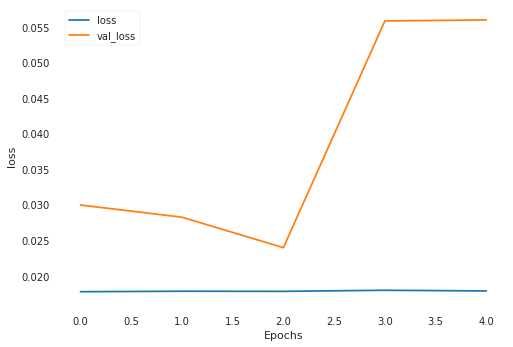

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0182 - val_loss: 0.0314
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0177 - val_loss: 0.0254
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0177 - val_loss: 0.0309
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0181 - val_loss: 0.0263
Epoch 00004: early stopping
loss cuts = tf.Tensor([0.03051974], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.2911737, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03459684], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.20982194, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03537354], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.19583204, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03708583], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.16669534, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.

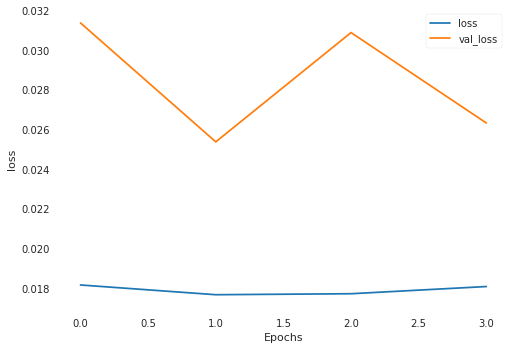

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0179 - val_loss: 0.0482
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0172 - val_loss: 0.0409
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0179 - val_loss: 0.0438
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0179 - val_loss: 0.0371
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0174 - val_loss: 0.0397
Epoch 6/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0183 - val_loss: 0.0385
Epoch 00006: early stopping
loss cuts = tf.Tensor([0.0413761], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(1.2351618, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03664168], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(1.454597, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03599731], shape=(1,), dtype=float32)
model2 lo

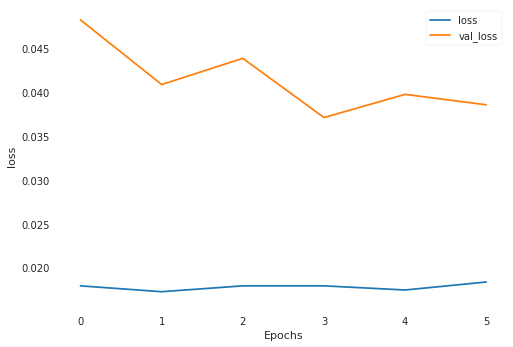

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0171 - val_loss: 0.0553
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0173 - val_loss: 0.0509
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0175 - val_loss: 0.0571
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0182 - val_loss: 0.0523
Epoch 00004: early stopping
loss cuts = tf.Tensor([0.03370087], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.8655995, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03340395], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.87668467, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03362063], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.8685881, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03666313], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.75886893, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.0

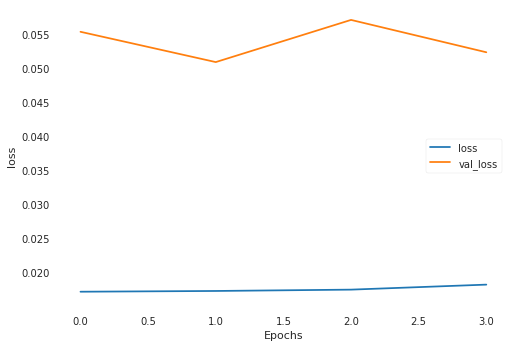

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0174 - val_loss: 0.0390
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0172 - val_loss: 0.0521
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0173 - val_loss: 0.0311
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0170 - val_loss: 0.0552
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0172 - val_loss: 0.0403
Epoch 00005: early stopping
loss cuts = tf.Tensor([0.02847235], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(2.0464818, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03027746], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(1.9444933, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03056441], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(1.9285208, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02950338], shape=(1,), d

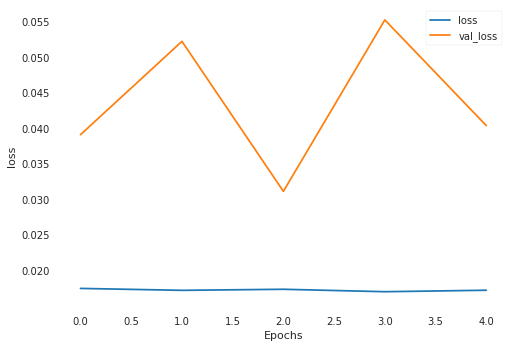

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0186 - val_loss: 0.0602
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0168 - val_loss: 0.0826
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0167 - val_loss: 0.0442
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0169 - val_loss: 0.0448
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0168 - val_loss: 0.0674
Epoch 00005: early stopping
loss cuts = tf.Tensor([0.04071157], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(1.7278359, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.0392628], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(1.8048505, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03760725], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(1.8949125, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03813322], shape=(1,), dt

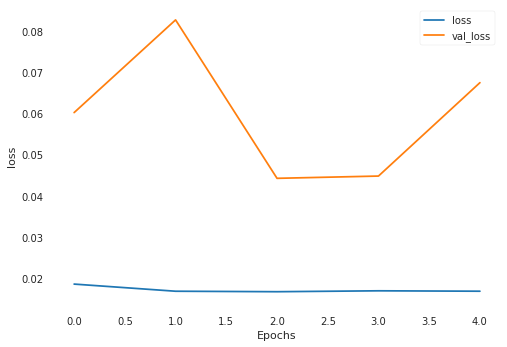

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0182 - val_loss: 0.0591
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0171 - val_loss: 0.0512
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0170 - val_loss: 0.0546
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0182 - val_loss: 0.0564
Epoch 00004: early stopping
loss cuts = tf.Tensor([0.02313993], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.2141826, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02349048], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.22072096, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02316779], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.21469855, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.0218702], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.19132221, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.0

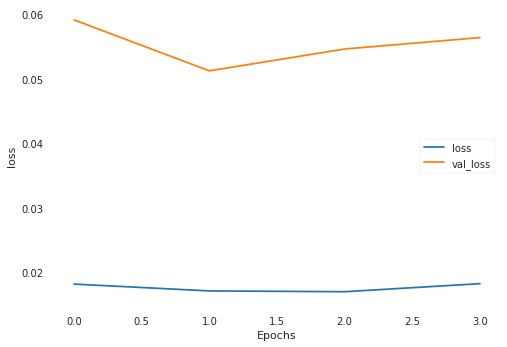

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0171 - val_loss: 0.0401
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0174 - val_loss: 0.0299
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0164 - val_loss: 0.0549
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0170 - val_loss: 0.0721
Epoch 00004: early stopping
loss cuts = tf.Tensor([0.03431652], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.29839316, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03450779], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.3025872, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02965979], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.20531702, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02829645], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.18135034, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.

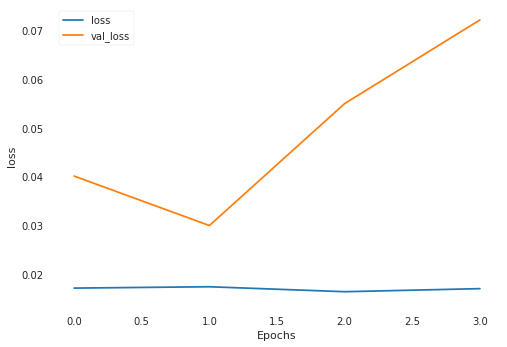

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0171 - val_loss: 0.0191
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0166 - val_loss: 0.0223
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0165 - val_loss: 0.0321
Epoch 00003: early stopping
loss cuts = tf.Tensor([0.02992776], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(4.8463583, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.0279754], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(5.019805, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02793896], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(5.0230703, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02826749], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(4.9936614, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02794763], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(5.0222936, shape=(), dtype=float32)
loss cuts

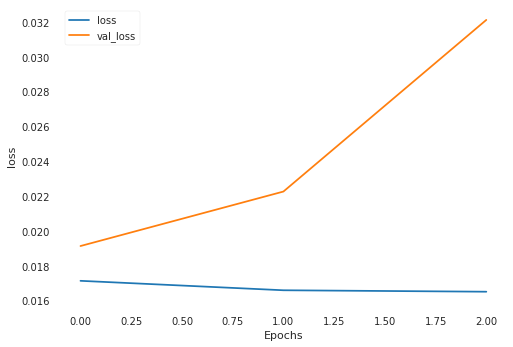

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0163 - val_loss: 0.0716
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0163 - val_loss: 0.0558
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0167 - val_loss: 0.0230
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0161 - val_loss: 0.0565
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0171 - val_loss: 0.0531
Epoch 00005: early stopping
loss cuts = tf.Tensor([0.02891533], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.5705204, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02909846], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.56500065, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02493039], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.6972697, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02439287], shape=(1,), 

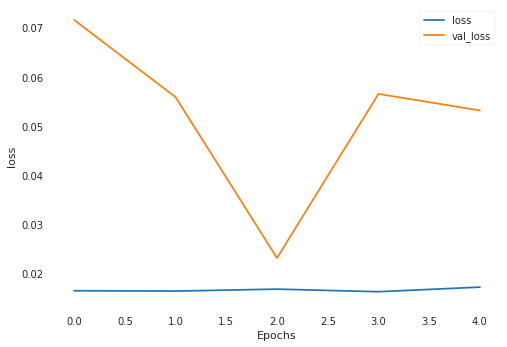

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0167 - val_loss: 0.0637
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0170 - val_loss: 0.1092
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0181 - val_loss: 0.0752
Epoch 00003: early stopping
loss cuts = tf.Tensor([0.0159282], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.0046767006, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.01444008], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.009633192, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.01245976], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.018976483, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.01398813], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.011489239, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.01564591], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.005480765, shape=(), dtype=float3

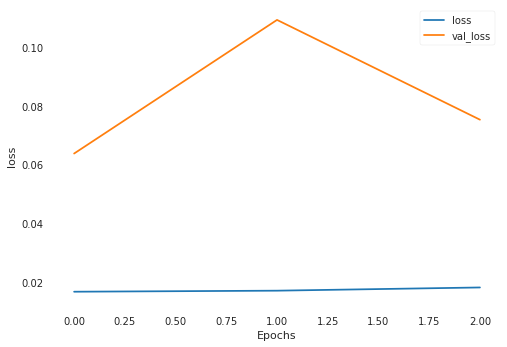

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0166 - val_loss: 0.0694
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0160 - val_loss: 0.0492
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0163 - val_loss: 0.0621
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0163 - val_loss: 0.0459
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0161 - val_loss: 0.0554
Epoch 6/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0159 - val_loss: 0.0537
Epoch 00006: early stopping
loss cuts = tf.Tensor([0.01209884], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.20978522, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.01278167], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.19746174, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.01321647], shape=(1,), dtype=float32)
model

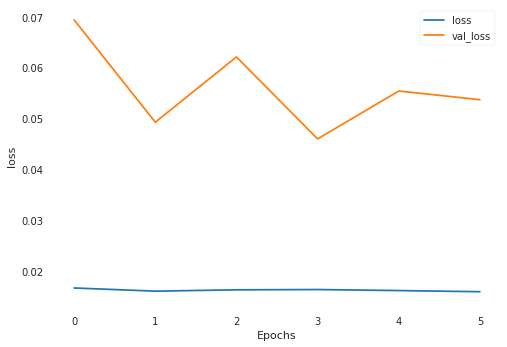

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0162 - val_loss: 0.0607
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0167 - val_loss: 0.0628
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0160 - val_loss: 0.0597
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0157 - val_loss: 0.0397
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0157 - val_loss: 0.0534
Epoch 6/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0172 - val_loss: 0.0512
Epoch 00006: early stopping
loss cuts = tf.Tensor([0.03209896], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.3696892, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03064295], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.40594864, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03707571], shape=(1,), dtype=float32)
model2

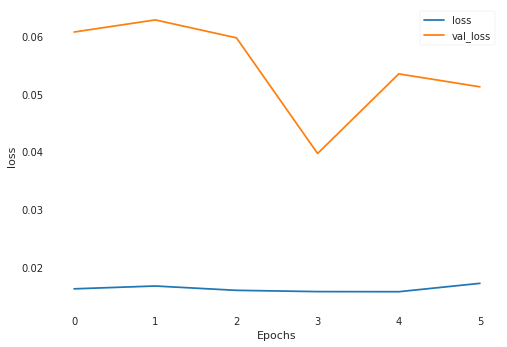

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0292 - val_loss: 1.0411
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0904 - val_loss: 0.1231
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0258 - val_loss: 0.0572
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0191 - val_loss: 0.0688
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0172 - val_loss: 0.0631
Epoch 00005: early stopping
loss cuts = tf.Tensor([0.02992318], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.35815874, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02803527], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.31439063, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03093547], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.38280138, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.0320144], shape=(1,),

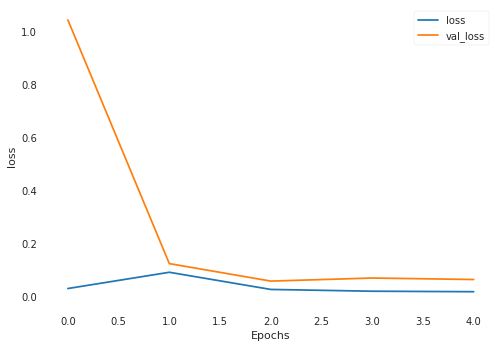

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0164 - val_loss: 0.0734
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0154 - val_loss: 0.0600
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0151 - val_loss: 0.0797
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0152 - val_loss: 0.0789
Epoch 00004: early stopping
loss cuts = tf.Tensor([0.0251944], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.36924684, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02371149], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.40617037, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02477951], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.3794002, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02279747], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.42980537, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.0

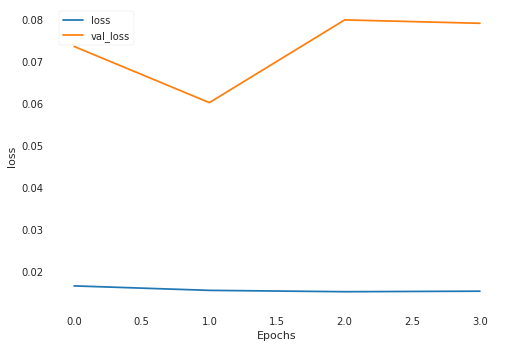

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0150 - val_loss: 0.1374
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0148 - val_loss: 0.1902
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0147 - val_loss: 0.1386
Epoch 00003: early stopping
loss cuts = tf.Tensor([0.02975976], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.0012096751, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02483806], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.0040517943, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02420512], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.0058235996, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02629978], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.001184684, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03032135], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.0021171193, shape=(), dtype=fl

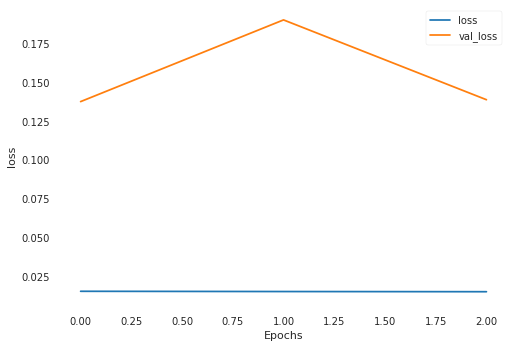

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0157 - val_loss: 0.1349
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0152 - val_loss: 0.1572
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0145 - val_loss: 0.1196
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0151 - val_loss: 0.0827
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0147 - val_loss: 0.1546
Epoch 6/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0147 - val_loss: 0.1332
Epoch 00006: early stopping
loss cuts = tf.Tensor([0.04429861], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.541655, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03548487], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.3132613, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.04528621], shape=(1,), dtype=float32)
model2 l

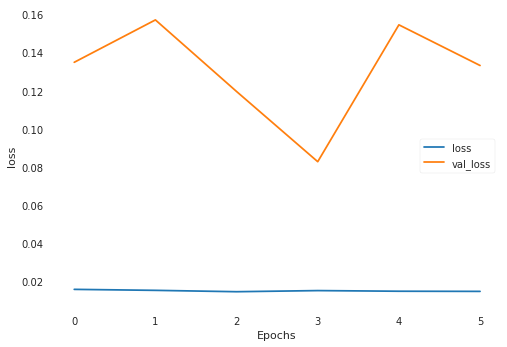

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0153 - val_loss: 0.0757
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0283 - val_loss: 0.1753
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0162 - val_loss: 0.2154
Epoch 00003: early stopping
loss cuts = tf.Tensor([0.02539029], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.05253204, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.0222299], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.0855016, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02615082], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.04579092, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02585518], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.048356436, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02389055], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.06718126, shape=(), dtype=float32)
los

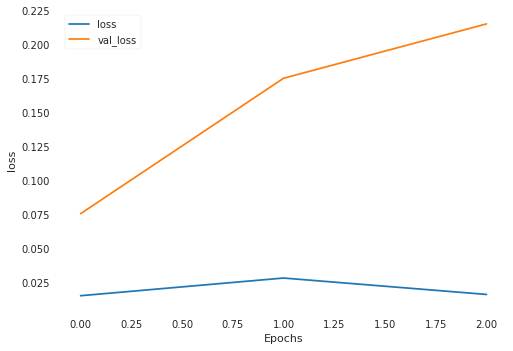

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0150 - val_loss: 0.3816
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0149 - val_loss: 0.2277
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0152 - val_loss: 0.2839
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0147 - val_loss: 0.3337
Epoch 00004: early stopping
loss cuts = tf.Tensor([0.02856393], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(6.14388, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02936536], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(6.0646772, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02508697], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(6.493448, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.0253412], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(6.4675593, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.0288829

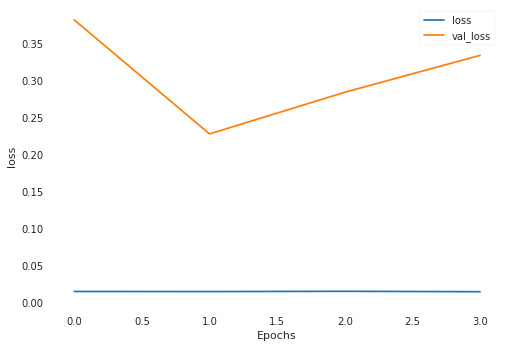

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0151 - val_loss: 0.3854
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0153 - val_loss: 0.2697
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0153 - val_loss: 0.3479
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0154 - val_loss: 0.2291
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0150 - val_loss: 0.2466
Epoch 6/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0150 - val_loss: 0.2243
Epoch 7/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0150 - val_loss: 0.2237
Epoch 8/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0152 - val_loss: 0.2452
Epoch 9/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0154 - val_loss: 0.2679
Epoch 00009: early stopping
loss cuts 

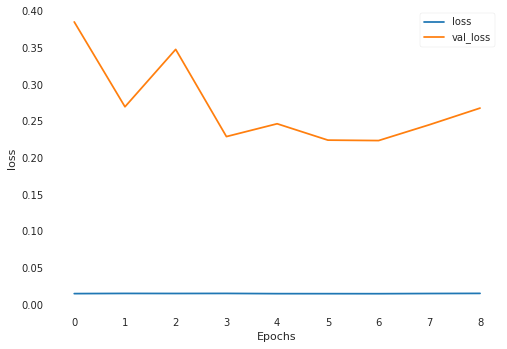

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0157 - val_loss: 0.3118
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0255 - val_loss: 0.2870
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0164 - val_loss: 0.2159
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0147 - val_loss: 0.2326
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0148 - val_loss: 0.2510
Epoch 00005: early stopping
loss cuts = tf.Tensor([0.05256776], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.25135708, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.05339151], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.2681481, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03981279], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.060641926, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.04291064], shape=(1,)

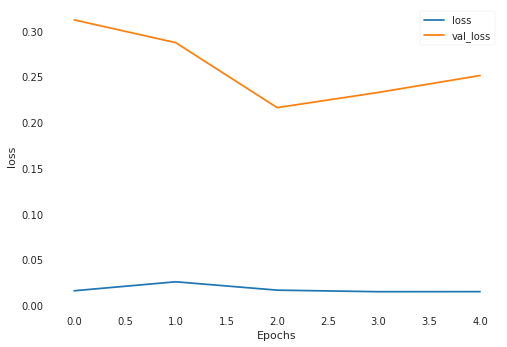

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0158 - val_loss: 0.1335
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0151 - val_loss: 0.0832
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0158 - val_loss: 0.0656
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0150 - val_loss: 0.1398
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0158 - val_loss: 0.0827
Epoch 00005: early stopping
loss cuts = tf.Tensor([0.04020442], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.076853015, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03674683], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.043293886, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03677519], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.04353032, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.04211413], shape=(1

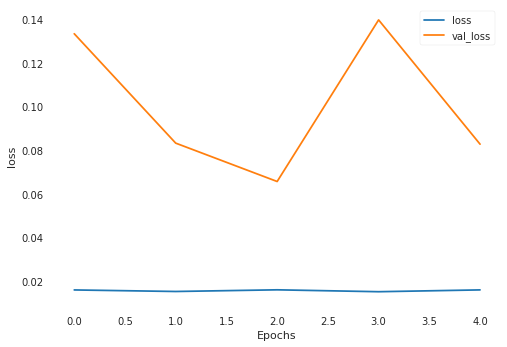

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0227 - val_loss: 0.0789
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0157 - val_loss: 0.0553
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0162 - val_loss: 0.0620
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0150 - val_loss: 0.0699
Epoch 00004: early stopping
loss cuts = tf.Tensor([0.03005416], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.06282391, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02128936], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.005677778, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02173221], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.007090974, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02245209], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.009723041, shape=(), dtype=float32)
loss cuts = tf.Tensor

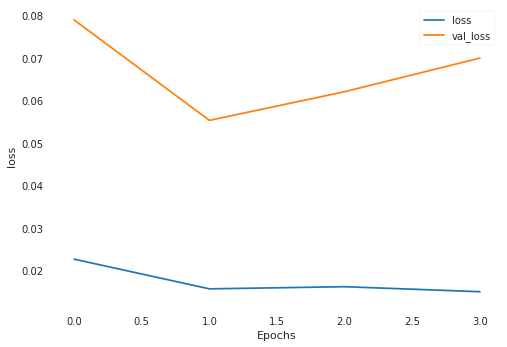

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0151 - val_loss: 0.0699
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0149 - val_loss: 0.0892
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0153 - val_loss: 0.0704
Epoch 00003: early stopping
loss cuts = tf.Tensor([0.02502285], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.26068574, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02024223], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.36746195, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.01962729], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.38252375, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02096883], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.3500549, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02149319], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.3377552, shape=(), dtype=float32)
loss

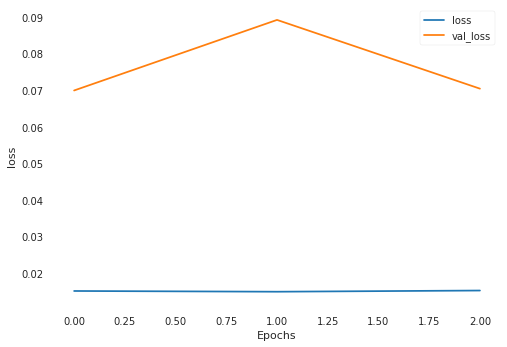

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0153 - val_loss: 0.2099
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0152 - val_loss: 0.0891
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0147 - val_loss: 0.0827
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0151 - val_loss: 0.0947
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0149 - val_loss: 0.1413
Epoch 00005: early stopping
loss cuts = tf.Tensor([0.01524007], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.010983353, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.01370235], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.0054829693, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.0142197], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.007122361, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.01334158], shape=(

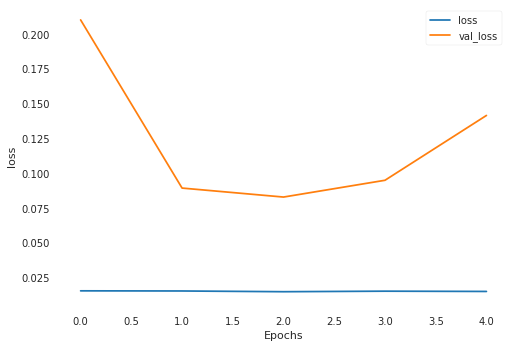

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.1121 - val_loss: 0.0939
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0287 - val_loss: 0.1696
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0202 - val_loss: 0.0719
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0174 - val_loss: 0.1776
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0158 - val_loss: 0.4174
Epoch 00005: early stopping
loss cuts = tf.Tensor([0.0185185], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.1879115, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.01739978], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.20781012, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.01911093], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.17777939, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02316735], shape=(1,), 

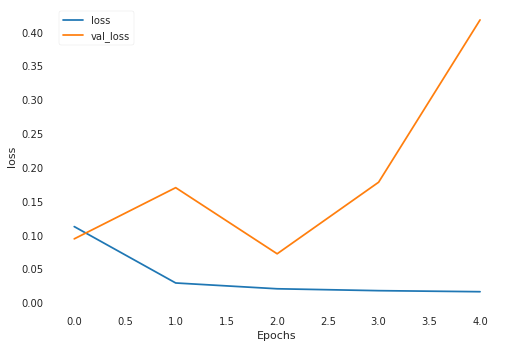

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0333 - val_loss: 0.1925
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0207 - val_loss: 0.1334
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0156 - val_loss: 0.1342
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0151 - val_loss: 0.1982
Epoch 00004: early stopping
loss cuts = tf.Tensor([0.02221945], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.21859384, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.01991397], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.26383632, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.0192208], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.27827024, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.01789144], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.30702725, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.

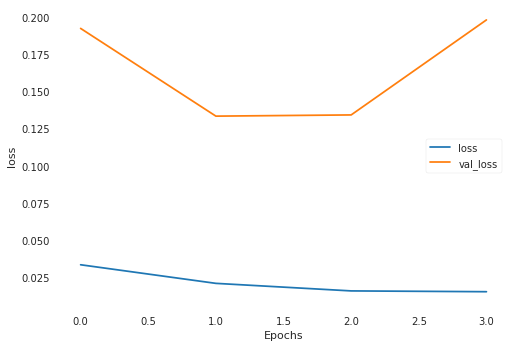

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0148 - val_loss: 0.1105
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0143 - val_loss: 0.1561
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0140 - val_loss: 0.1144
Epoch 00003: early stopping
loss cuts = tf.Tensor([0.01742493], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.078496195, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.01659267], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.0881003, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.01622943], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.09246576, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.01565158], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.09962782, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.0164384], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.089941405, shape=(), dtype=float32)
lo

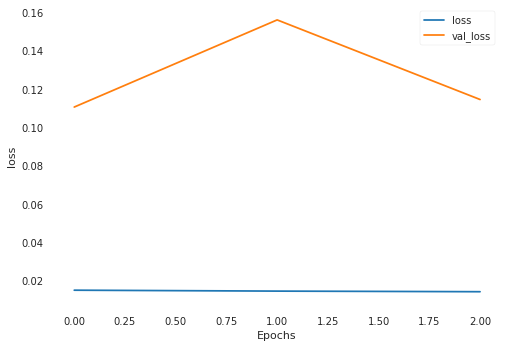

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0142 - val_loss: 0.2309
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0141 - val_loss: 0.1076
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0142 - val_loss: 0.1372
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0146 - val_loss: 0.0701
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0140 - val_loss: 0.1167
Epoch 6/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0144 - val_loss: 0.2673
Epoch 00006: early stopping
loss cuts = tf.Tensor([0.02024757], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.0020293812, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02458459], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.0017382095, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02017029], shape=(1,), dtype=float32)
m

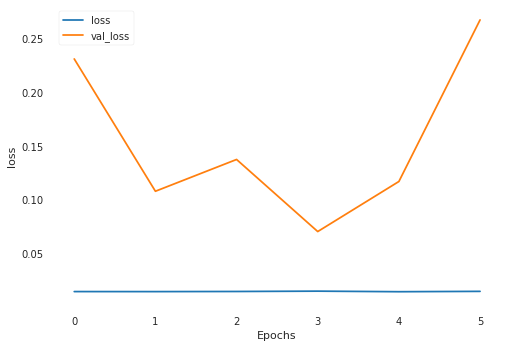

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0152 - val_loss: 0.1695
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0145 - val_loss: 0.1084
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0145 - val_loss: 0.4198
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0147 - val_loss: 0.2375
Epoch 00004: early stopping
loss cuts = tf.Tensor([0.02708258], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(8.974988, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02874693], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(8.776651, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02659046], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(9.034057, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02605229], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(9.098874, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.023844]

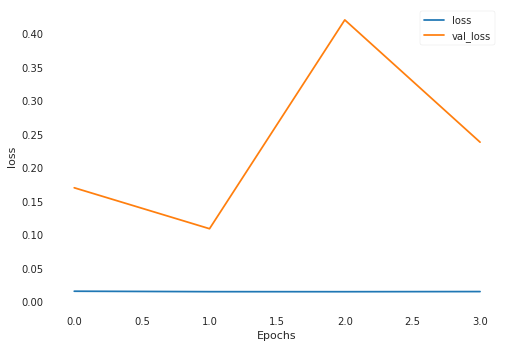

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0144 - val_loss: 0.1749
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0144 - val_loss: 0.1414
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0141 - val_loss: 0.1553
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0146 - val_loss: 0.1010
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0150 - val_loss: 0.1590
Epoch 6/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0143 - val_loss: 0.1482
Epoch 00006: early stopping
loss cuts = tf.Tensor([0.01492187], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.069317035, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.01616861], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.08306841, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.0158215], shape=(1,), dtype=float32)
model

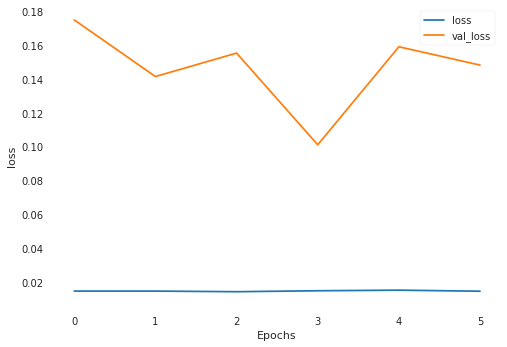

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0154 - val_loss: 0.1454
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0143 - val_loss: 0.0864
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0146 - val_loss: 0.1100
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0143 - val_loss: 0.0550
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0146 - val_loss: 0.0725
Epoch 6/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0148 - val_loss: 0.0737
Epoch 00006: early stopping
loss cuts = tf.Tensor([0.02768309], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.63415456, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02801569], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.6236045, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02525541], shape=(1,), dtype=float32)
model2

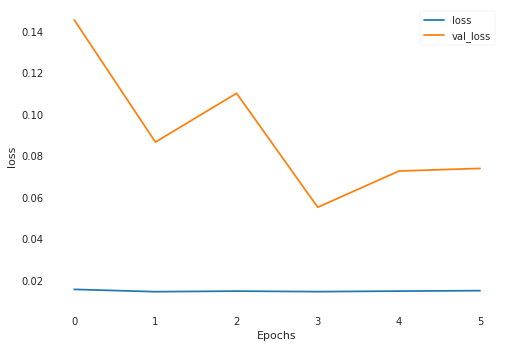

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0150 - val_loss: 0.1117
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0157 - val_loss: 0.4278
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0319 - val_loss: 0.0918
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0160 - val_loss: 0.1112
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0146 - val_loss: 0.0774
Epoch 6/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0140 - val_loss: 0.0654
Epoch 7/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0144 - val_loss: 0.0892
Epoch 8/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0147 - val_loss: 0.1129
Epoch 00008: early stopping
loss cuts = tf.Tensor([0.0163835], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.0005183583, shape=(), dt

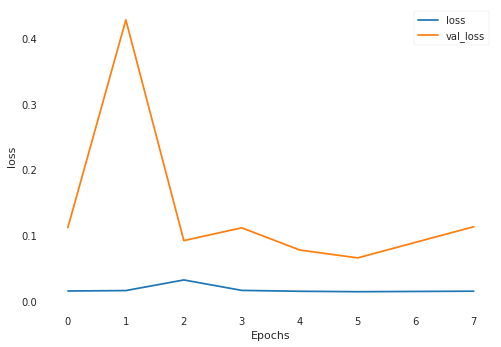

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0151 - val_loss: 0.1373
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0151 - val_loss: 0.1076
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0143 - val_loss: 0.1516
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0148 - val_loss: 0.4123
Epoch 00004: early stopping
loss cuts = tf.Tensor([0.02322423], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(2.162266, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02138345], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(2.2718933, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.01703001], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(2.5419488, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.01846374], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(2.4513361, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.0199

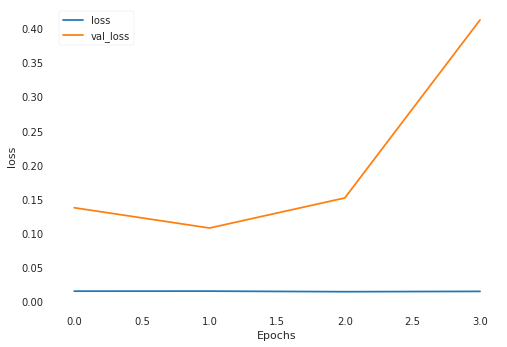

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.1252 - val_loss: 0.2057
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0455 - val_loss: 0.1421
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0275 - val_loss: 0.1413
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0223 - val_loss: 0.1232
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0194 - val_loss: 0.1469
Epoch 6/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0180 - val_loss: 0.1357
Epoch 00006: early stopping
loss cuts = tf.Tensor([0.02923485], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.012862544, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02878089], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.015004396, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02907168], shape=(1,), dtype=float32)
mod

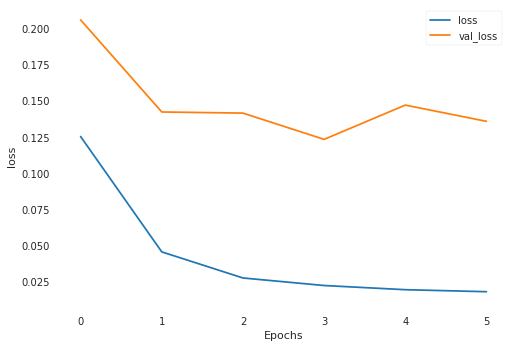

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0176 - val_loss: 0.2082
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0165 - val_loss: 0.2264
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0157 - val_loss: 0.2014
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0151 - val_loss: 0.2768
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0149 - val_loss: 0.2478
Epoch 00005: early stopping
loss cuts = tf.Tensor([0.02481398], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.3022112, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02407152], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.318758, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02181603], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.37172967, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02573749], shape=(1,), d

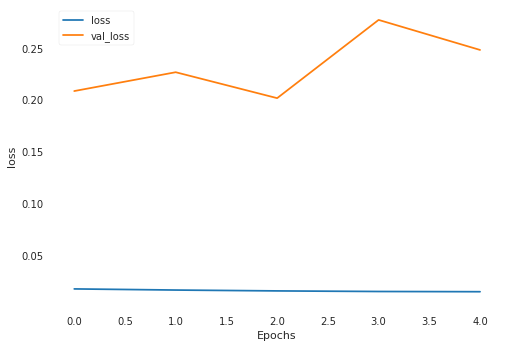

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0151 - val_loss: 0.2185
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0149 - val_loss: 0.2250
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0144 - val_loss: 0.2096
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0145 - val_loss: 0.2236
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0151 - val_loss: 0.2177
Epoch 00005: early stopping
loss cuts = tf.Tensor([0.03100801], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(12.392803, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02668275], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(13.009342, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.0228423], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(13.569318, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02614185], shape=(1,), dt

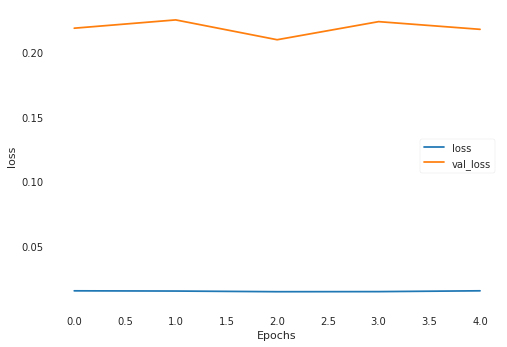

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0149 - val_loss: 0.1393
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0147 - val_loss: 0.0980
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0146 - val_loss: 0.1098
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0145 - val_loss: 0.0838
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0141 - val_loss: 0.0703
Epoch 6/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0142 - val_loss: 0.0617
Epoch 7/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0141 - val_loss: 0.0668
Epoch 8/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0146 - val_loss: 0.0810
Epoch 00008: early stopping
loss cuts = tf.Tensor([0.01687301], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(1.5245812, shape=(), dtyp

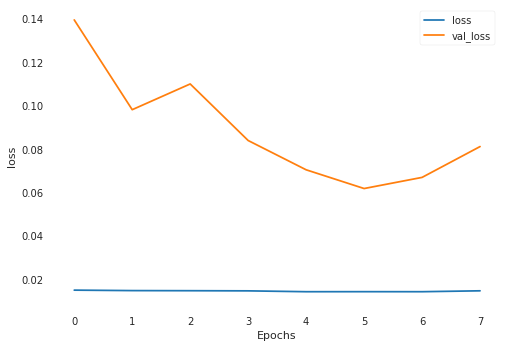

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0148 - val_loss: 0.0749
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0147 - val_loss: 0.0667
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0143 - val_loss: 0.0994
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0148 - val_loss: 0.0934
Epoch 00004: early stopping
loss cuts = tf.Tensor([0.01037832], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.11726073, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.01046957], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.11601428, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.01024669], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.11907074, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.00949264], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.129706, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.0

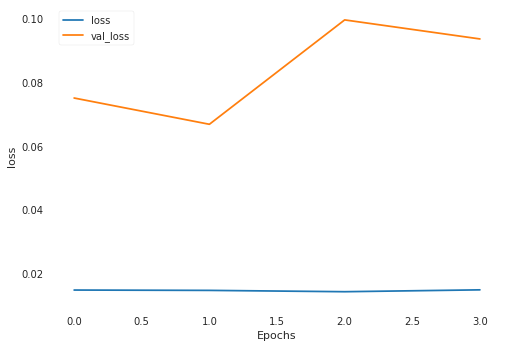

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0148 - val_loss: 0.0847
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0141 - val_loss: 0.0543
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0143 - val_loss: 0.0953
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0146 - val_loss: 0.0845
Epoch 00004: early stopping
loss cuts = tf.Tensor([0.03534842], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(1.7456268, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.04222245], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(1.4012432, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.0286577], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(2.1171298, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02510811], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(2.328761, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02506

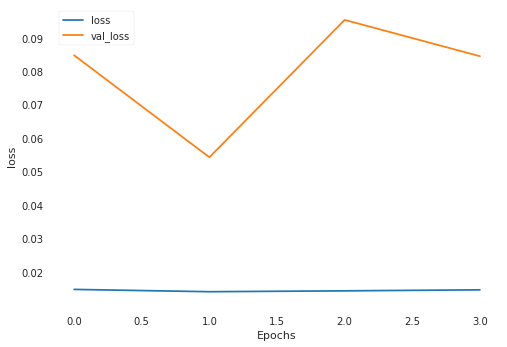

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0167 - val_loss: 0.0525
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0149 - val_loss: 0.0210
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0141 - val_loss: 0.0274
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0140 - val_loss: 0.0322
Epoch 00004: early stopping
loss cuts = tf.Tensor([0.0315934], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.17483433, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03131114], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.17958708, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03472172], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.12642677, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03570868], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.11277933, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.

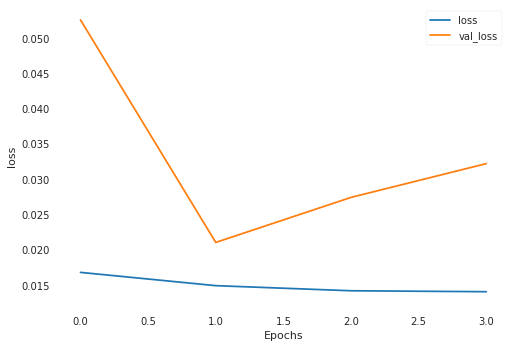

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0141 - val_loss: 0.0801
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0138 - val_loss: 0.0836
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0141 - val_loss: 0.0875
Epoch 00003: early stopping
loss cuts = tf.Tensor([0.01896095], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.5776777, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.01625668], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.6628181, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.01704423], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.6374193, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.01712568], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.634821, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.01602944], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.670239, shape=(), dtype=float32)
loss cuts

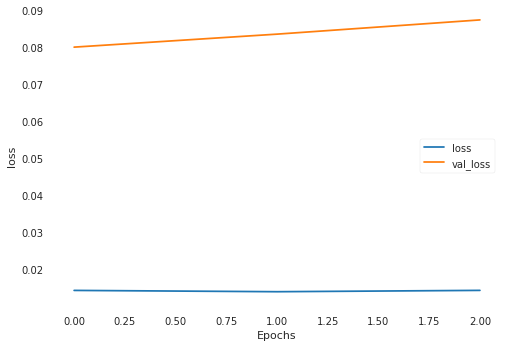

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0147 - val_loss: 0.2243
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0143 - val_loss: 0.1771
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0141 - val_loss: 0.2172
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0142 - val_loss: 0.2215
Epoch 00004: early stopping
loss cuts = tf.Tensor([0.02313055], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(25.484272, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.01823696], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(26.482002, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.01744462], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(26.64535, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.01857432], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(26.412603, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.0198

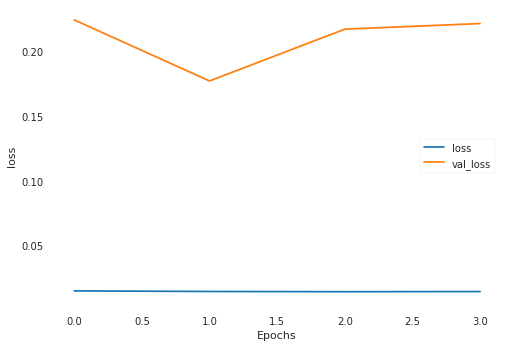

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0146 - val_loss: 0.1421
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0148 - val_loss: 0.1675
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0154 - val_loss: 0.1294
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0144 - val_loss: 0.1045
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0143 - val_loss: 0.0981
Epoch 6/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0143 - val_loss: 0.0750
Epoch 7/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0145 - val_loss: 0.0563
Epoch 8/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0147 - val_loss: 0.0660
Epoch 9/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0142 - val_loss: 0.0821
Epoch 00009: early stopping
loss cuts 

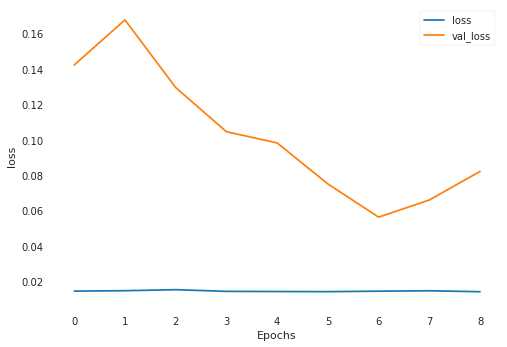

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0143 - val_loss: 0.0654
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0146 - val_loss: 0.0470
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0143 - val_loss: 0.0542
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0145 - val_loss: 0.0842
Epoch 00004: early stopping
loss cuts = tf.Tensor([0.0419582], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(1.3747225, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03856194], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(1.5386189, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.04187461], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(1.3786458, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03743229], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(1.5951787, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.0329

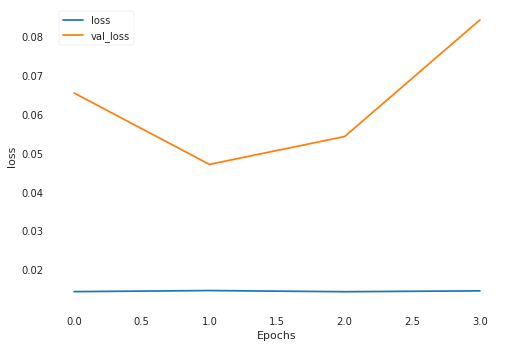

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0152 - val_loss: 0.2005
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0209 - val_loss: 0.0844
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0141 - val_loss: 0.0299
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0205 - val_loss: 0.0391
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0141 - val_loss: 0.0398
Epoch 00005: early stopping
loss cuts = tf.Tensor([0.01660601], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(18.644085, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.01383156], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(19.126354, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.01286103], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(19.29651, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.01528019], shape=(1,), dt

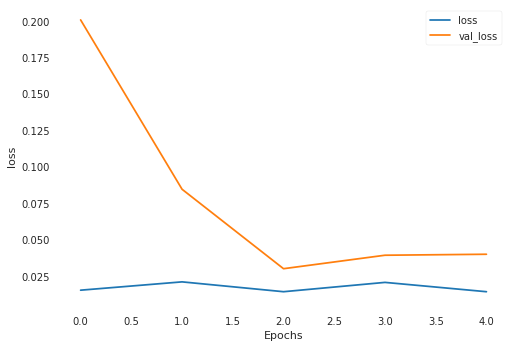

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0136 - val_loss: 0.0275
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0139 - val_loss: 0.0407
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0141 - val_loss: 0.0203
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0137 - val_loss: 0.0222
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0135 - val_loss: 0.0242
Epoch 00005: early stopping
loss cuts = tf.Tensor([0.03858016], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.2792031, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.0433203], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.18800369, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.0433213], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.18798637, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03686018], shape=(1,), d

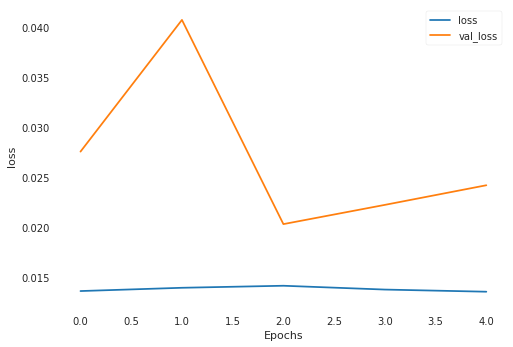

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0138 - val_loss: 0.1792
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0136 - val_loss: 0.1406
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0139 - val_loss: 0.1486
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0135 - val_loss: 0.1254
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0136 - val_loss: 0.2334
Epoch 6/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0144 - val_loss: 0.1631
Epoch 00006: early stopping
loss cuts = tf.Tensor([0.03171115], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(4.2173734, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03058211], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(4.3106284, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03218929], shape=(1,), dtype=float32)
model2 

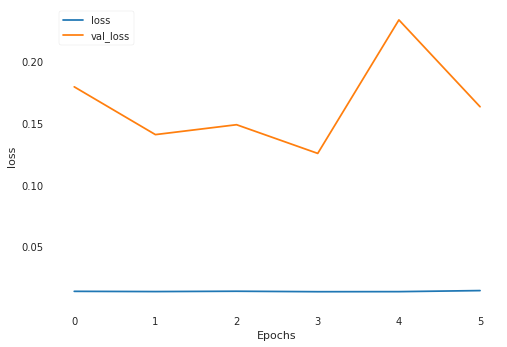

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0205 - val_loss: 0.2318
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0156 - val_loss: 0.1119
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0136 - val_loss: 0.0865
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0133 - val_loss: 0.1201
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0134 - val_loss: 0.0897
Epoch 00005: early stopping
loss cuts = tf.Tensor([0.02647068], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.31614286, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02746059], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.29427123, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02633931], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.31910425, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02425596], shape=(1,)

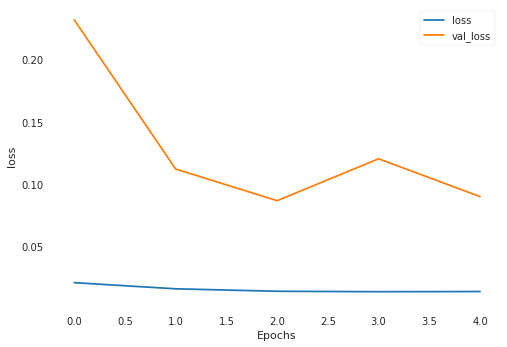

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0136 - val_loss: 0.0681
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0139 - val_loss: 0.1145
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0130 - val_loss: 0.0769
Epoch 00003: early stopping
loss cuts = tf.Tensor([0.04508381], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.30240667, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.04602561], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.32347775, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.04857817], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.3841549, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.0398405], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.1980685, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03650193], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.14309385, shape=(), dtype=float32)
loss 

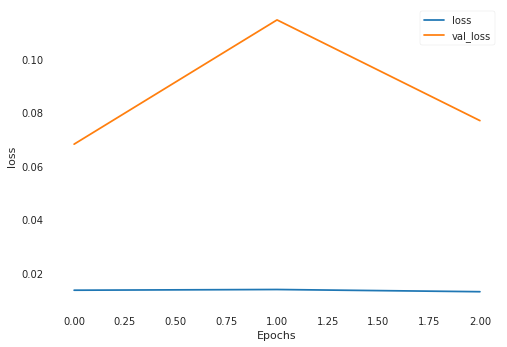

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0134 - val_loss: 0.1128
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0169 - val_loss: 0.1056
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0156 - val_loss: 0.0547
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0136 - val_loss: 0.0561
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0131 - val_loss: 0.0674
Epoch 00005: early stopping
loss cuts = tf.Tensor([0.02667402], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.16755043, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02641126], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.17188013, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02680226], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.16545722, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02377862], shape=(1,)

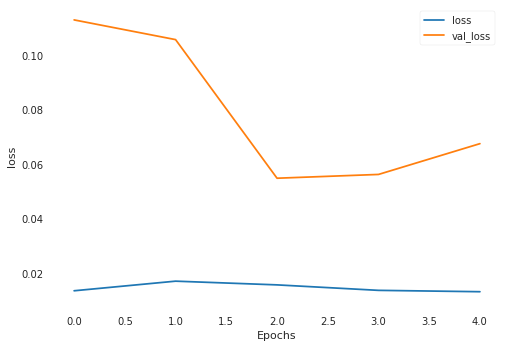

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0133 - val_loss: 0.0702
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0138 - val_loss: 0.0568
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0135 - val_loss: 0.0427
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0132 - val_loss: 0.0709
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0130 - val_loss: 0.0397
Epoch 6/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0131 - val_loss: 0.0354
Epoch 7/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0148 - val_loss: 0.0617
Epoch 8/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0137 - val_loss: 0.0562
Epoch 00008: early stopping
loss cuts = tf.Tensor([0.01663098], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.0028611848, shape=(), d

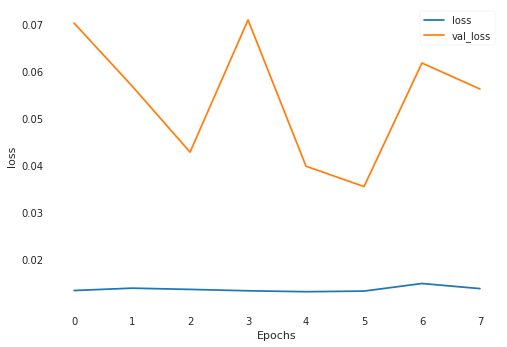

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0139 - val_loss: 0.1440
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0141 - val_loss: 0.0710
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0128 - val_loss: 0.0464
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0130 - val_loss: 0.0601
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0134 - val_loss: 0.0547
Epoch 00005: early stopping
loss cuts = tf.Tensor([0.02184609], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.0001710412, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02005509], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.00239103, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02195092], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.00012059727, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02215062], shape

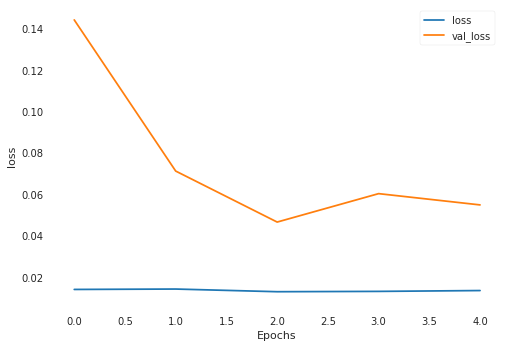

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0134 - val_loss: 0.0624
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0129 - val_loss: 0.0620
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0152 - val_loss: 0.0742
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0128 - val_loss: 0.0744
Epoch 00004: early stopping
loss cuts = tf.Tensor([0.02572791], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.104443744, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02665209], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.09283843, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02895755], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.0668661, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02963614], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.0600314, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.

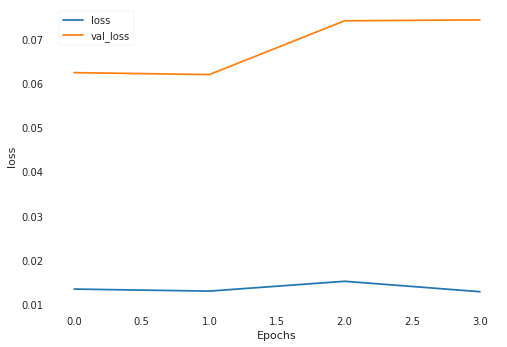

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0133 - val_loss: 0.1086
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0131 - val_loss: 0.0990
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0129 - val_loss: 0.0744
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0133 - val_loss: 0.0829
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0131 - val_loss: 0.0989
Epoch 00005: early stopping
loss cuts = tf.Tensor([0.03344911], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.1258216, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.0335114], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.12670696, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.0374533], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.1890485, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03480759], shape=(1,), dt

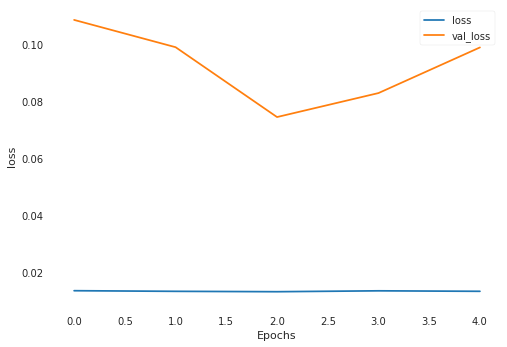

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0136 - val_loss: 0.0860
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0130 - val_loss: 0.0724
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0138 - val_loss: 0.0681
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0129 - val_loss: 0.0658
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0128 - val_loss: 0.0832
Epoch 6/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0133 - val_loss: 0.0665
Epoch 00006: early stopping
loss cuts = tf.Tensor([0.03542705], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.0849484, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03264089], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.12053545, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03948723], shape=(1,), dtype=float32)
model2

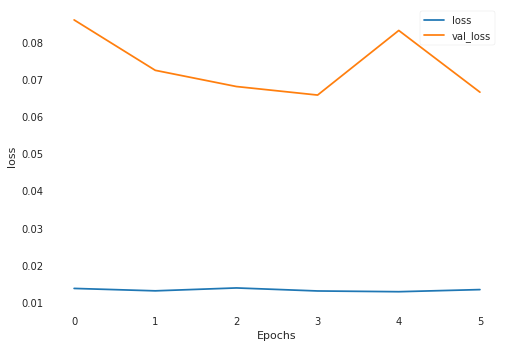

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0129 - val_loss: 0.1580
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0131 - val_loss: 0.1920
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0132 - val_loss: 0.1277
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0134 - val_loss: 0.0746
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0128 - val_loss: 0.1238
Epoch 6/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0128 - val_loss: 0.1466
Epoch 00006: early stopping
loss cuts = tf.Tensor([0.01968051], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(5.0946217, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02207655], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(4.8805904, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.01798664], shape=(1,), dtype=float32)
model2 

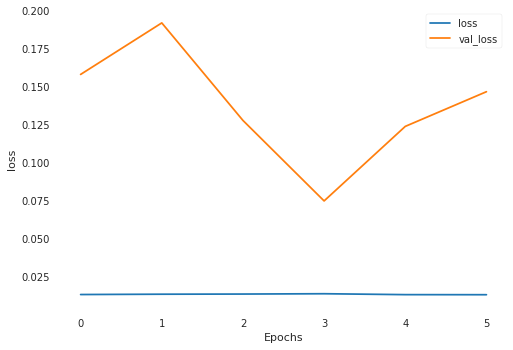

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0138 - val_loss: 0.0711
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0130 - val_loss: 0.1221
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0125 - val_loss: 0.1403
Epoch 00003: early stopping
loss cuts = tf.Tensor([0.04550325], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(1.7945575, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.04619116], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(1.7578858, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.05493203], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(1.3248823, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.05830043], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(1.174335, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.06379632], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.94818836, shape=(), dtype=float32)
loss cu

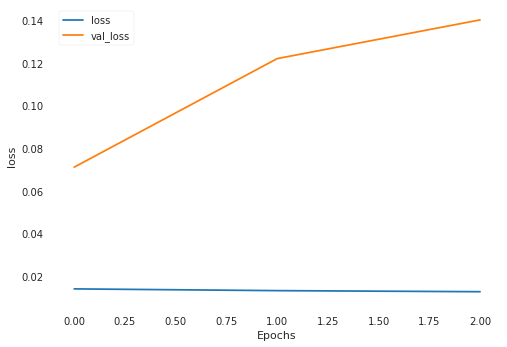

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0131 - val_loss: 0.0818
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0132 - val_loss: 0.0663
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0131 - val_loss: 0.0562
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0126 - val_loss: 0.0498
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0281 - val_loss: 0.2509
Epoch 6/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0190 - val_loss: 0.1364
Epoch 00006: early stopping
loss cuts = tf.Tensor([0.01542854], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(3.3908615, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.01580704], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(3.36304, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.01642193], shape=(1,), dtype=float32)
model2 lo

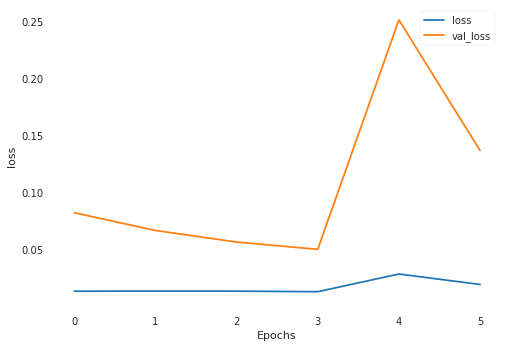

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0142 - val_loss: 0.0731
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0134 - val_loss: 0.1293
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0125 - val_loss: 0.0453
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0122 - val_loss: 0.0461
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0125 - val_loss: 0.0376
Epoch 6/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0122 - val_loss: 0.0347
Epoch 7/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0121 - val_loss: 0.0435
Epoch 8/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0121 - val_loss: 0.0335
Epoch 9/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0125 - val_loss: 0.0442
Epoch 10/10
880/880 [=================

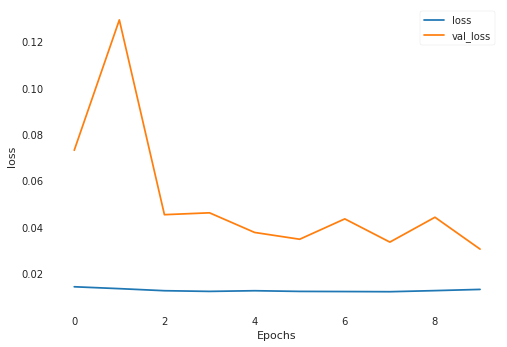

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0128 - val_loss: 0.0747
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0124 - val_loss: 0.0878
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0126 - val_loss: 0.1038
Epoch 00003: early stopping
loss cuts = tf.Tensor([0.02782178], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.02041913, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.0259535], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.032494057, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02841578], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.017165024, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03553669], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.00013002352, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03526402], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(3.539368e-05, shape=(), dtype=float

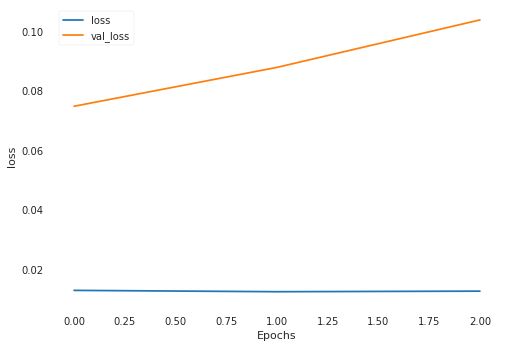

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0123 - val_loss: 0.0408
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0124 - val_loss: 0.0490
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0134 - val_loss: 0.0501
Epoch 00003: early stopping
loss cuts = tf.Tensor([0.04418129], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(2.150253, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.04363672], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(2.1823132, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.04709431], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(1.9827843, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.04728778], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(1.9719018, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.04303709], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(2.2178895, shape=(), dtype=float32)
loss cut

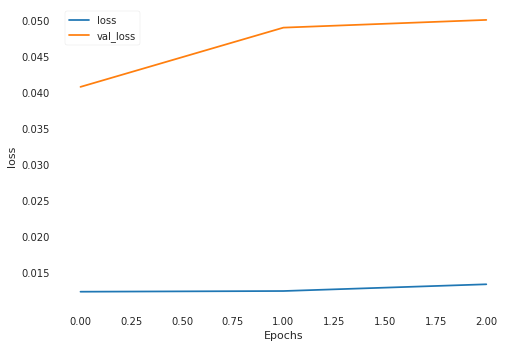

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0125 - val_loss: 0.0609
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0126 - val_loss: 0.0732
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0121 - val_loss: 0.0655
Epoch 00003: early stopping
loss cuts = tf.Tensor([0.04209756], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(1.3410769, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03836071], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(1.5197608, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03647263], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(1.6142907, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.04049807], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(1.4161915, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.04583217], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(1.1736616, shape=(), dtype=float32)
loss cu

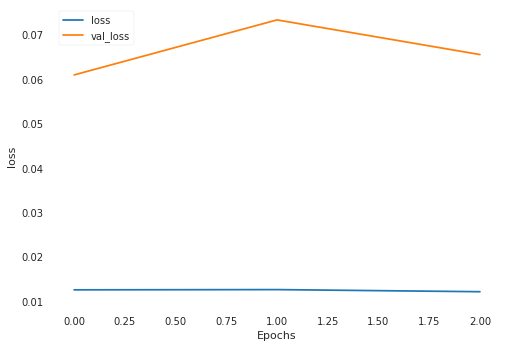

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0122 - val_loss: 0.1076
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0129 - val_loss: 0.1081
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0136 - val_loss: 0.1170
Epoch 00003: early stopping
loss cuts = tf.Tensor([0.04651527], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(3.8524792, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.05168467], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(3.4573145, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.0545259], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(3.2492254, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.04672734], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(3.8358479, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.04856355], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(3.693345, shape=(), dtype=float32)
loss cuts

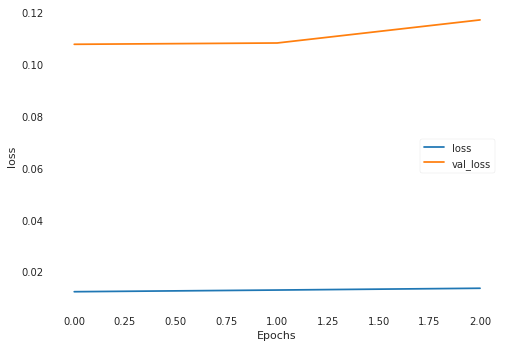

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0136 - val_loss: 0.0837
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0122 - val_loss: 0.0584
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0127 - val_loss: 0.0731
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0121 - val_loss: 0.0770
Epoch 00004: early stopping
loss cuts = tf.Tensor([0.05226901], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.41651553, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.05341694], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.44667673, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.05161928], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.39991155, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.04435078], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.23718429, shape=(), dtype=float32)
loss cuts = tf.Tensor([0

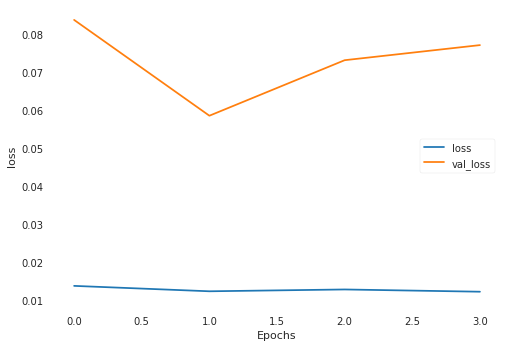

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0128 - val_loss: 0.1187
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0130 - val_loss: 0.0816
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0120 - val_loss: 0.0466
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0285 - val_loss: 0.9084
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.1607 - val_loss: 0.2731
Epoch 00005: early stopping
loss cuts = tf.Tensor([0.04580865], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.00026156995, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03526003], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.03794684, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03498417], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.04012672, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03786028], shape=(

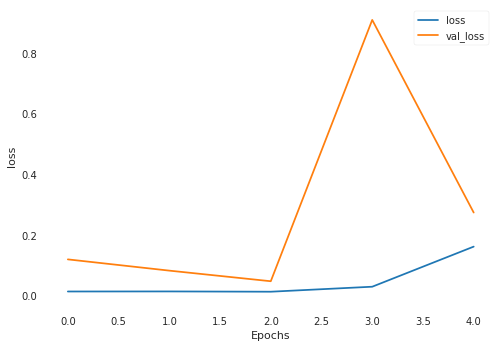

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0372 - val_loss: 0.2016
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0237 - val_loss: 0.1350
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0188 - val_loss: 0.1197
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0162 - val_loss: 0.1084
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0149 - val_loss: 0.0932
Epoch 6/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0143 - val_loss: 0.0853
Epoch 7/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0130 - val_loss: 0.0908
Epoch 8/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0127 - val_loss: 0.0784
Epoch 9/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0127 - val_loss: 0.0806
Epoch 10/10
880/880 [=================

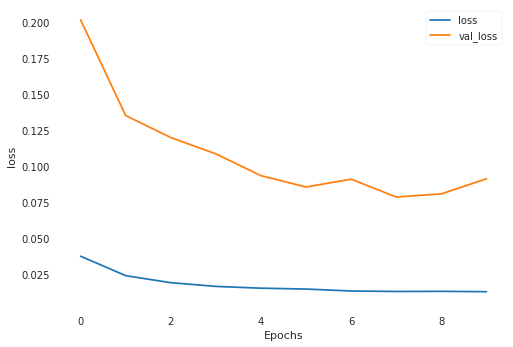

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0122 - val_loss: 0.0448
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0122 - val_loss: 0.0313
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0115 - val_loss: 0.0387
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0118 - val_loss: 0.0423
Epoch 00004: early stopping
loss cuts = tf.Tensor([0.05086366], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.59576476, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.05075716], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.59248114, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.05420375], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.7033504, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.05819743], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.8437037, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.0

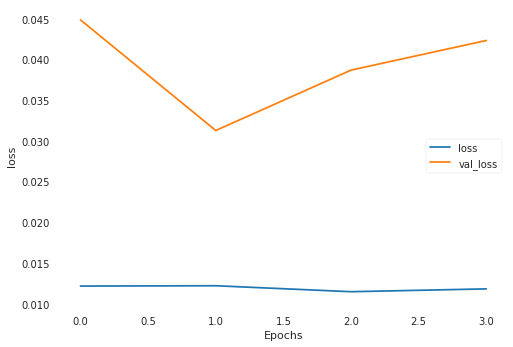

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0116 - val_loss: 0.0753
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0120 - val_loss: 0.0681
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0116 - val_loss: 0.0735
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0114 - val_loss: 0.0687
Epoch 00004: early stopping
loss cuts = tf.Tensor([0.03304992], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.20357762, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03620053], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.26440984, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03559266], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.25205484, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03324482], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.20711038, shape=(), dtype=float32)
loss cuts = tf.Tensor([0

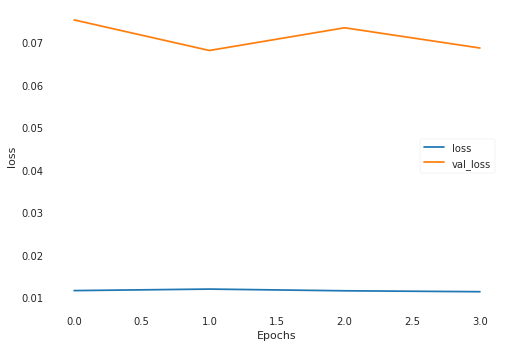

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0116 - val_loss: 0.1001
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0114 - val_loss: 0.0987
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0116 - val_loss: 0.1047
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0113 - val_loss: 0.0949
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0118 - val_loss: 0.1115
Epoch 6/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0115 - val_loss: 0.0798
Epoch 7/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0120 - val_loss: 0.0979
Epoch 8/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0119 - val_loss: 0.1150
Epoch 00008: early stopping
loss cuts = tf.Tensor([0.05623164], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.021670733, shape=(), dt

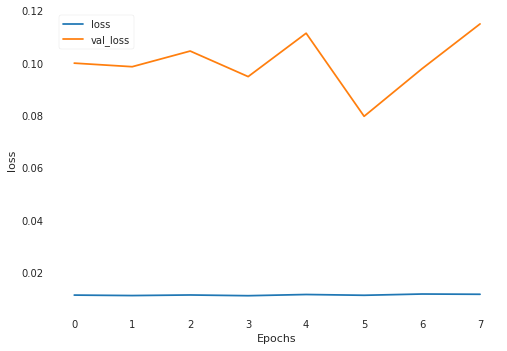

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0127 - val_loss: 0.0436
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0119 - val_loss: 0.0733
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0118 - val_loss: 0.0625
Epoch 00003: early stopping
loss cuts = tf.Tensor([0.05769099], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.36459833, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.05025669], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.20714682, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.05258958], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.25179487, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.05458579], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.29345602, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.05385641], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.2778641, shape=(), dtype=float32)
los

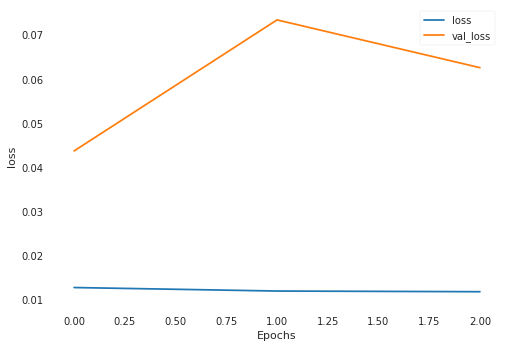

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0115 - val_loss: 0.0645
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0117 - val_loss: 0.0524
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0118 - val_loss: 0.0550
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0115 - val_loss: 0.1107
Epoch 00004: early stopping
loss cuts = tf.Tensor([0.07602417], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.5936446, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.07254227], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.49118406, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.06989963], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.41989428, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.07074822], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.4421777, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.0

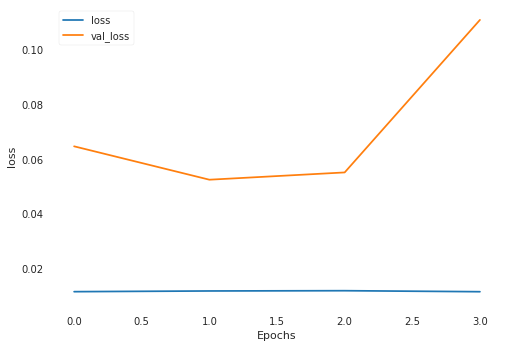

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0238 - val_loss: 0.1913
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0174 - val_loss: 0.0626
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0120 - val_loss: 0.0408
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0113 - val_loss: 0.0464
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0112 - val_loss: 0.0360
Epoch 6/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0111 - val_loss: 0.0450
Epoch 7/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0112 - val_loss: 0.0655
Epoch 00007: early stopping
loss cuts = tf.Tensor([0.03888036], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.27836943, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.04000886], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.3

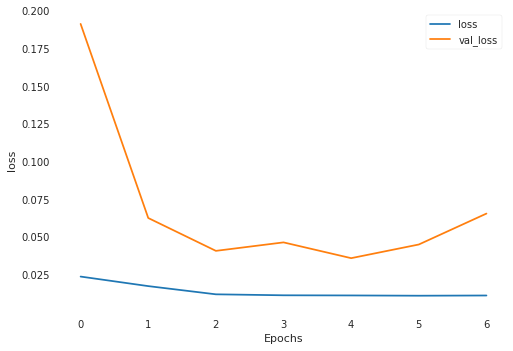

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0113 - val_loss: 0.1156
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0116 - val_loss: 0.2838
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0114 - val_loss: 0.2783
Epoch 00003: early stopping
loss cuts = tf.Tensor([0.03403754], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.4634217, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03507841], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.49219793, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03500076], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.49002144, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03573653], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.51083994, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03852098], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.59354633, shape=(), dtype=float32)
los

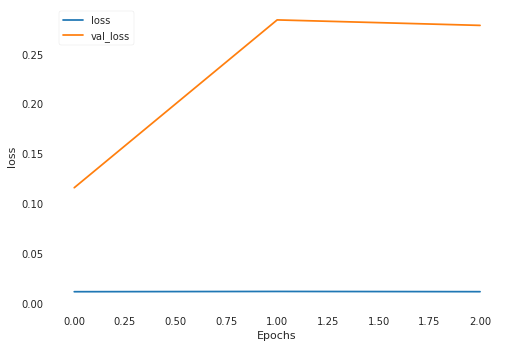

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0120 - val_loss: 0.2395
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0189 - val_loss: 0.2308
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0127 - val_loss: 0.2627
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0117 - val_loss: 0.1582
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0145 - val_loss: 0.0842
Epoch 6/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0116 - val_loss: 0.0867
Epoch 7/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0116 - val_loss: 0.0605
Epoch 8/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0112 - val_loss: 0.0656
Epoch 9/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0115 - val_loss: 0.0821
Epoch 00009: early stopping
loss cuts 

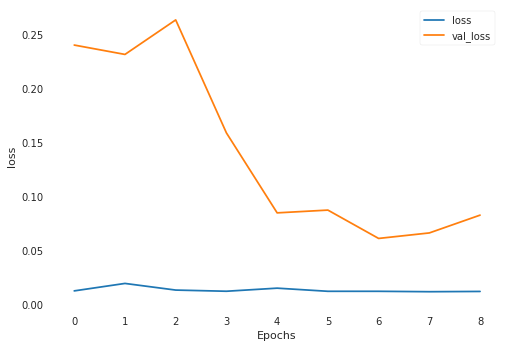

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0160 - val_loss: 0.0653
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0131 - val_loss: 0.0744
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0121 - val_loss: 0.1270
Epoch 00003: early stopping
loss cuts = tf.Tensor([0.01590706], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.028271439, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.01688053], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.03519777, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.0177252], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.041821904, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.0183352], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.046960667, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.01727556], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.038224604, shape=(), dtype=float32)


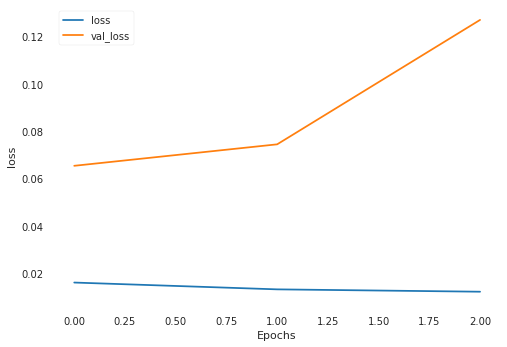

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0118 - val_loss: 0.0497
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0118 - val_loss: 0.0854
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0116 - val_loss: 0.1220
Epoch 00003: early stopping
loss cuts = tf.Tensor([0.0414595], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.01669008, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.042672], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.023543851, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.04172333], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.018081248, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.04354896], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.029233867, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.04373412], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.030513933, shape=(), dtype=float32)
l

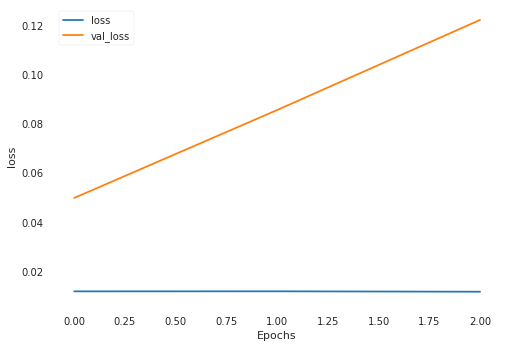

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0118 - val_loss: 0.1228
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0116 - val_loss: 0.0651
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0223 - val_loss: 0.1218
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0643 - val_loss: 0.1917
Epoch 00004: early stopping
loss cuts = tf.Tensor([0.02675924], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.00021949048, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02234076], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.0106471, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02412186], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.0045647346, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02558035], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.0014740195, shape=(), dtype=float32)
loss cuts = tf.Ten

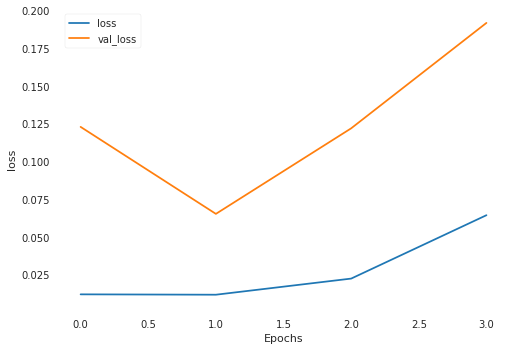

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0185 - val_loss: 0.0912
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0142 - val_loss: 0.1322
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0121 - val_loss: 0.1188
Epoch 00003: early stopping
loss cuts = tf.Tensor([0.01172346], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.007135051, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.0123443], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.009386876, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.01356624], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.014719701, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.01222868], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.008944174, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.01234432], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.009386988, shape=(), dtype=float32

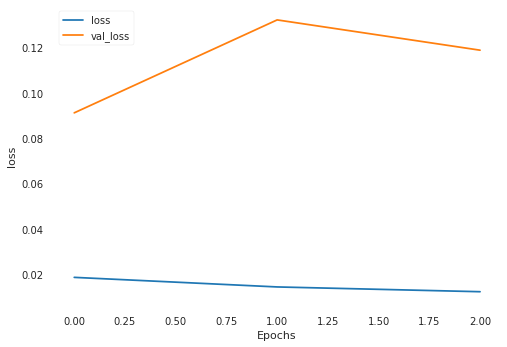

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0122 - val_loss: 0.1521
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0119 - val_loss: 0.1456
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0258 - val_loss: 0.1061
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0120 - val_loss: 0.0876
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0111 - val_loss: 0.1023
Epoch 6/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0115 - val_loss: 0.1209
Epoch 00006: early stopping
loss cuts = tf.Tensor([0.02626221], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.05718619, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02586145], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.06108392, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02665355], shape=(1,), dtype=float32)
model

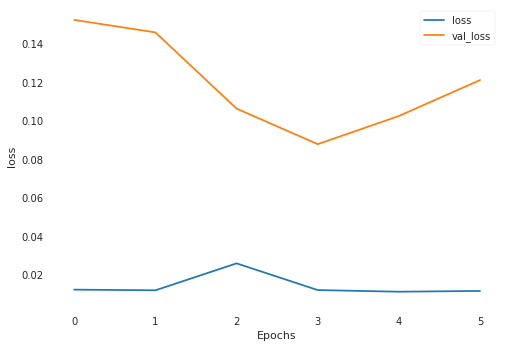

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0110 - val_loss: 0.1015
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0113 - val_loss: 0.1341
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0118 - val_loss: 0.1021
Epoch 00003: early stopping
loss cuts = tf.Tensor([0.04369113], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(3.6904266, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.04935003], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(3.268395, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.0458461], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(3.5266914, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.04457663], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(3.6226966, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.04911575], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(3.2853584, shape=(), dtype=float32)
loss cuts

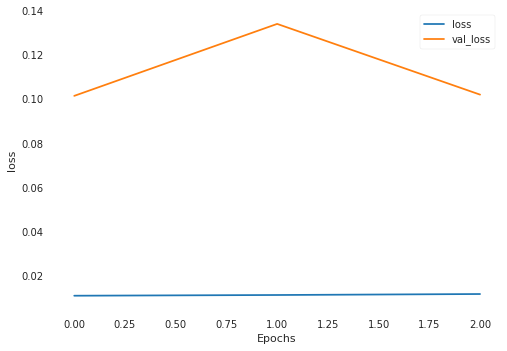

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0114 - val_loss: 0.1183
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0113 - val_loss: 0.0914
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0113 - val_loss: 0.1025
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0113 - val_loss: 0.0923
Epoch 00004: early stopping
loss cuts = tf.Tensor([0.04626485], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.030729003, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.05080349], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.07079312, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.04560153], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.026253909, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.04590698], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.028270958, shape=(), dtype=float32)
loss cuts = tf.Tensor

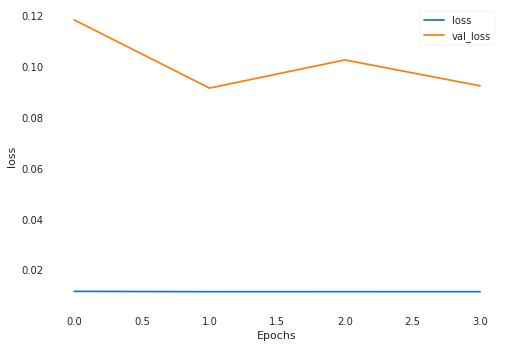

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0114 - val_loss: 0.0897
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0113 - val_loss: 0.0725
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0111 - val_loss: 0.0661
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0115 - val_loss: 0.0650
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0114 - val_loss: 0.0726
Epoch 6/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0114 - val_loss: 0.0698
Epoch 00006: early stopping
loss cuts = tf.Tensor([0.02813371], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.005334129, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02613384], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.0010914911, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02309904], shape=(1,), dtype=float32)
mo

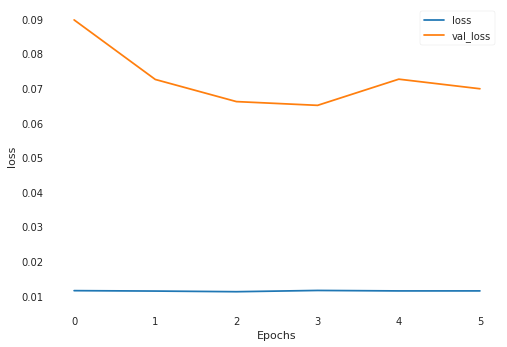

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0114 - val_loss: 0.1033
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0111 - val_loss: 0.1435
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0115 - val_loss: 0.1239
Epoch 00003: early stopping
loss cuts = tf.Tensor([0.02590875], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.13555282, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02150211], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.078423634, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.01951062], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.057701975, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.01931801], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.05586611, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02072173], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.069925696, shape=(), dtype=float32)

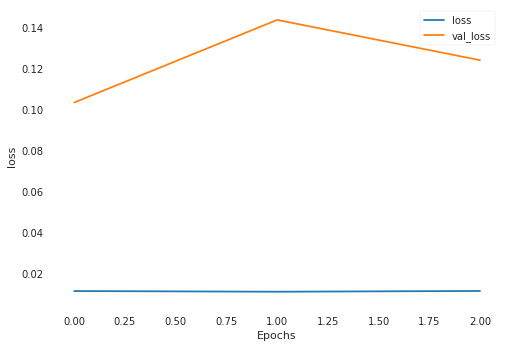

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0117 - val_loss: 0.2712
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0114 - val_loss: 0.1325
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0113 - val_loss: 0.1057
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0125 - val_loss: 0.1727
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0323 - val_loss: 0.1137
Epoch 00005: early stopping
loss cuts = tf.Tensor([0.02269603], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.15102077, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02324509], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.14260639, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02105827], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.17755195, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.01925808], shape=(1,)

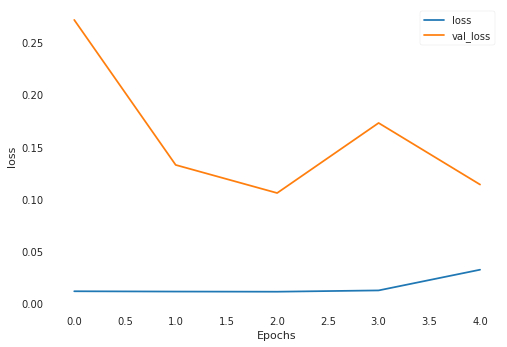

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0131 - val_loss: 0.1150
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0115 - val_loss: 0.0953
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0115 - val_loss: 0.0975
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0111 - val_loss: 0.1013
Epoch 00004: early stopping
loss cuts = tf.Tensor([0.02538233], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.03699984, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02189028], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.06874589, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02199594], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.06764225, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02238101], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.063695565, shape=(), dtype=float32)
loss cuts = tf.Tensor([

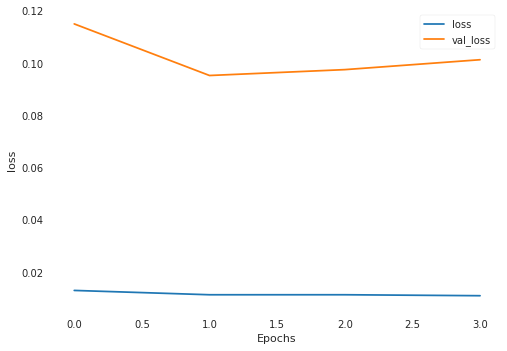

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0110 - val_loss: 0.1115
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0111 - val_loss: 0.1106
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0123 - val_loss: 0.1079
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0123 - val_loss: 0.1388
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0123 - val_loss: 0.1160
Epoch 00005: early stopping
loss cuts = tf.Tensor([0.03581366], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.5130473, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03439325], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.47315827, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03909606], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.61140084, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03947112], shape=(1,),

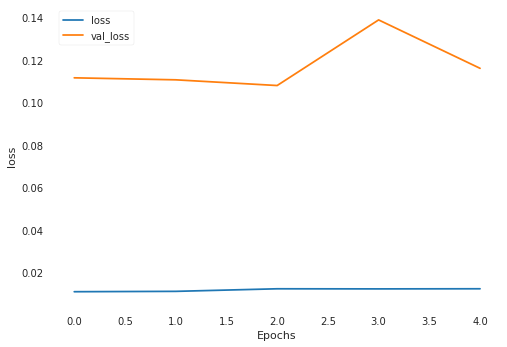

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0120 - val_loss: 0.0398
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0117 - val_loss: 0.0841
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0112 - val_loss: 0.0520
Epoch 00003: early stopping
loss cuts = tf.Tensor([0.02634614], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.17899434, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02433692], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.21461129, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02325757], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.23507819, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02168985], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.26646557, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02265171], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.2469751, shape=(), dtype=float32)
los

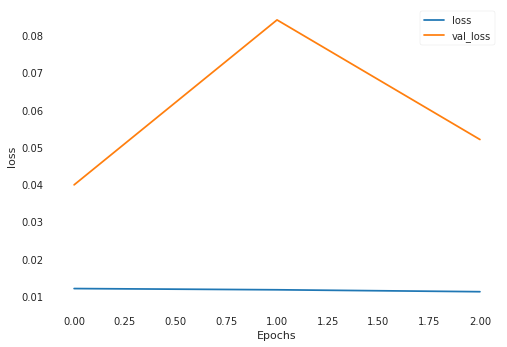

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0115 - val_loss: 0.0883
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0133 - val_loss: 0.0563
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0112 - val_loss: 0.0864
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0122 - val_loss: 0.0855
Epoch 00004: early stopping
loss cuts = tf.Tensor([0.03334678], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.110931955, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03712374], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.0663192, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03424444], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.09929512, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03635949], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.074425414, shape=(), dtype=float32)
loss cuts = tf.Tensor([

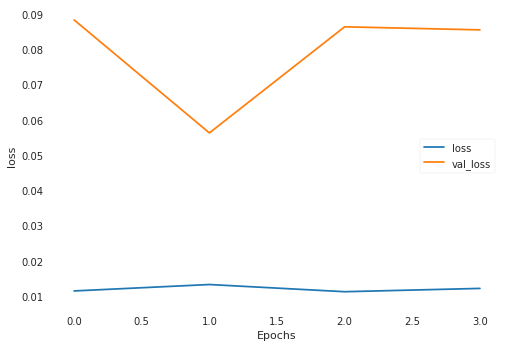

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0119 - val_loss: 0.0720
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0119 - val_loss: 0.0776
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0118 - val_loss: 0.0590
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0116 - val_loss: 0.0644
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0110 - val_loss: 0.0525
Epoch 6/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0114 - val_loss: 0.0693
Epoch 7/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0117 - val_loss: 0.0616
Epoch 00007: early stopping
loss cuts = tf.Tensor([0.03022288], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.009128356, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02726954], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.

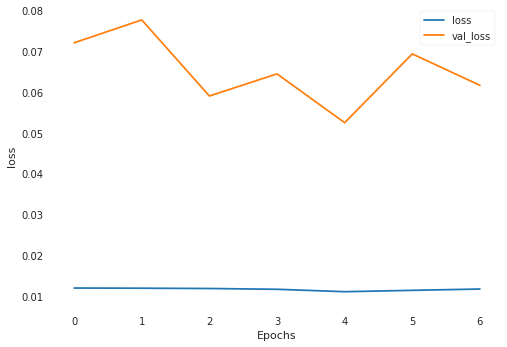

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0114 - val_loss: 0.1073
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0120 - val_loss: 0.1044
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0123 - val_loss: 0.0476
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0185 - val_loss: 0.0545
Epoch 5/10
880/880 [==============================] - 1s 2ms/sample - loss: 0.0111 - val_loss: 0.0587
Epoch 00005: early stopping
loss cuts = tf.Tensor([0.01516618], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.010675753, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.01523218], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.01095027, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.01710929], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.020216817, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.0165422], shape=(1,

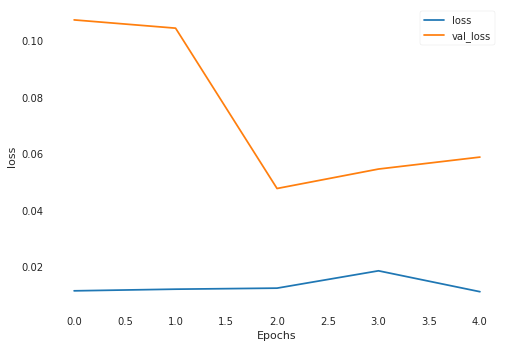

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0109 - val_loss: 0.0721
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0111 - val_loss: 0.0647
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0110 - val_loss: 0.0629
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0115 - val_loss: 0.0703
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0117 - val_loss: 0.0810
Epoch 00005: early stopping
loss cuts = tf.Tensor([0.03118432], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.18174326, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03468969], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.12688284, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03564956], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.11357495, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03887113], shape=(1,)

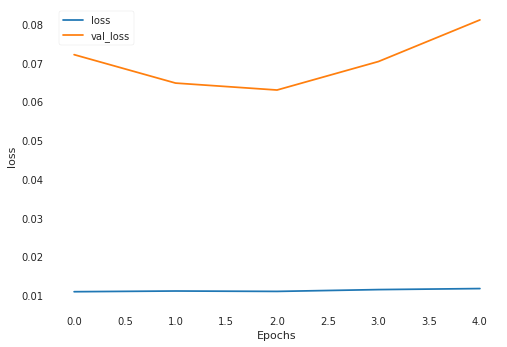

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0113 - val_loss: 0.1200
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0113 - val_loss: 0.1136
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0110 - val_loss: 0.1244
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0116 - val_loss: 0.1368
Epoch 00004: early stopping
loss cuts = tf.Tensor([0.03030373], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(5.0560446, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02897286], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(5.176454, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02606807], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(5.444187, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03065845], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(5.0241904, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02873

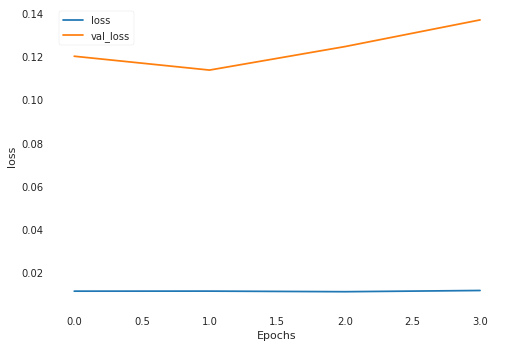

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0121 - val_loss: 0.1290
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0115 - val_loss: 0.0977
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0125 - val_loss: 0.1229
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0116 - val_loss: 0.0789
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0116 - val_loss: 0.0906
Epoch 6/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0118 - val_loss: 0.1376
Epoch 00006: early stopping
loss cuts = tf.Tensor([0.01683833], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.113411725, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.01577598], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.0995526, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.01878533], shape=(1,), dtype=float32)
model

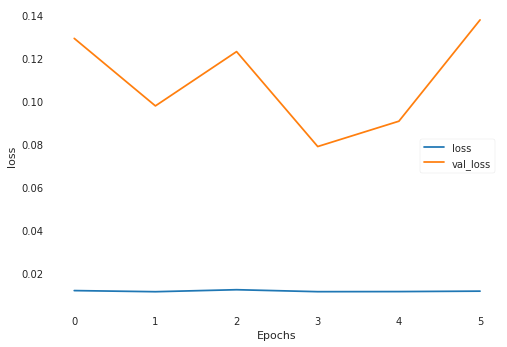

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0117 - val_loss: 0.0787
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0123 - val_loss: 0.0704
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0112 - val_loss: 0.1069
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0117 - val_loss: 0.0833
Epoch 00004: early stopping
loss cuts = tf.Tensor([0.01753266], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.009869802, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.01571027], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.018440168, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.01605594], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.016610345, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.01779872], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.0088408105, shape=(), dtype=float32)
loss cuts = tf.Tens

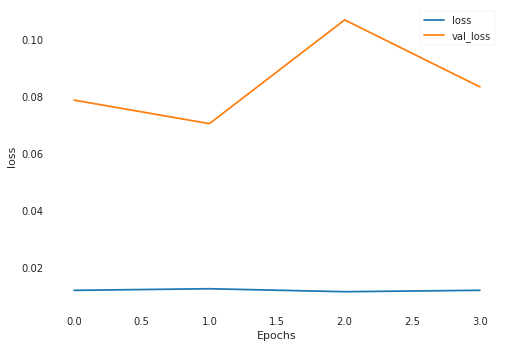

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0113 - val_loss: 0.0493
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0114 - val_loss: 0.0581
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0119 - val_loss: 0.0525
Epoch 00003: early stopping
loss cuts = tf.Tensor([0.02324131], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.40344575, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02551369], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.34777713, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02211444], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.43258396, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02046034], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.47719535, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02124912], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.45564875, shape=(), dtype=float32)
lo

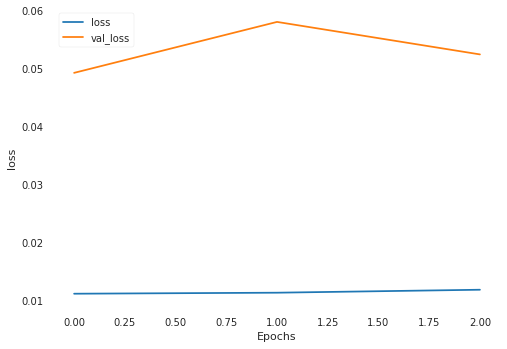

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0160 - val_loss: 0.0812
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0120 - val_loss: 0.0711
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0111 - val_loss: 0.0609
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0113 - val_loss: 0.0659
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0115 - val_loss: 0.2330
Epoch 00005: early stopping
loss cuts = tf.Tensor([0.01832393], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.036428627, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.01778163], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.03240607, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.01834604], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.036597647, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.01744892], shape=(1

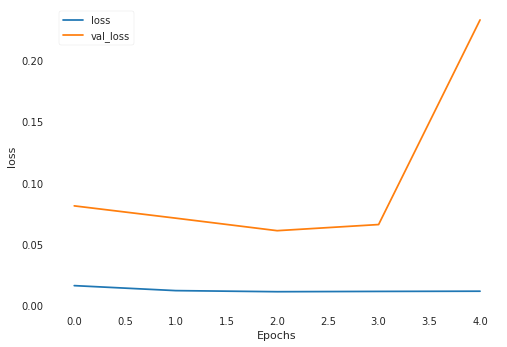

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0121 - val_loss: 0.0798
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0113 - val_loss: 0.0530
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0112 - val_loss: 0.0510
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0112 - val_loss: 0.0592
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0111 - val_loss: 0.0595
Epoch 00005: early stopping
loss cuts = tf.Tensor([0.02942585], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.07857926, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02861586], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.08792397, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02843062], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.09013474, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02791403], shape=(1,)

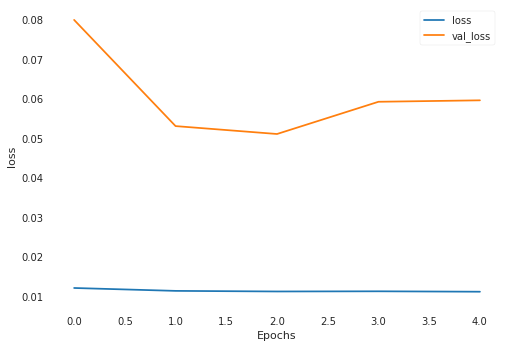

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0111 - val_loss: 0.1317
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0119 - val_loss: 0.1007
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0107 - val_loss: 0.0755
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0121 - val_loss: 0.0977
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0107 - val_loss: 0.0999
Epoch 00005: early stopping
loss cuts = tf.Tensor([0.0242203], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(5.835728, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02611556], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(5.654028, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02534048], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(5.727988, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02306312], shape=(1,), dtype

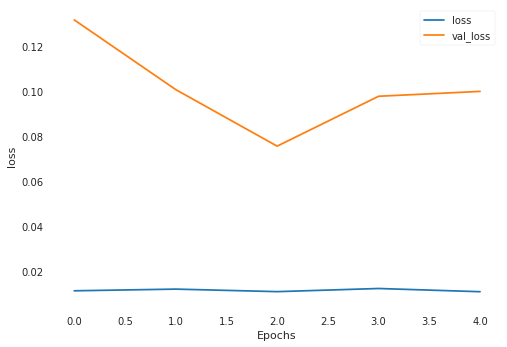

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0111 - val_loss: 0.0954
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0116 - val_loss: 0.0650
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0118 - val_loss: 0.0536
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0110 - val_loss: 0.0705
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0108 - val_loss: 0.0907
Epoch 00005: early stopping
loss cuts = tf.Tensor([0.02917075], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.013996334, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03015841], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.009712706, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.0301427], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.009774731, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02936743], shape=(1

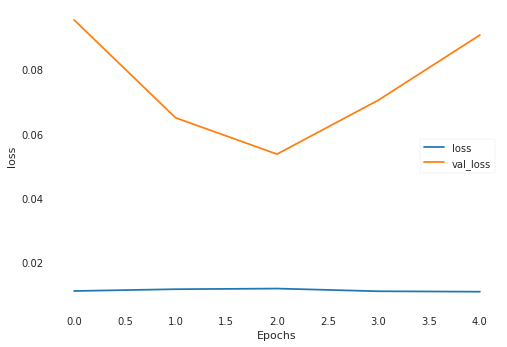

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0119 - val_loss: 0.1151
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0113 - val_loss: 0.1268
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0113 - val_loss: 0.1215
Epoch 00003: early stopping
loss cuts = tf.Tensor([0.04247325], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.86894363, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.0476132], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.68785876, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.05066806], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.59024686, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.04662096], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.7211699, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.05031314], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.6012044, shape=(), dtype=float32)
loss 

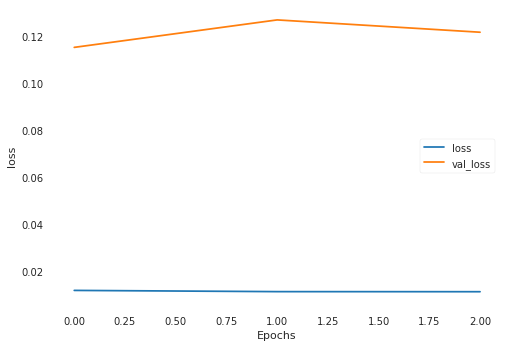

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0111 - val_loss: 0.0777
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0118 - val_loss: 0.0637
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0110 - val_loss: 0.0761
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0108 - val_loss: 0.0597
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0107 - val_loss: 0.0688
Epoch 6/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0123 - val_loss: 0.2782
Epoch 00006: early stopping
loss cuts = tf.Tensor([0.01384483], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.030438952, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.01489946], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.023523873, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.01488057], shape=(1,), dtype=float32)
mod

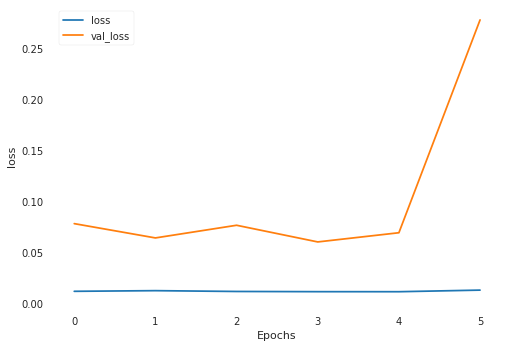

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.7500 - val_loss: 1.0409
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.8768 - val_loss: 0.7919
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.4704 - val_loss: 0.5584
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.3449 - val_loss: 0.4430
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.2903 - val_loss: 0.4095
Epoch 6/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.2635 - val_loss: 0.3380
Epoch 7/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.2265 - val_loss: 0.2760
Epoch 8/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.2047 - val_loss: 0.2440
Epoch 9/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.1877 - val_loss: 0.2280
Epoch 10/10
880/880 [=================

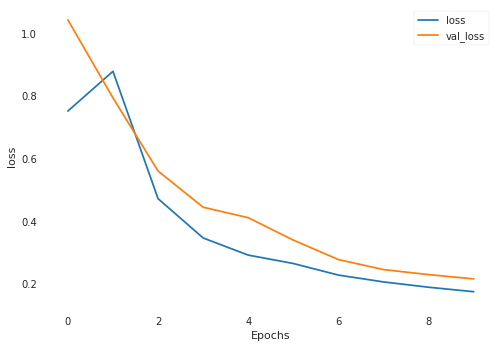

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.1612 - val_loss: 0.2120
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.1508 - val_loss: 0.1959
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.1413 - val_loss: 0.1760
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.1333 - val_loss: 0.2122
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.1267 - val_loss: 0.1639
Epoch 6/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.1184 - val_loss: 0.1714
Epoch 7/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.1129 - val_loss: 0.1682
Epoch 00007: early stopping
loss cuts = tf.Tensor([0.02049377], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.0016099879, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02038001], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0

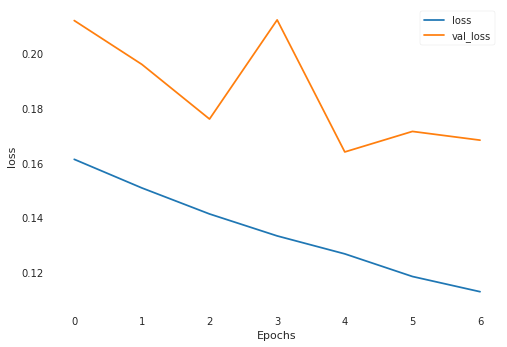

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.1085 - val_loss: 0.1585
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.1032 - val_loss: 0.1351
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0982 - val_loss: 0.1601
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0951 - val_loss: 0.1277
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0909 - val_loss: 0.1240
Epoch 6/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0925 - val_loss: 0.1540
Epoch 7/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0868 - val_loss: 0.1155
Epoch 8/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0809 - val_loss: 0.1095
Epoch 9/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0807 - val_loss: 0.1183
Epoch 10/10
880/880 [=================

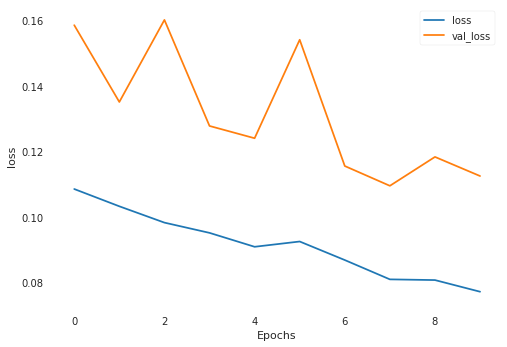

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0726 - val_loss: 0.1327
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0708 - val_loss: 0.1260
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0687 - val_loss: 0.1287
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0655 - val_loss: 0.1249
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0646 - val_loss: 0.1156
Epoch 6/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0632 - val_loss: 0.1215
Epoch 7/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0608 - val_loss: 0.1173
Epoch 00007: early stopping
loss cuts = tf.Tensor([0.03133511], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.029512974, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03694079], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.

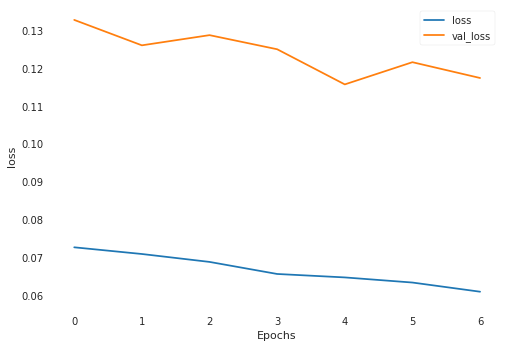

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0588 - val_loss: 0.1187
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0589 - val_loss: 0.1448
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0564 - val_loss: 0.0986
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0546 - val_loss: 0.0968
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0530 - val_loss: 0.1006
Epoch 6/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0520 - val_loss: 0.1134
Epoch 00006: early stopping
loss cuts = tf.Tensor([0.0438483], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.20651151, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.04226044], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.17865682, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.04216756], shape=(1,), dtype=float32)
model2

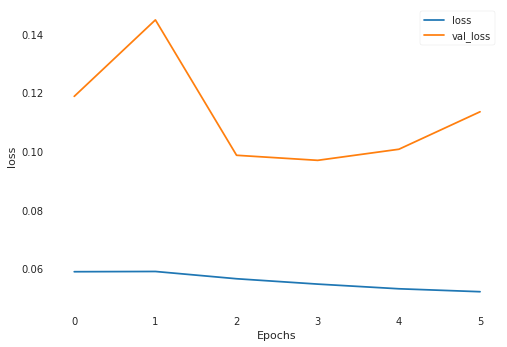

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0517 - val_loss: 0.0734
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0575 - val_loss: 0.2098
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0513 - val_loss: 0.1216
Epoch 00003: early stopping
loss cuts = tf.Tensor([0.0333919], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.24368204, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.04100365], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.116558574, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03801741], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.16090639, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03740565], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.170872, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.0389966], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.14557864, shape=(), dtype=float32)
loss 

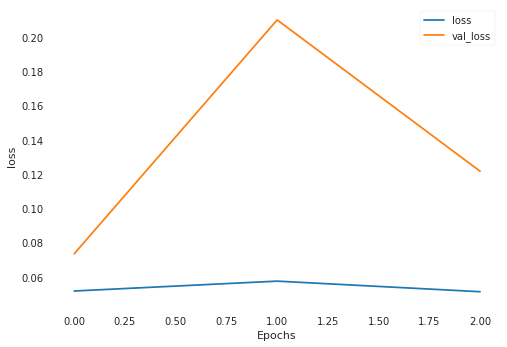

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0519 - val_loss: 0.0850
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0473 - val_loss: 0.0748
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0467 - val_loss: 0.0732
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0446 - val_loss: 0.0722
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0432 - val_loss: 0.0789
Epoch 6/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0418 - val_loss: 0.0723
Epoch 00006: early stopping
loss cuts = tf.Tensor([0.03622511], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.030799467, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03979211], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.010848848, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.04056158], shape=(1,), dtype=float32)
mod

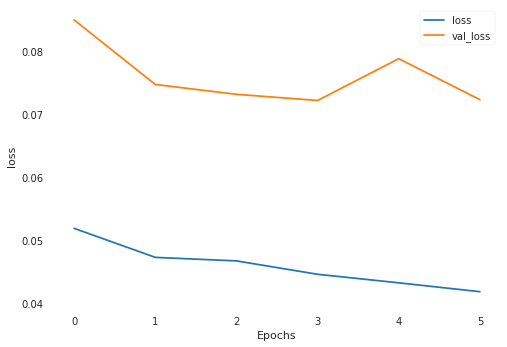

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0419 - val_loss: 0.0755
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0425 - val_loss: 0.1303
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0405 - val_loss: 0.1069
Epoch 00003: early stopping
loss cuts = tf.Tensor([0.04320275], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(2.2452953, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.04539015], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(2.1161032, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.04452492], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(2.1667478, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.04327423], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(2.2410133, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.0503699], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(1.8362634, shape=(), dtype=float32)
loss cut

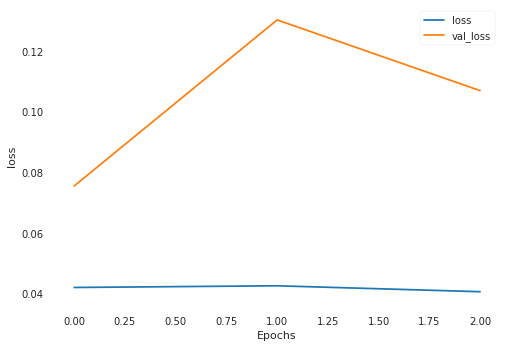

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0414 - val_loss: 0.1669
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0401 - val_loss: 0.1150
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0389 - val_loss: 0.1204
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0572 - val_loss: 0.6265
Epoch 00004: early stopping
loss cuts = tf.Tensor([0.05916281], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(1.1094563, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.04728454], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(1.666352, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.04353667], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(1.8654921, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.04121662], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(1.9943967, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.0405

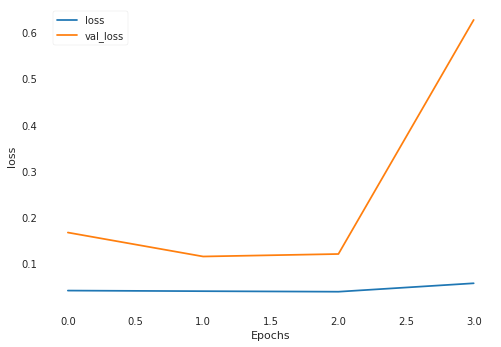

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0867 - val_loss: 0.1423
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0503 - val_loss: 0.0908
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0421 - val_loss: 0.0839
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0390 - val_loss: 0.0829
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0373 - val_loss: 0.0636
Epoch 6/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0365 - val_loss: 0.0611
Epoch 7/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0378 - val_loss: 0.0573
Epoch 8/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0346 - val_loss: 0.0579
Epoch 9/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0394 - val_loss: 0.0636
Epoch 00009: early stopping
loss cuts 

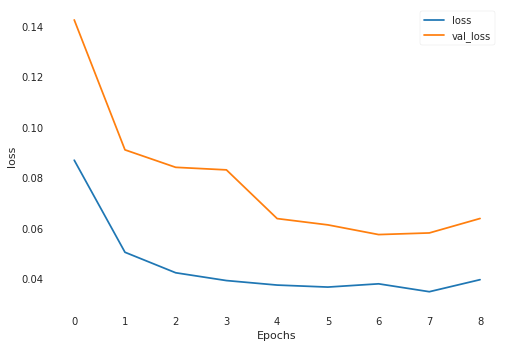

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0375 - val_loss: 0.1251
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0342 - val_loss: 0.1343
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0348 - val_loss: 0.1335
Epoch 00003: early stopping
loss cuts = tf.Tensor([0.03582905], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.23025127, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.0363325], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.22068964, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03283268], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.2913543, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03867856], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.17880617, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.04194983], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.12775572, shape=(), dtype=float32)
loss

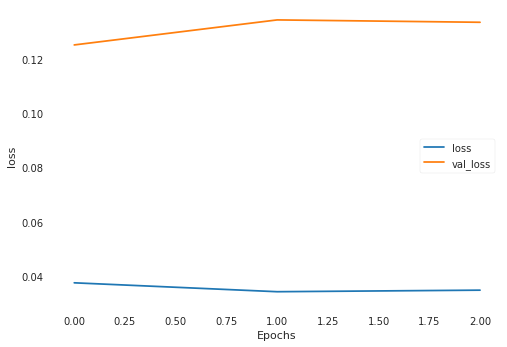

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0361 - val_loss: 0.1156
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0320 - val_loss: 0.1217
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0322 - val_loss: 0.1128
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0319 - val_loss: 0.1140
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0301 - val_loss: 0.0967
Epoch 6/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0310 - val_loss: 0.1049
Epoch 7/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0298 - val_loss: 0.1042
Epoch 00007: early stopping
loss cuts = tf.Tensor([0.02763978], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(1.0353293, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02645754], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(1.08

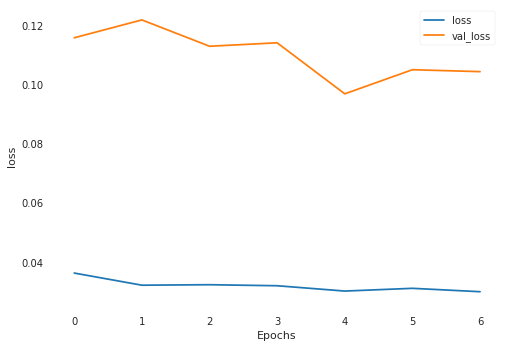

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.1869 - val_loss: 0.3778
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.1107 - val_loss: 0.1859
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0631 - val_loss: 0.1619
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0505 - val_loss: 0.1306
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0459 - val_loss: 0.1210
Epoch 6/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0409 - val_loss: 0.1165
Epoch 7/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0375 - val_loss: 0.1028
Epoch 8/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0366 - val_loss: 0.1089
Epoch 9/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0348 - val_loss: 0.1054
Epoch 00009: early stopping
loss cuts 

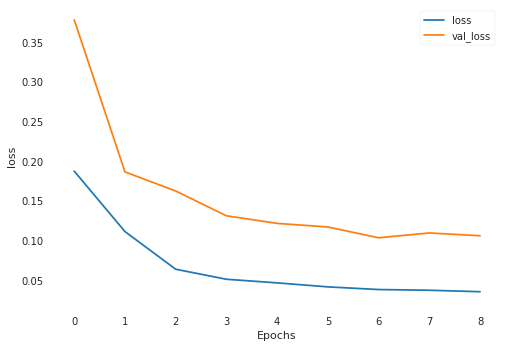

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0334 - val_loss: 0.1131
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0326 - val_loss: 0.0989
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0317 - val_loss: 0.0825
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0309 - val_loss: 0.0792
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0299 - val_loss: 0.0965
Epoch 6/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0306 - val_loss: 0.0726
Epoch 7/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0284 - val_loss: 0.0914
Epoch 8/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0278 - val_loss: 0.0983
Epoch 00008: early stopping
loss cuts = tf.Tensor([0.0369726], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.43777907, shape=(), dtyp

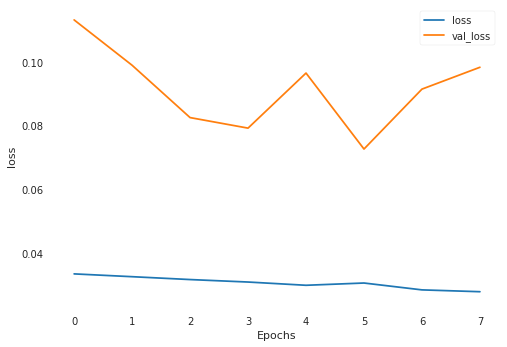

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0288 - val_loss: 0.0792
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0279 - val_loss: 0.0817
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0281 - val_loss: 0.0857
Epoch 00003: early stopping
loss cuts = tf.Tensor([0.02929724], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.30373114, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03009164], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.321496, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03059447], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.33300152, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.029585], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.31010798, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02801037], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.27602503, shape=(), dtype=float32)
loss c

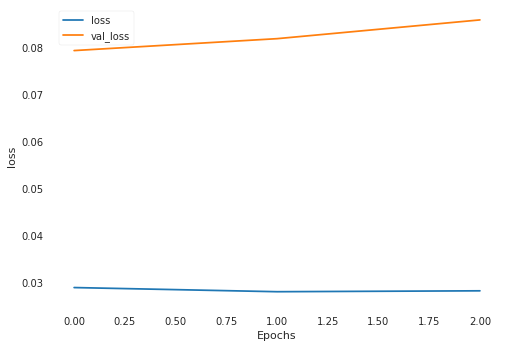

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0269 - val_loss: 0.0560
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0267 - val_loss: 0.0547
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0264 - val_loss: 0.0477
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0276 - val_loss: 0.0822
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0254 - val_loss: 0.0454
Epoch 6/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0254 - val_loss: 0.0482
Epoch 7/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0256 - val_loss: 0.0535
Epoch 00007: early stopping
loss cuts = tf.Tensor([0.02197079], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(1.4655143, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02633168], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(1.26

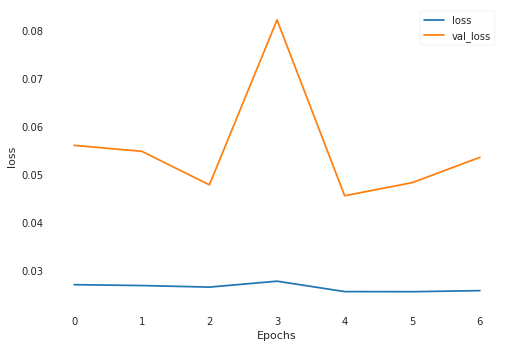

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0258 - val_loss: 0.1035
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0260 - val_loss: 0.0888
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0246 - val_loss: 0.0935
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0246 - val_loss: 0.0803
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0247 - val_loss: 0.0804
Epoch 6/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0242 - val_loss: 0.0815
Epoch 00006: early stopping
loss cuts = tf.Tensor([0.03057379], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.026074465, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03183325], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.034843866, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02903173], shape=(1,), dtype=float32)
mod

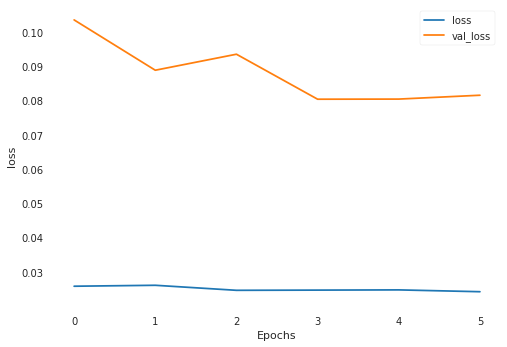

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0249 - val_loss: 0.1208
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0235 - val_loss: 0.1509
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0239 - val_loss: 0.1526
Epoch 00003: early stopping
loss cuts = tf.Tensor([0.02704355], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.5734086, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02573323], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.61378455, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02833997], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.5348131, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02728354], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.5661625, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02805897], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.54306453, shape=(), dtype=float32)
loss 

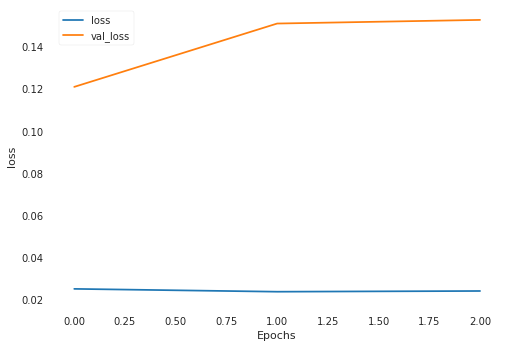

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0239 - val_loss: 0.0864
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0244 - val_loss: 0.0934
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0227 - val_loss: 0.0839
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0228 - val_loss: 0.1106
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0237 - val_loss: 0.0881
Epoch 00005: early stopping
loss cuts = tf.Tensor([0.01963726], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.5806828, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02001564], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.5692066, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02449051], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.44217223, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02234164], shape=(1,), 

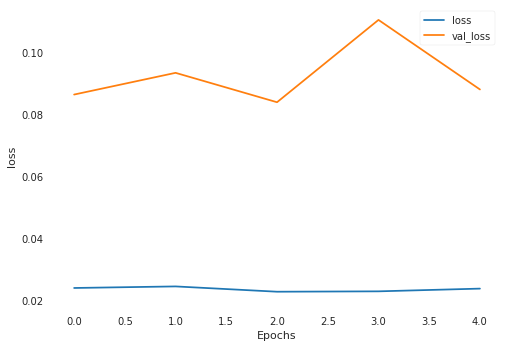

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0239 - val_loss: 0.0619
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0233 - val_loss: 0.0543
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0235 - val_loss: 0.0578
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0219 - val_loss: 0.0461
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0218 - val_loss: 0.0633
Epoch 6/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0215 - val_loss: 0.0450
Epoch 7/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0214 - val_loss: 0.0480
Epoch 8/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0214 - val_loss: 0.0383
Epoch 9/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0220 - val_loss: 0.0455
Epoch 10/10
880/880 [=================

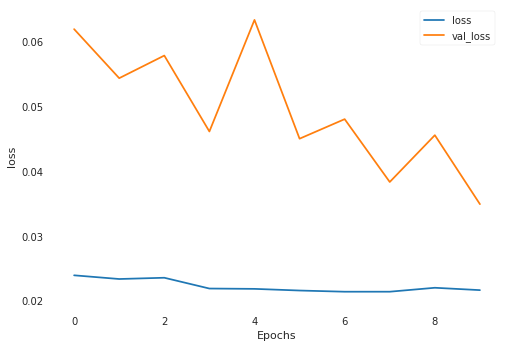

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0212 - val_loss: 0.0634
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0289 - val_loss: 0.0802
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0206 - val_loss: 0.0594
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0209 - val_loss: 0.0622
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0209 - val_loss: 0.0803
Epoch 00005: early stopping
loss cuts = tf.Tensor([0.06190056], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(1.1837683, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.06580582], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(1.3598276, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.06391562], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(1.2730888, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.06377295], shape=(1,), d

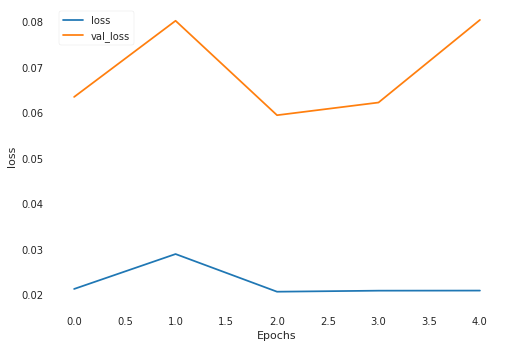

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0211 - val_loss: 0.0535
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0204 - val_loss: 0.0543
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0208 - val_loss: 0.0516
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0212 - val_loss: 0.0368
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0206 - val_loss: 0.0434
Epoch 6/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0206 - val_loss: 0.0428
Epoch 00006: early stopping
loss cuts = tf.Tensor([0.0154229], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.44480306, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.00549025], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.74924374, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.00504362], shape=(1,), dtype=float32)
model2

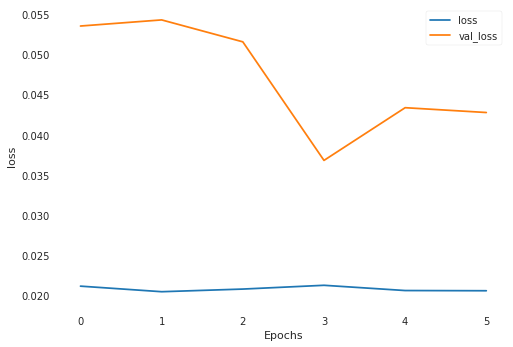

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0200 - val_loss: 0.0499
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0204 - val_loss: 0.0528
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0209 - val_loss: 0.0554
Epoch 00003: early stopping
loss cuts = tf.Tensor([0.05670575], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.7816593, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.06181835], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.97292006, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.05385558], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.6841134, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.04738329], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.48673758, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.05007708], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.5648148, shape=(), dtype=float32)
loss 

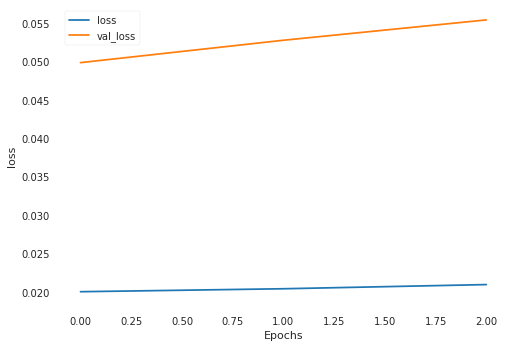

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0192 - val_loss: 0.0972
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0191 - val_loss: 0.1173
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0195 - val_loss: 0.1083
Epoch 00003: early stopping
loss cuts = tf.Tensor([0.05165214], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.86489546, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.05004891], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.92556375, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.05458768], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.7591406, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.05667414], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.6881659, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.05796921], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.64586353, shape=(), dtype=float32)
loss

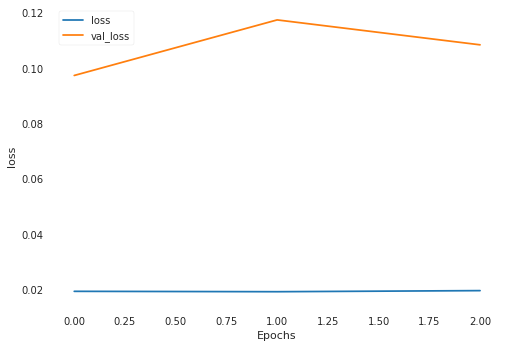

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0211 - val_loss: 0.0714
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0197 - val_loss: 0.0676
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0198 - val_loss: 0.0487
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0197 - val_loss: 0.0482
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0196 - val_loss: 0.0422
Epoch 6/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0191 - val_loss: 0.0452
Epoch 7/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0181 - val_loss: 0.0327
Epoch 8/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0194 - val_loss: 0.0353
Epoch 9/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0183 - val_loss: 0.0312
Epoch 10/10
880/880 [=================

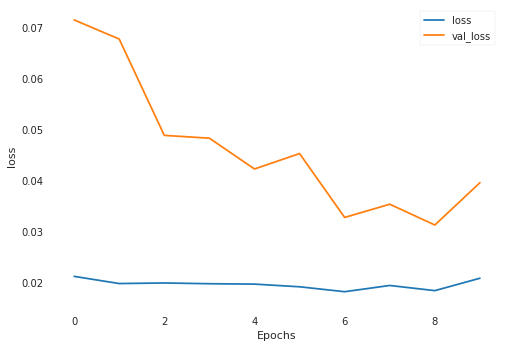

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0190 - val_loss: 0.0705
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0184 - val_loss: 0.0636
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0192 - val_loss: 0.0700
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0202 - val_loss: 0.0638
Epoch 00004: early stopping
loss cuts = tf.Tensor([0.03478088], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.40599513, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03753806], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.33876356, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03134654], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.49824443, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03112679], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.50446844, shape=(), dtype=float32)
loss cuts = tf.Tensor([0

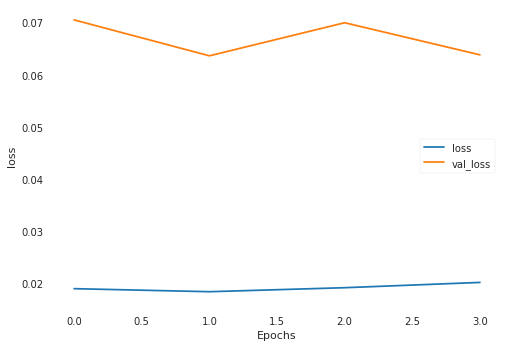

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0180 - val_loss: 0.0673
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0181 - val_loss: 0.0682
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0176 - val_loss: 0.0710
Epoch 00003: early stopping
loss cuts = tf.Tensor([0.01747908], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.20796253, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.01817272], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.19550231, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02081596], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.15154794, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02056656], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.15545635, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.01924469], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.17700282, shape=(), dtype=float32)
lo

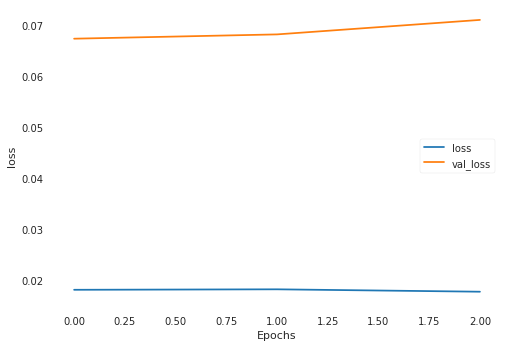

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0180 - val_loss: 0.1096
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0191 - val_loss: 0.1253
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0185 - val_loss: 0.1285
Epoch 00003: early stopping
loss cuts = tf.Tensor([0.04818848], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.045697447, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.04883187], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.05136455, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.05140763], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.07736886, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.05808326], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.16946824, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.05172455], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.080935165, shape=(), dtype=float32)


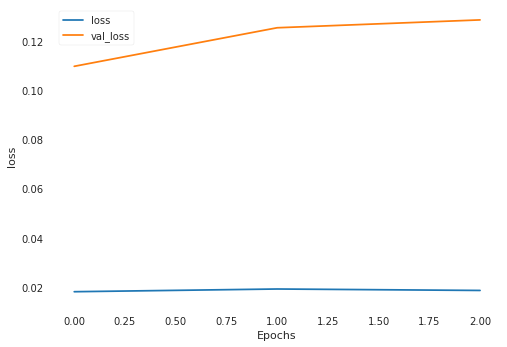

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0182 - val_loss: 0.1374
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0185 - val_loss: 0.0886
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0173 - val_loss: 0.1017
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0172 - val_loss: 0.0894
Epoch 00004: early stopping
loss cuts = tf.Tensor([0.02247081], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.021716436, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.0222048], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.02331276, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.01927368], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.04465082, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.01832245], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.053052865, shape=(), dtype=float32)
loss cuts = tf.Tensor([

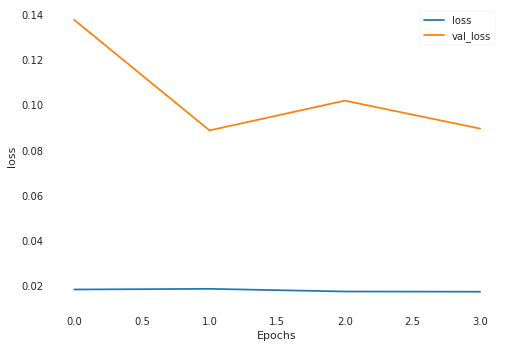

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0174 - val_loss: 0.0387
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0176 - val_loss: 0.0367
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0177 - val_loss: 0.0303
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0189 - val_loss: 0.0330
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0175 - val_loss: 0.0324
Epoch 00005: early stopping
loss cuts = tf.Tensor([0.0408152], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.3679846, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.04680064], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.5275496, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.04294077], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.42136797, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.04944355], shape=(1,), d

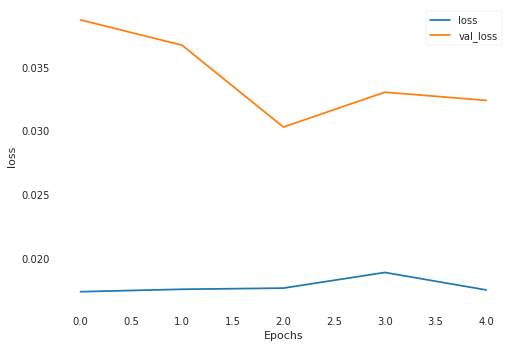

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0168 - val_loss: 0.0210
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0179 - val_loss: 0.0214
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0175 - val_loss: 0.0233
Epoch 00003: early stopping
loss cuts = tf.Tensor([0.02400073], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.51837903, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02359105], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.5302448, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02183624], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.58258915, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02229859], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.56855863, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.01962573], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.6520328, shape=(), dtype=float32)
loss

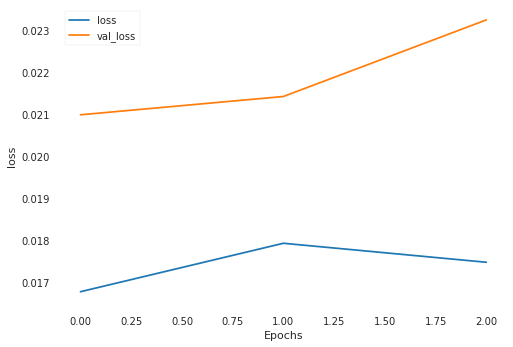

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0175 - val_loss: 0.0193
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0171 - val_loss: 0.0261
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0174 - val_loss: 0.0255
Epoch 00003: early stopping
loss cuts = tf.Tensor([0.02392054], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.052171458, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02839907], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.101112224, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02815538], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.09803638, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03216728], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.15472075, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03513379], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.20491545, shape=(), dtype=float32)


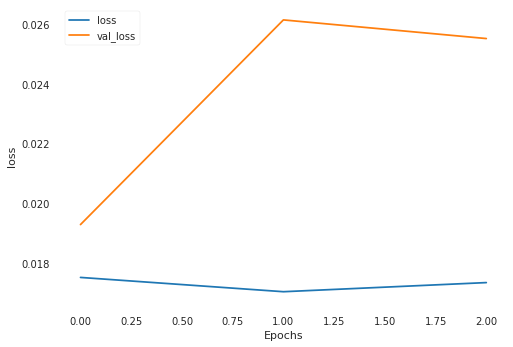

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0176 - val_loss: 0.0552
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0160 - val_loss: 0.0436
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0162 - val_loss: 0.0542
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0165 - val_loss: 0.0632
Epoch 00004: early stopping
loss cuts = tf.Tensor([0.03880937], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.07627952, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03741226], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.06162564, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03868579], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.0749204, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.0356825], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.045646343, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.

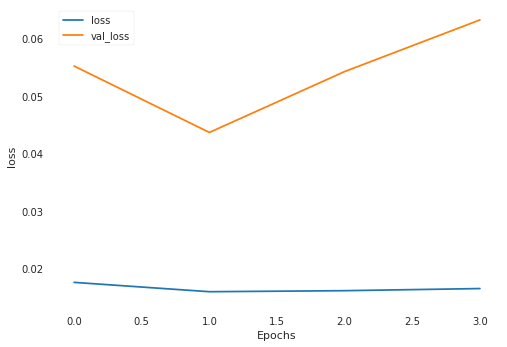

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0186 - val_loss: 0.0486
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0160 - val_loss: 0.0396
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0155 - val_loss: 0.0418
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0153 - val_loss: 0.0401
Epoch 00004: early stopping
loss cuts = tf.Tensor([0.03620593], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.075141005, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.04371702], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.1800647, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.04539992], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.20976259, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.0428096], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.16499195, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.

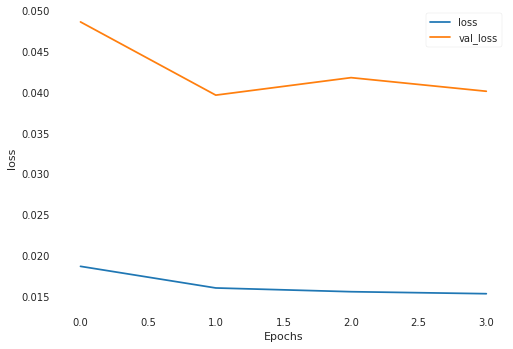

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0177 - val_loss: 0.0572
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0230 - val_loss: 0.0263
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0152 - val_loss: 0.0334
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0154 - val_loss: 0.0283
Epoch 00004: early stopping
loss cuts = tf.Tensor([0.03346973], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.078739375, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03193137], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.09695285, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02968951], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.12688543, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02790648], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.1535624, shape=(), dtype=float32)
loss cuts = tf.Tensor([0

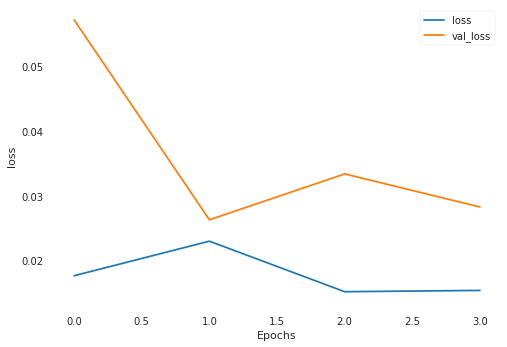

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0151 - val_loss: 0.0698
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0152 - val_loss: 0.0732
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0336 - val_loss: 0.0803
Epoch 00003: early stopping
loss cuts = tf.Tensor([0.03792733], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(3.3059757, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03358144], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(3.6296043, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03418174], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(3.584002, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03517395], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(3.50926, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.0356194], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(3.4759603, shape=(), dtype=float32)
loss cuts =

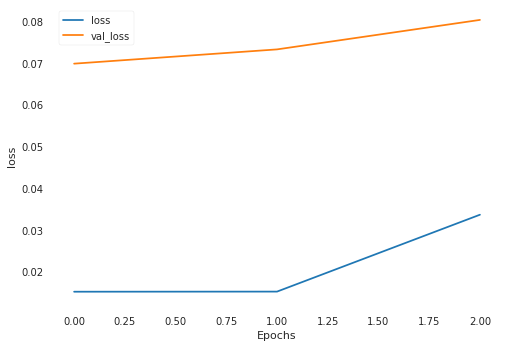

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0167 - val_loss: 0.1582
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0153 - val_loss: 0.1935
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0152 - val_loss: 0.1100
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0147 - val_loss: 0.1210
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0149 - val_loss: 0.2168
Epoch 00005: early stopping
loss cuts = tf.Tensor([0.04685858], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.8332559, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.04336606], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.9656576, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.04322201], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.971328, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.04594271], shape=(1,), dt

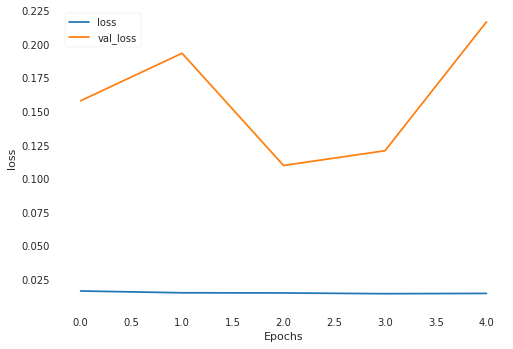

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0330 - val_loss: 0.0752
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0156 - val_loss: 0.0696
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0155 - val_loss: 0.0643
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0143 - val_loss: 0.0656
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0146 - val_loss: 0.0635
Epoch 6/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0150 - val_loss: 0.0625
Epoch 7/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0144 - val_loss: 0.0562
Epoch 8/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0144 - val_loss: 0.0592
Epoch 9/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0141 - val_loss: 0.0590
Epoch 00009: early stopping
loss cuts 

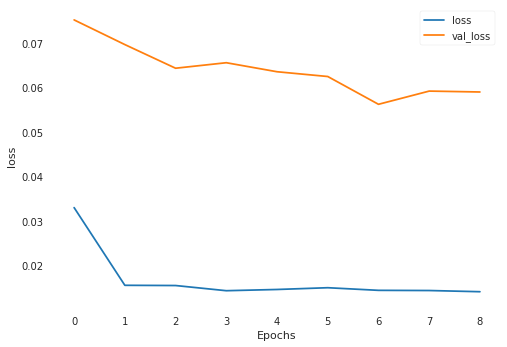

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0143 - val_loss: 0.0533
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0140 - val_loss: 0.0590
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0146 - val_loss: 0.0403
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0140 - val_loss: 0.0441
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0140 - val_loss: 0.0334
Epoch 6/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0141 - val_loss: 0.0423
Epoch 7/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0143 - val_loss: 0.0384
Epoch 00007: early stopping
loss cuts = tf.Tensor([0.01255568], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.061944414, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.01180001], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.

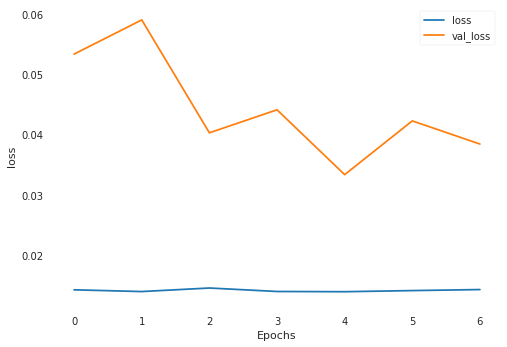

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0162 - val_loss: 0.0470
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0147 - val_loss: 0.0333
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0134 - val_loss: 0.0404
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0135 - val_loss: 0.0387
Epoch 00004: early stopping
loss cuts = tf.Tensor([0.0273869], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.08864789, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02454796], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.05806129, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02232284], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.03859527, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02184828], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.03495612, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.

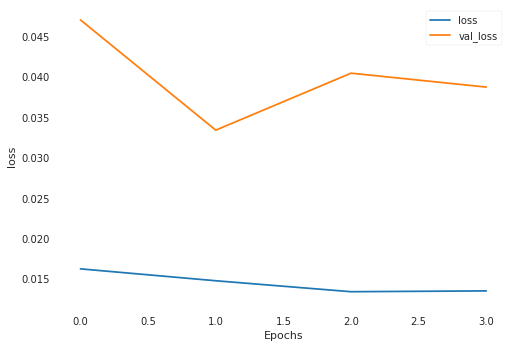

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0142 - val_loss: 0.1777
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0158 - val_loss: 0.0613
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0140 - val_loss: 0.1073
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0142 - val_loss: 0.0660
Epoch 00004: early stopping
loss cuts = tf.Tensor([0.02469649], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.086394735, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02249753], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.062475335, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02266726], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.06418379, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.0222832], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.060350794, shape=(), dtype=float32)
loss cuts = tf.Tensor(

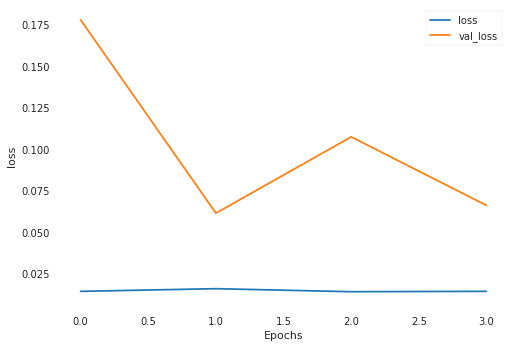

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0144 - val_loss: 0.2636
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0143 - val_loss: 0.2865
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0143 - val_loss: 0.2473
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0145 - val_loss: 0.0769
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0154 - val_loss: 0.2004
Epoch 6/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0137 - val_loss: 0.1082
Epoch 00006: early stopping
loss cuts = tf.Tensor([0.03311991], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.030758267, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.030612], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.05086769, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03021492], shape=(1,), dtype=float32)
model2

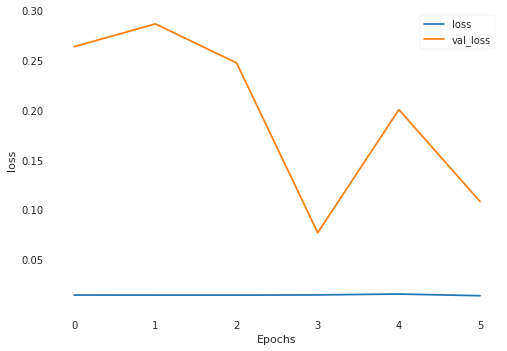

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0143 - val_loss: 0.0349
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0145 - val_loss: 0.0385
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0143 - val_loss: 0.0303
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0134 - val_loss: 0.0462
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0136 - val_loss: 0.0245
Epoch 6/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0141 - val_loss: 0.0381
Epoch 7/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0134 - val_loss: 0.0360
Epoch 00007: early stopping
loss cuts = tf.Tensor([0.03607387], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(1.3889155, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03561974], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(1.41

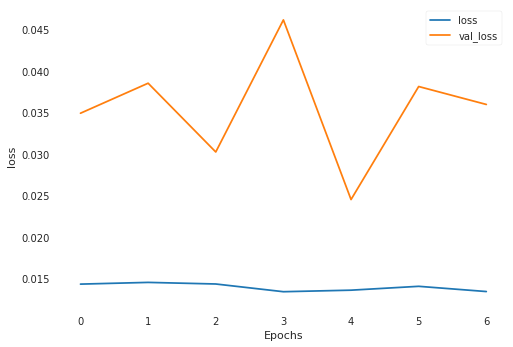

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0141 - val_loss: 0.1202
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0142 - val_loss: 0.0647
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0132 - val_loss: 0.0829
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0138 - val_loss: 0.0502
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0138 - val_loss: 0.0936
Epoch 6/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0140 - val_loss: 0.0491
Epoch 7/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0131 - val_loss: 0.1815
Epoch 8/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0147 - val_loss: 0.0482
Epoch 9/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0136 - val_loss: 0.0346
Epoch 10/10
880/880 [=================

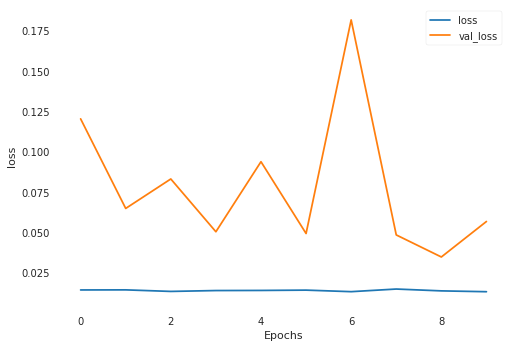

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0147 - val_loss: 0.0632
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0136 - val_loss: 0.0690
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0129 - val_loss: 0.0737
Epoch 00003: early stopping
loss cuts = tf.Tensor([0.02665007], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.60360825, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02459547], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.66914713, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02495313], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.65749556, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02665908], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.6033281, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02668203], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.60261536, shape=(), dtype=float32)
los

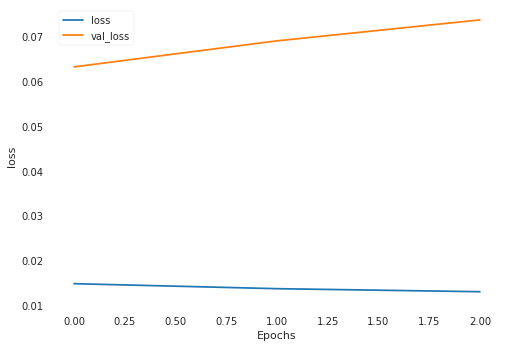

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0138 - val_loss: 0.0621
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0126 - val_loss: 0.0425
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0139 - val_loss: 0.0404
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0130 - val_loss: 0.0565
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0131 - val_loss: 0.0507
Epoch 00005: early stopping
loss cuts = tf.Tensor([0.03867017], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.39262313, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03748116], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.4229899, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03912235], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.38137156, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03944622], shape=(1,),

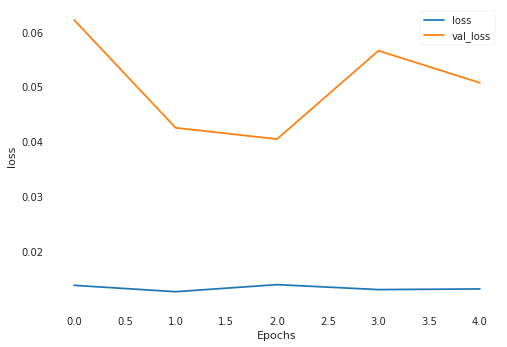

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0131 - val_loss: 0.1108
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0127 - val_loss: 0.0741
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0123 - val_loss: 0.0621
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0132 - val_loss: 0.0606
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0130 - val_loss: 0.0794
Epoch 6/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0133 - val_loss: 0.0521
Epoch 7/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0136 - val_loss: 0.0548
Epoch 8/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0129 - val_loss: 0.0522
Epoch 00008: early stopping
loss cuts = tf.Tensor([0.03517662], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(1.2477497e-05, shape=(), 

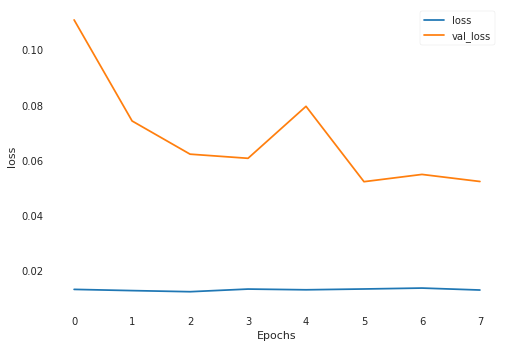

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0131 - val_loss: 0.0485
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0138 - val_loss: 0.0651
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0127 - val_loss: 0.1319
Epoch 00003: early stopping
loss cuts = tf.Tensor([0.02614984], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.019121656, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02415871], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.009694076, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02318274], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.0062313876, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02392625], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.008800169, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02443834], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.010826616, shape=(), dtype=float

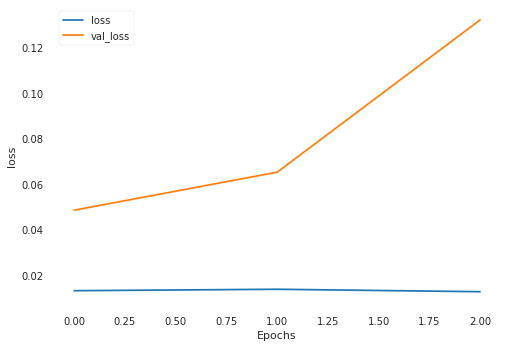

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0132 - val_loss: 0.0478
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0203 - val_loss: 0.1460
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0454 - val_loss: 0.0620
Epoch 00003: early stopping
loss cuts = tf.Tensor([0.02915494], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.2942762, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02833977], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.31223032, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03135642], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.24844514, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03022863], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.2714394, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.0316276], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.24306783, shape=(), dtype=float32)
loss 

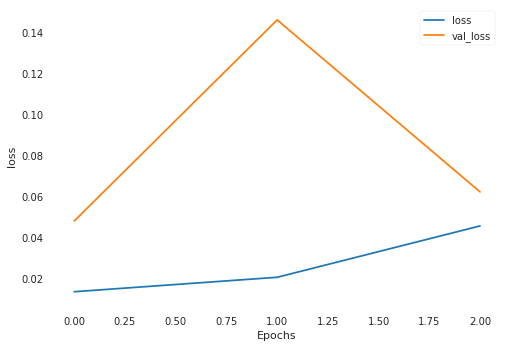

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0146 - val_loss: 0.0500
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0128 - val_loss: 0.0395
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0120 - val_loss: 0.0407
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0119 - val_loss: 0.0425
Epoch 00004: early stopping
loss cuts = tf.Tensor([0.02443087], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.10084567, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02356621], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.112128004, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02247619], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.1272033, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02501706], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.09353699, shape=(), dtype=float32)
loss cuts = tf.Tensor([0

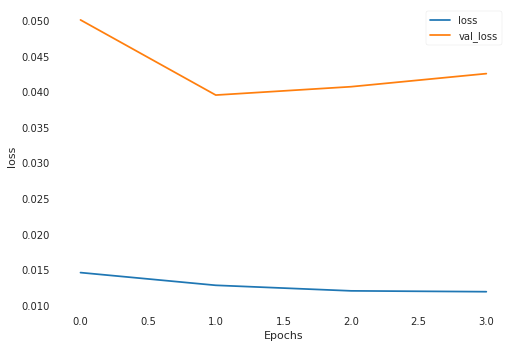

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0116 - val_loss: 0.0765
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0121 - val_loss: 0.0503
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0119 - val_loss: 0.0486
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0116 - val_loss: 0.0709
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0114 - val_loss: 0.0715
Epoch 00005: early stopping
loss cuts = tf.Tensor([0.03155951], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(1.1084442, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03415457], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(1.0018519, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.0313861], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(1.1157593, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03198998], shape=(1,), dt

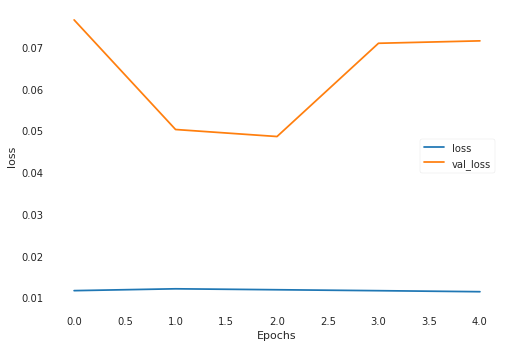

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0118 - val_loss: 0.0559
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0122 - val_loss: 0.1040
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0116 - val_loss: 0.0848
Epoch 00003: early stopping
loss cuts = tf.Tensor([0.04736625], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.20009959, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.04960513], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.24216494, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.05016516], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.2533142, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.04706063], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.1946685, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.05129927], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.2766607, shape=(), dtype=float32)
loss 

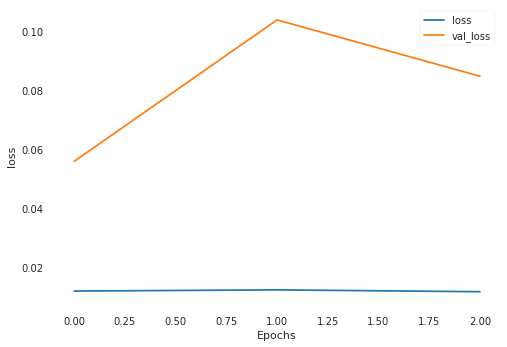

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0123 - val_loss: 0.1331
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0121 - val_loss: 0.1074
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0124 - val_loss: 0.0995
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0136 - val_loss: 0.1019
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0115 - val_loss: 0.0964
Epoch 6/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0116 - val_loss: 0.1052
Epoch 7/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0124 - val_loss: 0.1122
Epoch 00007: early stopping
loss cuts = tf.Tensor([0.03068077], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(3.8223193, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03480066], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(3.50

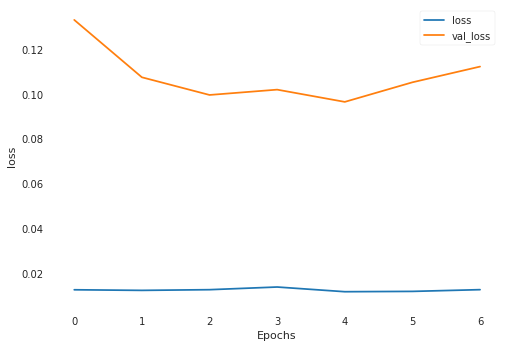

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0123 - val_loss: 0.1142
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0120 - val_loss: 0.1022
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0115 - val_loss: 0.1042
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0125 - val_loss: 0.0836
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0122 - val_loss: 0.0995
Epoch 6/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0119 - val_loss: 0.1241
Epoch 00006: early stopping
loss cuts = tf.Tensor([0.03739639], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.061468158, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03968551], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.0862657, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03819956], shape=(1,), dtype=float32)
model

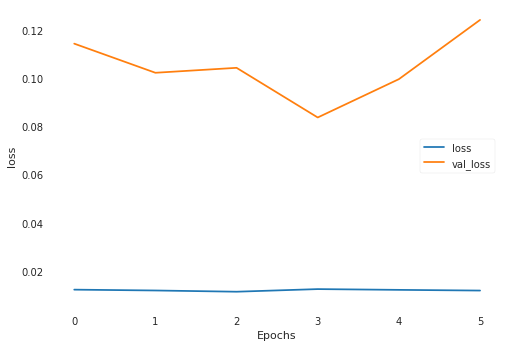

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0118 - val_loss: 0.0306
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0138 - val_loss: 0.0308
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0119 - val_loss: 0.0454
Epoch 00003: early stopping
loss cuts = tf.Tensor([0.0545655], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(3.2713597, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.05060961], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(3.5638185, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.05252425], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(3.4207065, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.053186], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(3.3719246, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.04859004], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(3.7179525, shape=(), dtype=float32)
loss cuts 

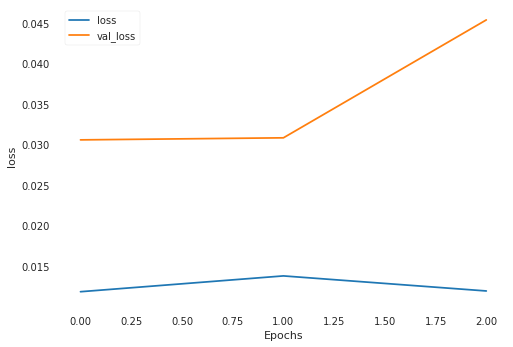

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0119 - val_loss: 0.1088
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0117 - val_loss: 0.1693
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0119 - val_loss: 0.1318
Epoch 00003: early stopping
loss cuts = tf.Tensor([0.03023377], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.041892022, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03248297], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.06232978, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03038375], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.043128934, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02666212], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.017753521, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02575064], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.013227943, shape=(), dtype=float32

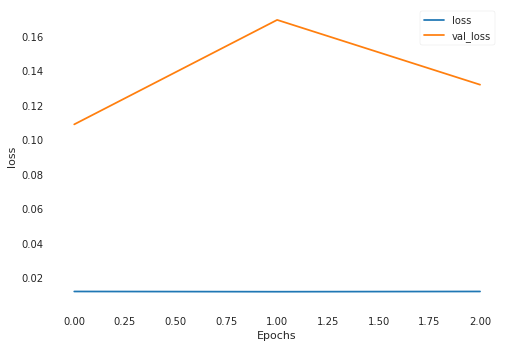

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0119 - val_loss: 0.0837
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0152 - val_loss: 0.0948
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0119 - val_loss: 0.1118
Epoch 00003: early stopping
loss cuts = tf.Tensor([0.02570088], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.087609366, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02604404], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.083593555, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02361546], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.11403936, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02544896], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.09061733, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.0247281], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.09950514, shape=(), dtype=float32)
l

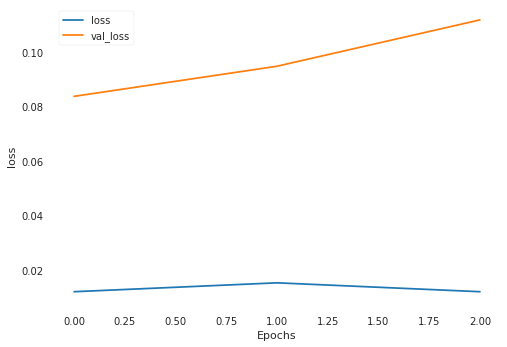

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0118 - val_loss: 0.1210
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0120 - val_loss: 0.1630
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0115 - val_loss: 0.1067
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0124 - val_loss: 0.1213
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0128 - val_loss: 0.1615
Epoch 00005: early stopping
loss cuts = tf.Tensor([0.02575433], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.0033464883, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02488719], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.0016407486, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02427045], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.00079361716, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02377758], sha

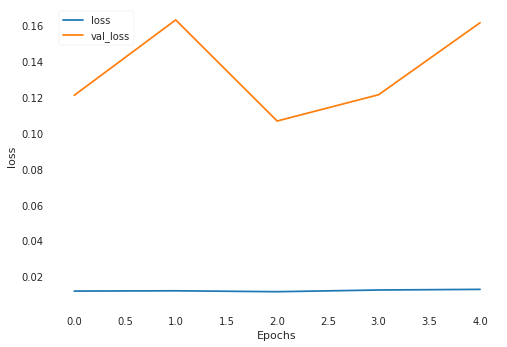

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0137 - val_loss: 0.1169
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0121 - val_loss: 0.1078
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0115 - val_loss: 0.1032
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0112 - val_loss: 0.1203
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0117 - val_loss: 0.0940
Epoch 6/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0119 - val_loss: 0.0940
Epoch 7/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0126 - val_loss: 0.0919
Epoch 8/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0112 - val_loss: 0.1059
Epoch 9/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0115 - val_loss: 0.1126
Epoch 00009: early stopping
loss cuts 

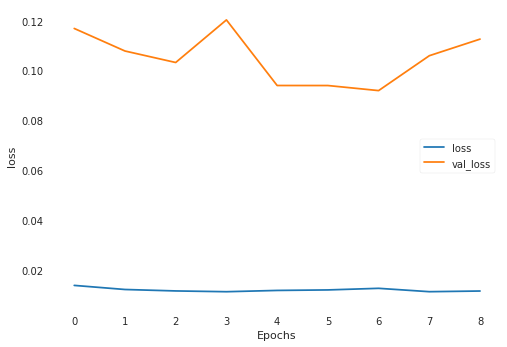

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0116 - val_loss: 0.1185
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0114 - val_loss: 0.1052
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0126 - val_loss: 0.0964
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0119 - val_loss: 0.1360
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0120 - val_loss: 0.1344
Epoch 00005: early stopping
loss cuts = tf.Tensor([0.06930896], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.67662627, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.06845556], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.64883834, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.06694536], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.6010916, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.06634305], shape=(1,),

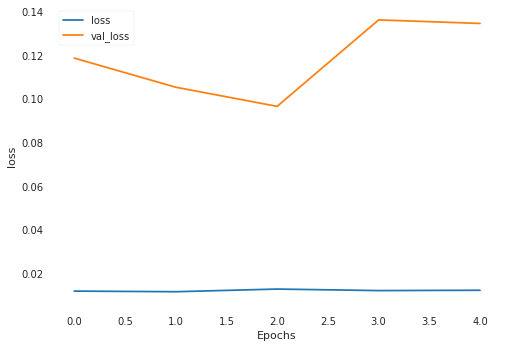

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0117 - val_loss: 0.1282
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0115 - val_loss: 0.1444
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0120 - val_loss: 0.0792
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0120 - val_loss: 0.0934
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0118 - val_loss: 0.0646
Epoch 6/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0115 - val_loss: 0.0881
Epoch 7/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0717 - val_loss: 0.1039
Epoch 00007: early stopping
loss cuts = tf.Tensor([0.05789128], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.3111695, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.05263526], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.20

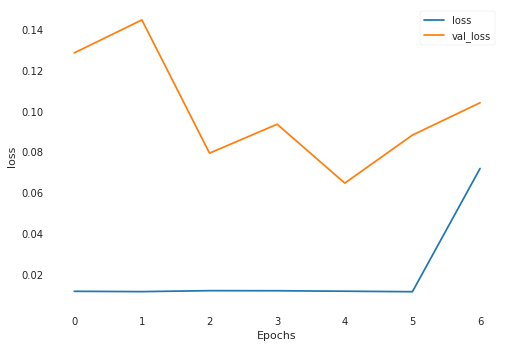

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0221 - val_loss: 0.0502
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0145 - val_loss: 0.0775
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0129 - val_loss: 0.0419
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0117 - val_loss: 0.0725
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0116 - val_loss: 0.0735
Epoch 00005: early stopping
loss cuts = tf.Tensor([0.02597018], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(6.6545763, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02407489], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(6.851581, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.01853385], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(7.4440207, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.0142802], shape=(1,), dty

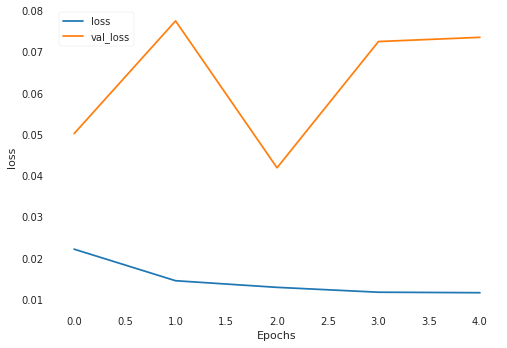

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0114 - val_loss: 0.0668
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0111 - val_loss: 0.0378
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0110 - val_loss: 0.0300
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0109 - val_loss: 0.0236
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0110 - val_loss: 0.0452
Epoch 6/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0109 - val_loss: 0.0222
Epoch 7/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0107 - val_loss: 0.0194
Epoch 8/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0108 - val_loss: 0.0201
Epoch 9/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0107 - val_loss: 0.0188
Epoch 10/10
880/880 [=================

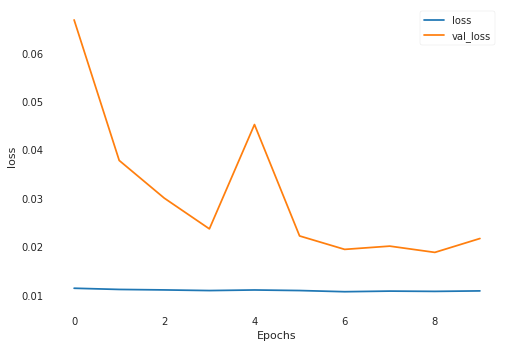

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0111 - val_loss: 0.0390
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0104 - val_loss: 0.0485
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0104 - val_loss: 0.0434
Epoch 00003: early stopping
loss cuts = tf.Tensor([0.05710227], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.478927, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.05430837], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.40470904, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.05791579], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.50171125, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.05350722], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.38457897, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.05248623], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.3596696, shape=(), dtype=float32)
loss 

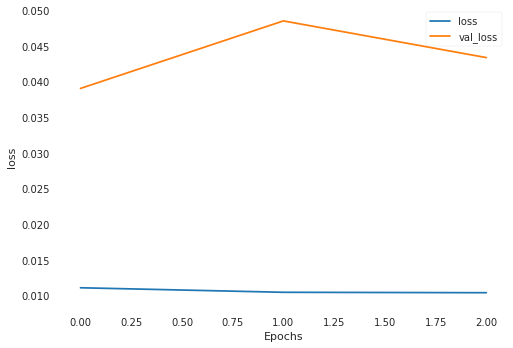

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0109 - val_loss: 0.0455
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0116 - val_loss: 0.0364
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0107 - val_loss: 0.0321
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0110 - val_loss: 0.0341
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0107 - val_loss: 0.0382
Epoch 00005: early stopping
loss cuts = tf.Tensor([0.02897824], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.13688211, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02587663], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.09482927, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02232449], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.056121964, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02419303], shape=(1,

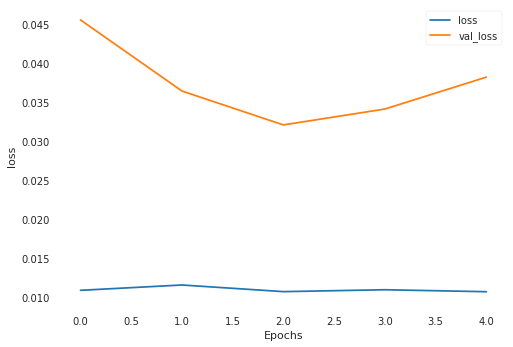

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0119 - val_loss: 0.0684
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0111 - val_loss: 0.0496
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0109 - val_loss: 0.0429
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0108 - val_loss: 0.0483
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0115 - val_loss: 0.0668
Epoch 00005: early stopping
loss cuts = tf.Tensor([0.01147934], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.048581943, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.01169038], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.04673914, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.01381886], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.030144893, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.01427848], shape=(1

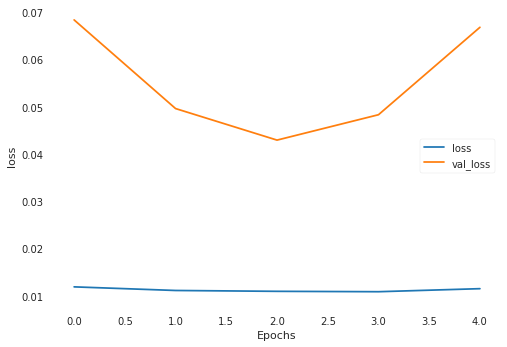

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0114 - val_loss: 0.0447
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0107 - val_loss: 0.0619
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0111 - val_loss: 0.0472
Epoch 00003: early stopping
loss cuts = tf.Tensor([0.04817592], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.46401635, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.05173597], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.37208343, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.04511366], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.5512062, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.0425114], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.6311949, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.0427742], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.622871, shape=(), dtype=float32)
loss cut

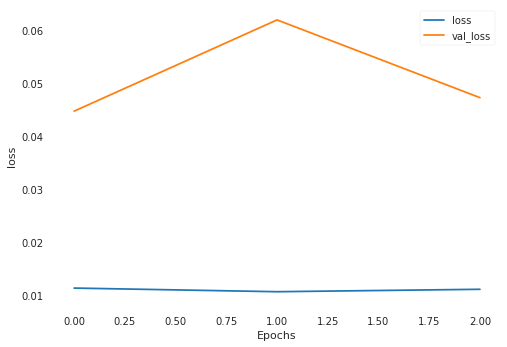

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0113 - val_loss: 0.0530
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0111 - val_loss: 0.0602
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0104 - val_loss: 0.0504
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0113 - val_loss: 0.0521
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0109 - val_loss: 0.0457
Epoch 6/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0105 - val_loss: 0.0561
Epoch 7/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0108 - val_loss: 0.0471
Epoch 00007: early stopping
loss cuts = tf.Tensor([0.02736207], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(2.2257981, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03025509], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(2.05

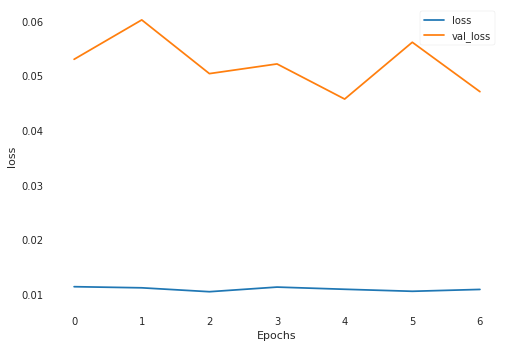

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0111 - val_loss: 0.1054
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0389 - val_loss: 0.2069
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0206 - val_loss: 0.0634
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0115 - val_loss: 0.0626
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0104 - val_loss: 0.0474
Epoch 6/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0104 - val_loss: 0.0703
Epoch 7/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0100 - val_loss: 0.0704
Epoch 00007: early stopping
loss cuts = tf.Tensor([0.03748927], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.6708108, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03864677], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.63

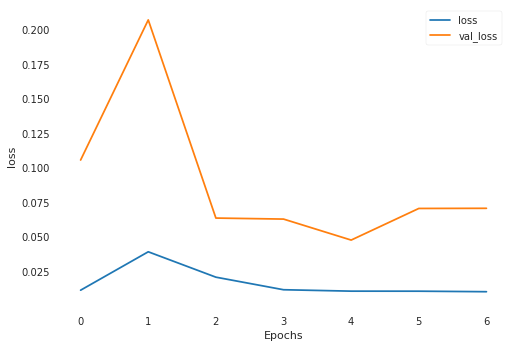

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0104 - val_loss: 0.1123
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0102 - val_loss: 0.1184
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0102 - val_loss: 0.1067
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0101 - val_loss: 0.1082
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0101 - val_loss: 0.1161
Epoch 00005: early stopping
loss cuts = tf.Tensor([0.0161288], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(1.3994074, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.01854882], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(1.287238, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.01855108], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(1.2871357, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.01652013], shape=(1,), dty

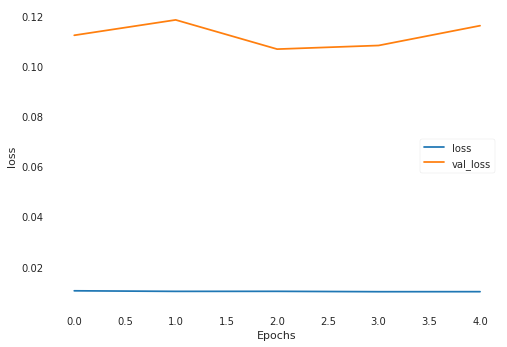

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0103 - val_loss: 0.1358
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0106 - val_loss: 0.1480
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0102 - val_loss: 0.1415
Epoch 00003: early stopping
loss cuts = tf.Tensor([0.05024752], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(3.5109787, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.04837413], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(3.6527941, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.0478879], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(3.6900606, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.05576185], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(3.1098404, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.05752791], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(2.986512, shape=(), dtype=float32)
loss cuts

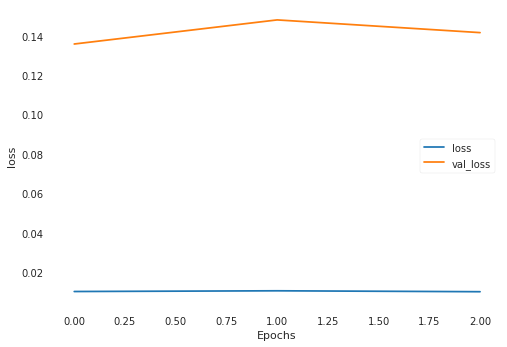

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0104 - val_loss: 0.0652
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0104 - val_loss: 0.0447
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0105 - val_loss: 0.0422
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0113 - val_loss: 0.0483
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0105 - val_loss: 0.0374
Epoch 6/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0102 - val_loss: 0.0433
Epoch 7/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0107 - val_loss: 0.0306
Epoch 8/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0104 - val_loss: 0.0281
Epoch 9/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0107 - val_loss: 0.0562
Epoch 10/10
880/880 [=================

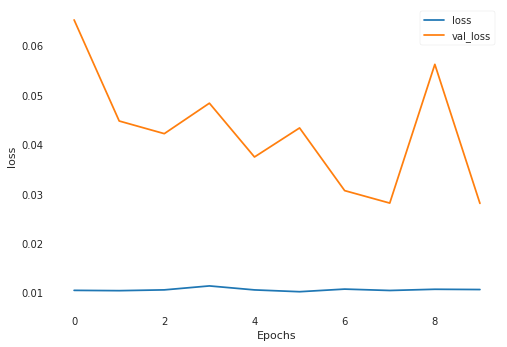

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0107 - val_loss: 0.0955
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0104 - val_loss: 0.0910
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0146 - val_loss: 0.1437
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0175 - val_loss: 0.1127
Epoch 00004: early stopping
loss cuts = tf.Tensor([0.04202768], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.0041981163, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.04416489], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.0004861457, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03746137], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.024373194, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03877871], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.016840821, shape=(), dtype=float32)
loss cuts = tf.Ten

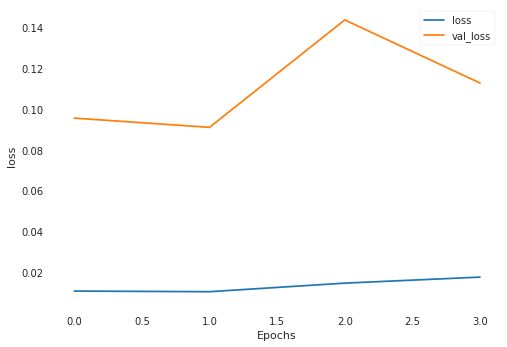

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0103 - val_loss: 0.1166
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0103 - val_loss: 0.1326
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0102 - val_loss: 0.1657
Epoch 00003: early stopping
loss cuts = tf.Tensor([0.0534111], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(1.9700133, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.04802019], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(2.2842996, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.0428711], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(2.6061954, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.04167732], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(2.683854, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.04149177], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(2.6960268, shape=(), dtype=float32)
loss cuts 

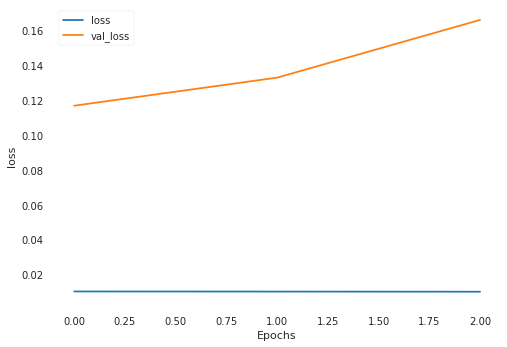

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0106 - val_loss: 0.1421
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0104 - val_loss: 0.1320
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0104 - val_loss: 0.1231
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0104 - val_loss: 0.1100
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0104 - val_loss: 0.1080
Epoch 6/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0102 - val_loss: 0.1247
Epoch 7/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0100 - val_loss: 0.1345
Epoch 00007: early stopping
loss cuts = tf.Tensor([0.05485851], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(3.7706673, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.05995057], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(3.38

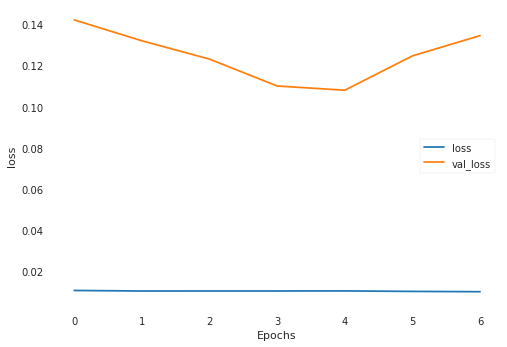

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0107 - val_loss: 0.1121
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0105 - val_loss: 0.1027
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0108 - val_loss: 0.1180
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0105 - val_loss: 0.1207
Epoch 00004: early stopping
loss cuts = tf.Tensor([0.02210192], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.56302094, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02221391], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.5596649, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02358835], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.51929116, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02378615], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.51360554, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.

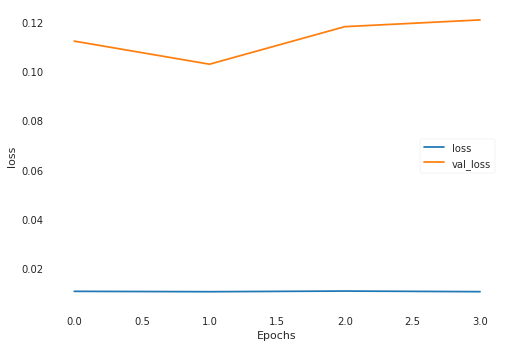

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0105 - val_loss: 0.0986
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0108 - val_loss: 0.0980
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0111 - val_loss: 0.0848
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0110 - val_loss: 0.0867
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0107 - val_loss: 0.0731
Epoch 6/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0102 - val_loss: 0.0584
Epoch 7/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0105 - val_loss: 0.0744
Epoch 8/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0101 - val_loss: 0.0723
Epoch 00008: early stopping
loss cuts = tf.Tensor([0.01921655], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(2.5096552, shape=(), dtyp

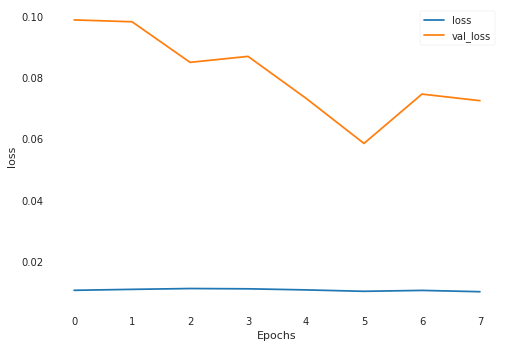

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0106 - val_loss: 0.0353
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0105 - val_loss: 0.0308
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0105 - val_loss: 0.0353
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0106 - val_loss: 0.0266
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0109 - val_loss: 0.0330
Epoch 6/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0104 - val_loss: 0.0252
Epoch 7/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0104 - val_loss: 0.0281
Epoch 8/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0104 - val_loss: 0.0213
Epoch 9/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0104 - val_loss: 0.0233
Epoch 10/10
880/880 [=================

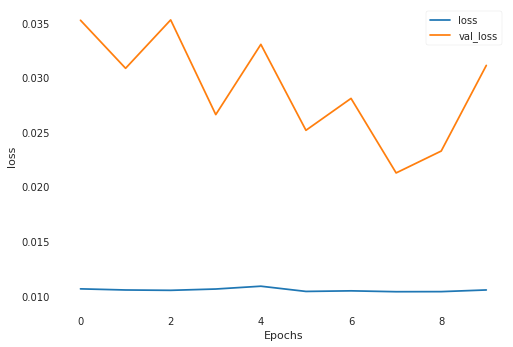

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0149 - val_loss: 0.0526
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0132 - val_loss: 0.0482
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0101 - val_loss: 0.0469
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0102 - val_loss: 0.0355
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0102 - val_loss: 0.0527
Epoch 6/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0102 - val_loss: 0.0378
Epoch 00006: early stopping
loss cuts = tf.Tensor([0.02680099], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.012991467, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02280083], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.037629586, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02566806], shape=(1,), dtype=float32)
mod

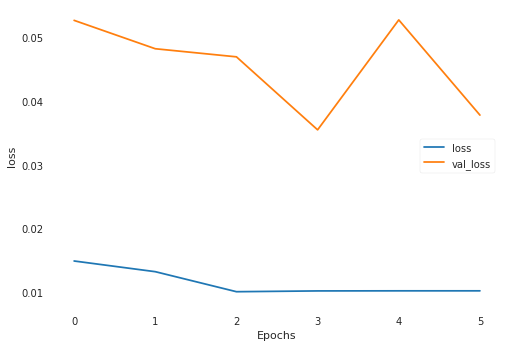

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0105 - val_loss: 0.0306
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0104 - val_loss: 0.0312
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0100 - val_loss: 0.0476
Epoch 00003: early stopping
loss cuts = tf.Tensor([0.02349468], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.08784221, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02223179], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.103452146, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02175042], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.109737925, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02327778], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.090432435, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02520445], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.068741806, shape=(), dtype=float32

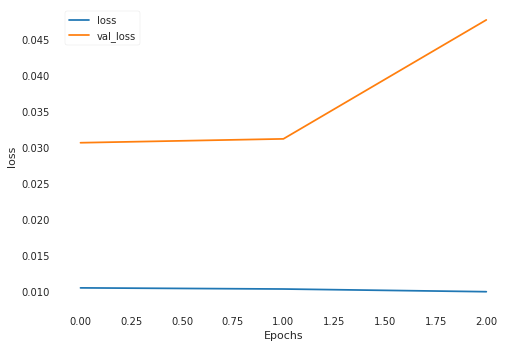

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0100 - val_loss: 0.0709
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0105 - val_loss: 0.0888
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0102 - val_loss: 0.0381
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0102 - val_loss: 0.0861
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0104 - val_loss: 0.0702
Epoch 00005: early stopping
loss cuts = tf.Tensor([0.0403499], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(5.1917515, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.04467442], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(4.8050885, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.0401434], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(5.210589, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03896087], shape=(1,), dtyp

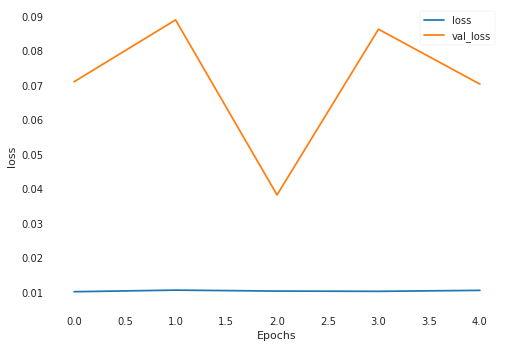

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0099 - val_loss: 0.0501
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0104 - val_loss: 0.0355
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0113 - val_loss: 0.0418
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0108 - val_loss: 0.0374
Epoch 00004: early stopping
loss cuts = tf.Tensor([0.05561876], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.003890664, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.0607875], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.027473032, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.05651055], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.0064337924, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.05722673], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.008936797, shape=(), dtype=float32)
loss cuts = tf.Tenso

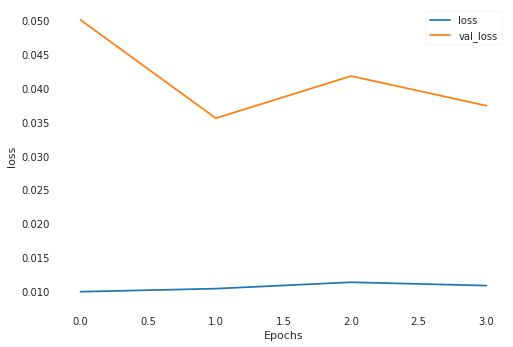

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0104 - val_loss: 0.0312
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0103 - val_loss: 0.0309
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0099 - val_loss: 0.0443
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0101 - val_loss: 0.0314
Epoch 00004: early stopping
loss cuts = tf.Tensor([0.01080007], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(1.7795519, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.01146072], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(1.7444748, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.01233136], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(1.6987805, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.0136582], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(1.6303103, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.0132

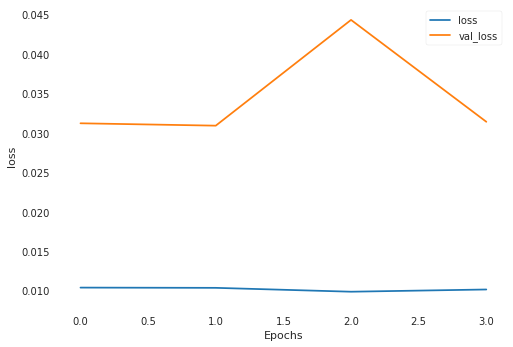

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0102 - val_loss: 0.0479
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0098 - val_loss: 0.0428
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0098 - val_loss: 0.0363
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0525 - val_loss: 0.3414
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0302 - val_loss: 0.0614
Epoch 00005: early stopping
loss cuts = tf.Tensor([0.04190426], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.028590431, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.04140142], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.032092538, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03615945], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.08064644, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03609537], shape=(1

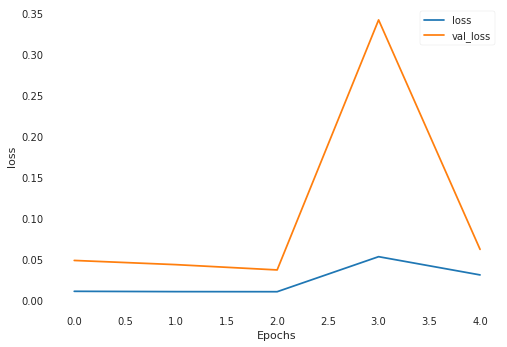

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0131 - val_loss: 0.0399
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0108 - val_loss: 0.0346
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0101 - val_loss: 0.0406
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0100 - val_loss: 0.0283
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0098 - val_loss: 0.0348
Epoch 6/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0095 - val_loss: 0.0275
Epoch 7/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0096 - val_loss: 0.0315
Epoch 8/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0097 - val_loss: 0.0268
Epoch 9/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0095 - val_loss: 0.0330
Epoch 10/10
880/880 [=================

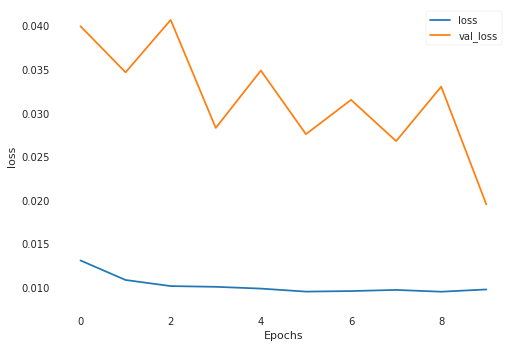

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0096 - val_loss: 0.0429
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0095 - val_loss: 0.0338
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0093 - val_loss: 0.0670
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0092 - val_loss: 0.0662
Epoch 00004: early stopping
loss cuts = tf.Tensor([0.02834976], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(1.5818614, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02859647], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(1.5694741, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02946367], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(1.526318, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02814952], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(1.591951, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03069

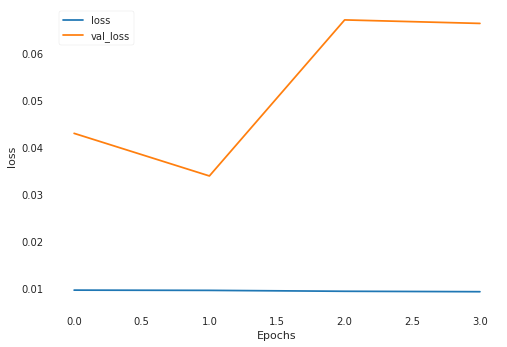

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0092 - val_loss: 0.0595
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0095 - val_loss: 0.0708
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0098 - val_loss: 0.0485
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0091 - val_loss: 0.0533
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0091 - val_loss: 0.0548
Epoch 00005: early stopping
loss cuts = tf.Tensor([0.02338613], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.1415875, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02062002], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.1862814, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.01891962], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.21679378, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.01919779], shape=(1,), 

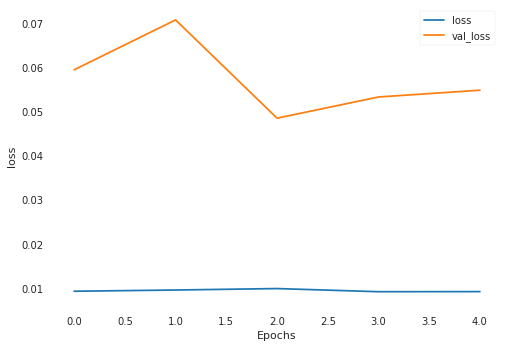

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0096 - val_loss: 0.0558
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0098 - val_loss: 0.0538
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0097 - val_loss: 0.0560
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0097 - val_loss: 0.0499
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0100 - val_loss: 0.0451
Epoch 6/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0099 - val_loss: 0.0463
Epoch 7/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0099 - val_loss: 0.0450
Epoch 8/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0096 - val_loss: 0.0450
Epoch 9/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0101 - val_loss: 0.0481
Epoch 10/10
880/880 [=================

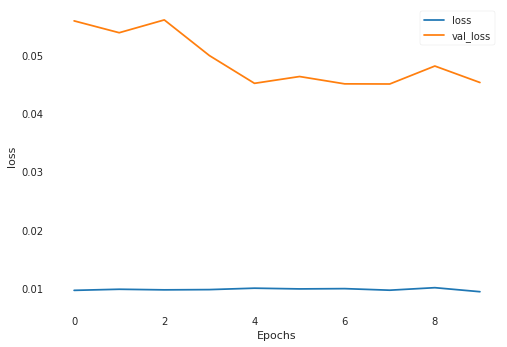

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0096 - val_loss: 0.0202
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0099 - val_loss: 0.0420
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0114 - val_loss: 0.0230
Epoch 00003: early stopping
loss cuts = tf.Tensor([0.03031812], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.08622299, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03035382], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.085804254, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02645305], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.13759567, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02686336], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.13157502, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02658581], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.13563287, shape=(), dtype=float32)
l

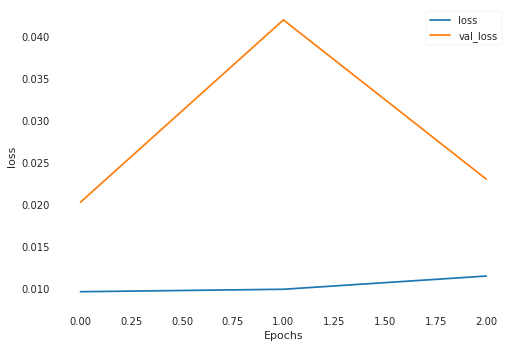

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0097 - val_loss: 0.0676
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0095 - val_loss: 0.0732
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0092 - val_loss: 0.0693
Epoch 00003: early stopping
loss cuts = tf.Tensor([0.01279815], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(7.504629, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.01345369], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(7.4329677, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.01553921], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(7.2072735, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.01475294], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(7.291956, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.01340061], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(7.4387593, shape=(), dtype=float32)
loss cuts

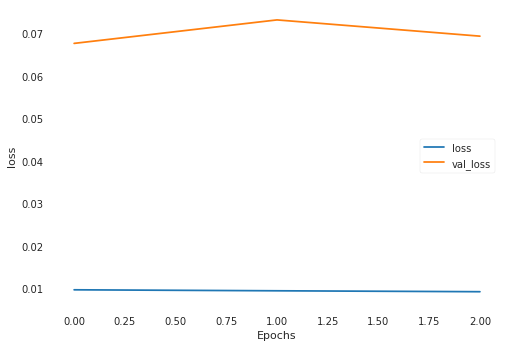

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0094 - val_loss: 0.0751
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0107 - val_loss: 0.0551
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0099 - val_loss: 0.0687
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0104 - val_loss: 0.0817
Epoch 00004: early stopping
loss cuts = tf.Tensor([0.0071397], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.257258, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.00696234], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.2608689, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.00615934], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.27753216, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.00693505], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.2614267, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.0075

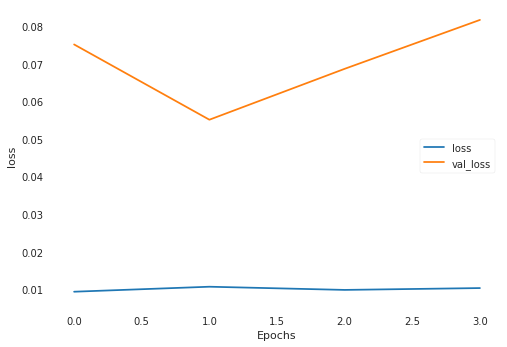

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0098 - val_loss: 0.1194
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0492 - val_loss: 0.1485
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0126 - val_loss: 0.0487
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0102 - val_loss: 0.0456
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0094 - val_loss: 0.0392
Epoch 6/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0091 - val_loss: 0.0399
Epoch 7/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0088 - val_loss: 0.0339
Epoch 8/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0090 - val_loss: 0.0325
Epoch 9/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0090 - val_loss: 0.0310
Epoch 10/10
880/880 [=================

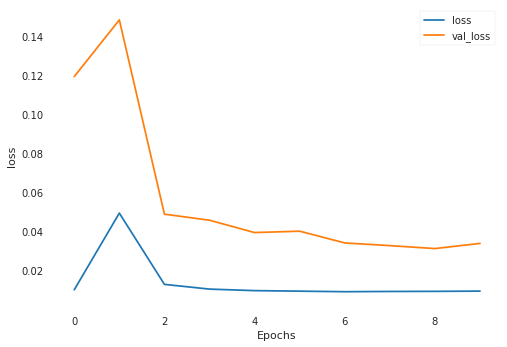

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0086 - val_loss: 0.1045
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0095 - val_loss: 0.0673
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0091 - val_loss: 0.0566
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0088 - val_loss: 0.0874
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0093 - val_loss: 0.0639
Epoch 00005: early stopping
loss cuts = tf.Tensor([0.04028842], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.12657115, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.04021026], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.12546131, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03832173], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.10013087, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03652785], shape=(1,)

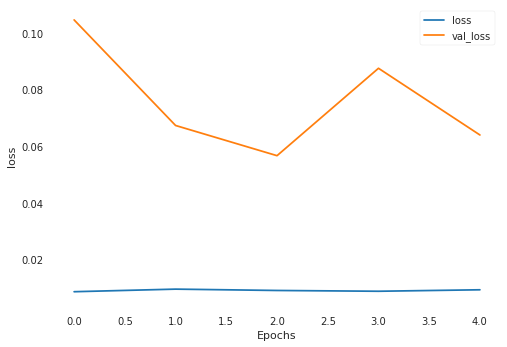

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0090 - val_loss: 0.0971
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0102 - val_loss: 0.0882
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0091 - val_loss: 0.0811
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0090 - val_loss: 0.2746
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0092 - val_loss: 0.0709
Epoch 6/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0097 - val_loss: 0.0680
Epoch 7/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0091 - val_loss: 0.0791
Epoch 8/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0099 - val_loss: 0.0717
Epoch 00008: early stopping
loss cuts = tf.Tensor([0.01777924], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.89191985, shape=(), dty

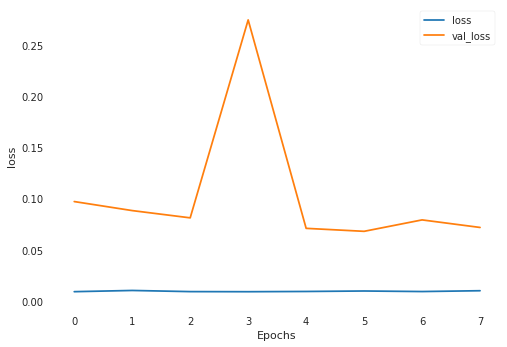

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0220 - val_loss: 0.1646
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0123 - val_loss: 0.0828
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0092 - val_loss: 0.0791
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0088 - val_loss: 0.0945
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0087 - val_loss: 0.0884
Epoch 00005: early stopping
loss cuts = tf.Tensor([0.01609235], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.012339973, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.01680108], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.015690055, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.01686588], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.016016398, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.01574392], shape=(

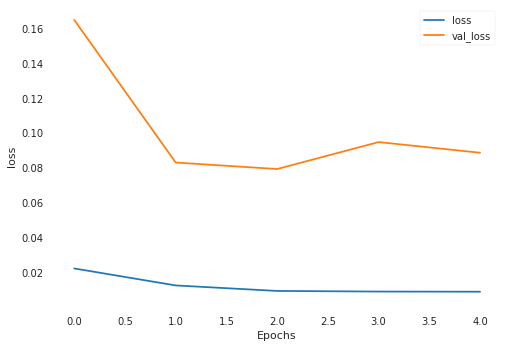

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0096 - val_loss: 0.1089
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0089 - val_loss: 0.1126
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0102 - val_loss: 0.1180
Epoch 00003: early stopping
loss cuts = tf.Tensor([0.02064415], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.0018948598, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.0195286], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.0043350514, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.0167961], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.014518088, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.01852385], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.007384998, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.01794019], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.00952756, shape=(), dtype=float32

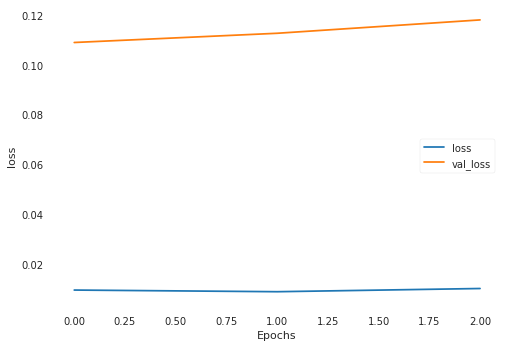

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0092 - val_loss: 0.0452
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0089 - val_loss: 0.0733
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0089 - val_loss: 0.0867
Epoch 00003: early stopping
loss cuts = tf.Tensor([0.01222926], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.020904904, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.01164124], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.017642414, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.01273899], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.023956766, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.01356071], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.02931433, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.0135625], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.029326558, shape=(), dtype=float32)

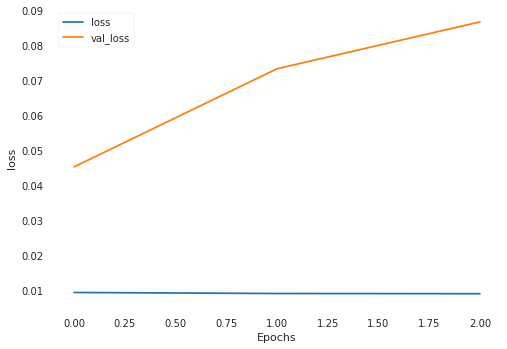

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0094 - val_loss: 0.0857
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0095 - val_loss: 0.0443
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0094 - val_loss: 0.0693
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0090 - val_loss: 0.0631
Epoch 00004: early stopping
loss cuts = tf.Tensor([0.05362571], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.29188058, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.05334022], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.2980828, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.05282627], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.3094123, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.05466643], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.26982328, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.0

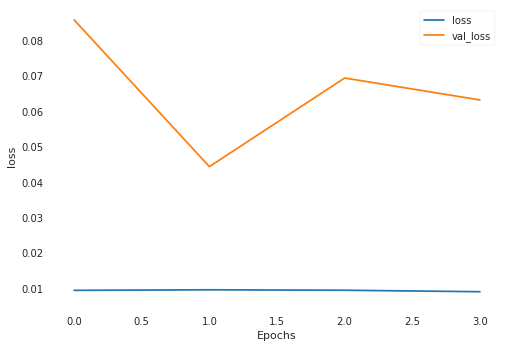

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0092 - val_loss: 0.0541
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0092 - val_loss: 0.0952
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0092 - val_loss: 0.0560
Epoch 00003: early stopping
loss cuts = tf.Tensor([0.05664803], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.054270633, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.05517431], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.041406684, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.05296875], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.025400376, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.05299742], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.025583513, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.05953758], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.084536545, shape=(), dtype=float3

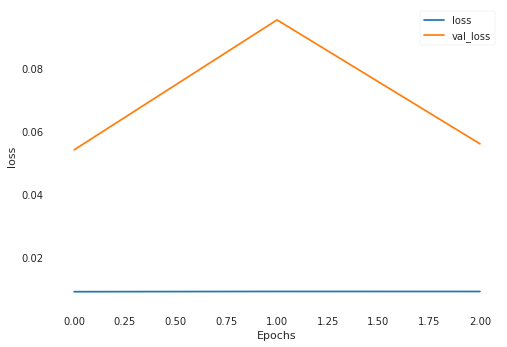

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0096 - val_loss: 0.1724
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0096 - val_loss: 0.2196
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0094 - val_loss: 0.1739
Epoch 00003: early stopping
loss cuts = tf.Tensor([0.01438619], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(11.103616, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.01469517], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(11.06247, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.01579703], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(10.916364, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.01417664], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(11.131563, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.01280268], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(11.315681, shape=(), dtype=float32)
loss cut

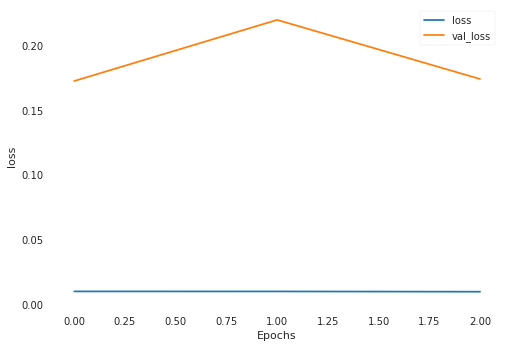

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0103 - val_loss: 0.1231
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0098 - val_loss: 0.1262
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0100 - val_loss: 0.3086
Epoch 00003: early stopping
loss cuts = tf.Tensor([0.02967405], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.17522004, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03439318], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.10511231, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.034702], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.10114566, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03819478], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.06159253, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03646221], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.07999264, shape=(), dtype=float32)
loss

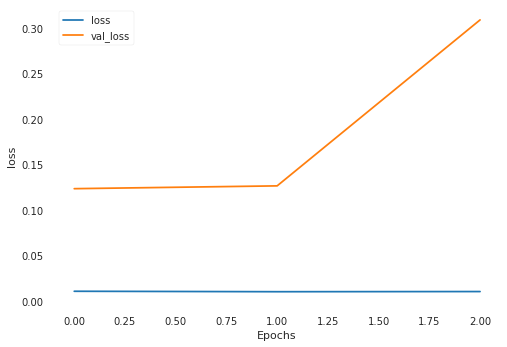

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0261 - val_loss: 0.1207
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0098 - val_loss: 0.1947
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0093 - val_loss: 0.1860
Epoch 00003: early stopping
loss cuts = tf.Tensor([0.02884471], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(6.412373, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02995887], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(6.3000164, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03303279], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(5.9951763, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.0334172], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(5.957586, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03182008], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(6.1145372, shape=(), dtype=float32)
loss cuts 

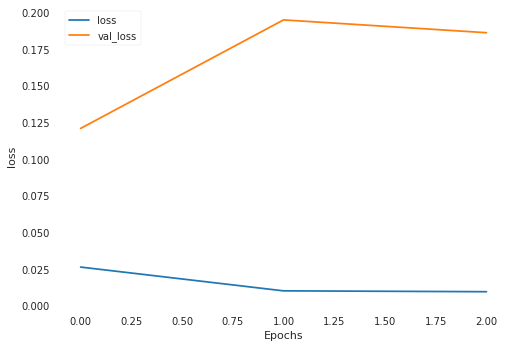

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0096 - val_loss: 0.0800
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0089 - val_loss: 0.1019
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0093 - val_loss: 0.0836
Epoch 00003: early stopping
loss cuts = tf.Tensor([0.02817892], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(12.506277, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03235281], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(11.922821, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03002491], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(12.246512, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03039901], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(12.194201, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02970481], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(12.291361, shape=(), dtype=float32)
loss cu

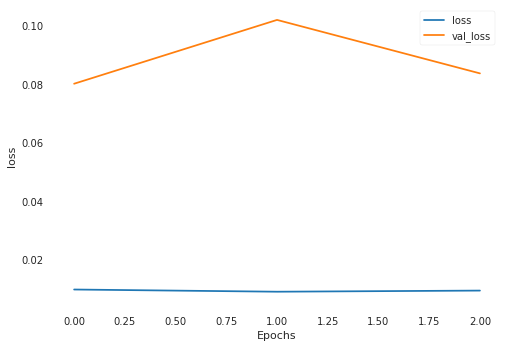

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0089 - val_loss: 0.0672
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0090 - val_loss: 0.0540
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0090 - val_loss: 0.0740
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0085 - val_loss: 0.0497
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0087 - val_loss: 0.0457
Epoch 6/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0090 - val_loss: 0.0491
Epoch 7/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0090 - val_loss: 0.0357
Epoch 8/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0088 - val_loss: 0.0516
Epoch 9/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0091 - val_loss: 0.0446
Epoch 00009: early stopping
loss cuts 

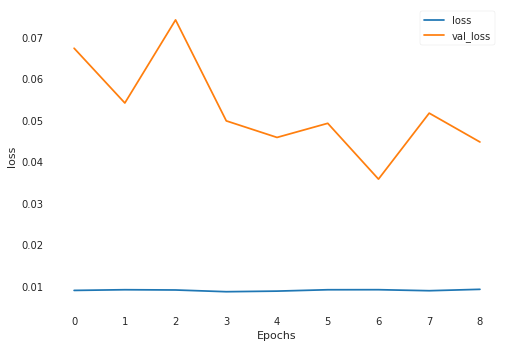

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0089 - val_loss: 0.0808
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0090 - val_loss: 0.0970
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0093 - val_loss: 0.0918
Epoch 00003: early stopping
loss cuts = tf.Tensor([0.02147279], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(3.848391, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02412416], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(3.6431515, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02655359], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(3.4600303, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02904338], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(3.2772582, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.0297458], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(3.2265906, shape=(), dtype=float32)
loss cuts

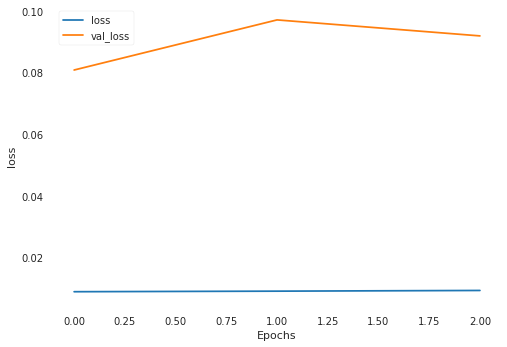

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0095 - val_loss: 0.0411
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0096 - val_loss: 0.0558
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0092 - val_loss: 0.0288
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0089 - val_loss: 0.0442
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0091 - val_loss: 0.0433
Epoch 00005: early stopping
loss cuts = tf.Tensor([0.02818465], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(1.4073242, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03040409], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(1.3039774, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02900994], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(1.3684349, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03040545], shape=(1,), d

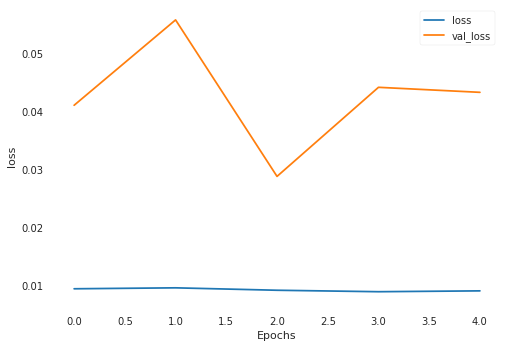

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0093 - val_loss: 0.0394
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0088 - val_loss: 0.0831
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0093 - val_loss: 0.0774
Epoch 00003: early stopping
loss cuts = tf.Tensor([0.02279422], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.35297322, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02805327], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.23905708, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02596365], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.28167105, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02490023], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.3046988, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02498861], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.30275047, shape=(), dtype=float32)
los

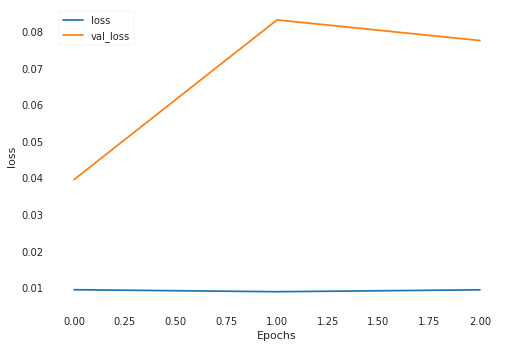

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0088 - val_loss: 0.0695
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0096 - val_loss: 0.0765
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0089 - val_loss: 0.0708
Epoch 00003: early stopping
loss cuts = tf.Tensor([0.04688735], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.8413533, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.04564678], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.8874853, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.04639919], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.8593589, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.04549042], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.8933873, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.04529661], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.90072966, shape=(), dtype=float32)
loss c

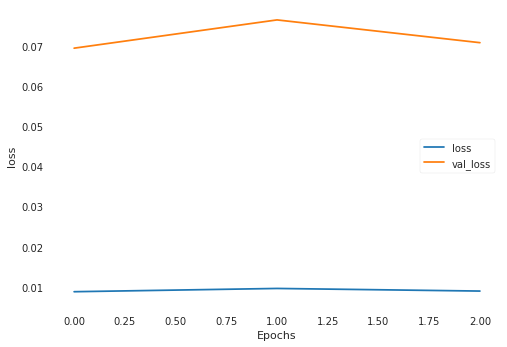

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0097 - val_loss: 0.1057
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0093 - val_loss: 0.0820
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0087 - val_loss: 0.0950
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0356 - val_loss: 0.1195
Epoch 00004: early stopping
loss cuts = tf.Tensor([0.05316961], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(1.081926, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.05171152], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(1.1434424, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.05195607], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(1.1330061, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.05072504], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(1.1860259, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.0560

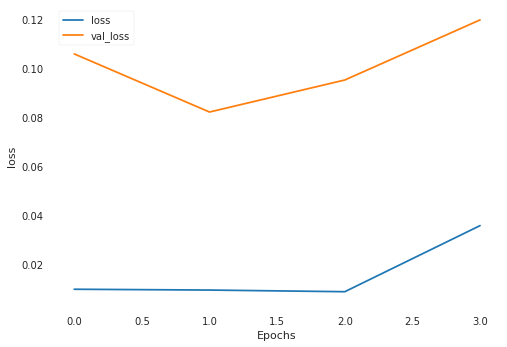

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0167 - val_loss: 0.0966
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0096 - val_loss: 0.0981
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0086 - val_loss: 0.0937
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0085 - val_loss: 0.0752
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0086 - val_loss: 0.0921
Epoch 6/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0083 - val_loss: 0.0999
Epoch 00006: early stopping
loss cuts = tf.Tensor([0.03854526], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.0524844, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.04606344], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.006198608, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.0413352], shape=(1,), dtype=float32)
model2

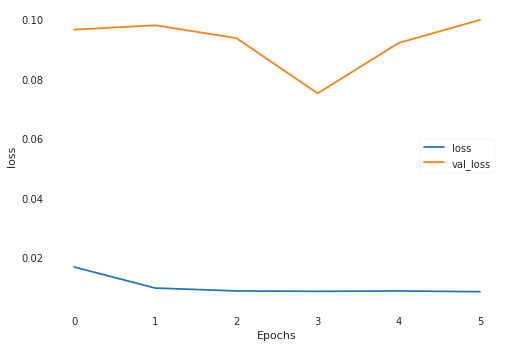

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0087 - val_loss: 0.0458
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0087 - val_loss: 0.0606
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0082 - val_loss: 0.0560
Epoch 00003: early stopping
loss cuts = tf.Tensor([0.04037215], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.20083836, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.04141658], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.18255226, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03952881], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.21624066, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03550962], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.29746178, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03534709], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.30101815, shape=(), dtype=float32)
lo

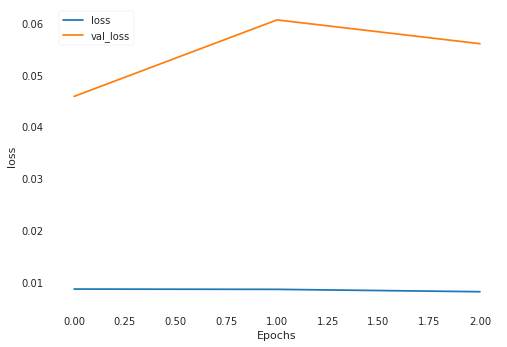

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0090 - val_loss: 0.0919
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0089 - val_loss: 0.0944
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0090 - val_loss: 0.1034
Epoch 00003: early stopping
loss cuts = tf.Tensor([0.03605802], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(1.8040456, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03801475], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(1.7004493, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03504674], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(1.8587861, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03474413], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(1.8753257, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03808554], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(1.6967597, shape=(), dtype=float32)
loss cu

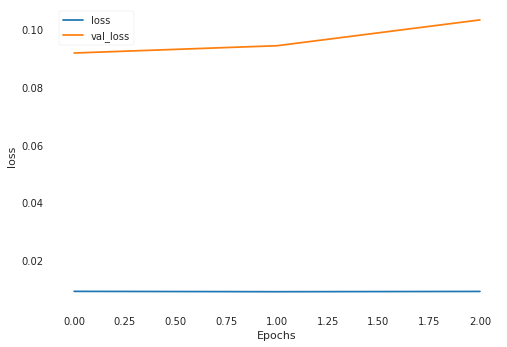

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0093 - val_loss: 0.0348
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0084 - val_loss: 0.0383
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0081 - val_loss: 0.0780
Epoch 00003: early stopping
loss cuts = tf.Tensor([0.04417691], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.18132302, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.04131219], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.1358114, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.04534387], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.20174436, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.04722113], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.23688158, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.04439879], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.18512192, shape=(), dtype=float32)
los

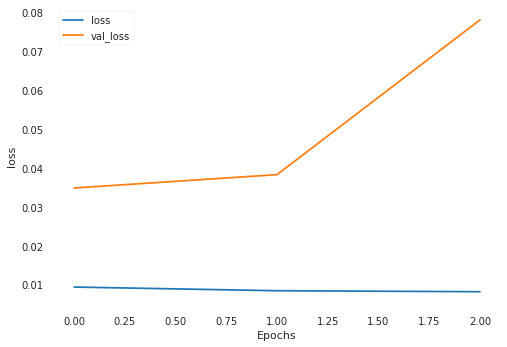

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0087 - val_loss: 0.1921
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0087 - val_loss: 0.1876
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0093 - val_loss: 0.1194
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0088 - val_loss: 0.1422
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0090 - val_loss: 0.1969
Epoch 00005: early stopping
loss cuts = tf.Tensor([0.00948057], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.012185657, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.00872318], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.015759407, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.00863688], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.016195703, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.00799287], shape=(

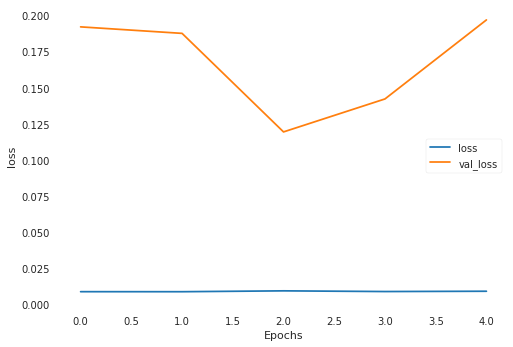

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0097 - val_loss: 0.2561
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0086 - val_loss: 0.1535
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0091 - val_loss: 0.2241
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0119 - val_loss: 0.1551
Epoch 00004: early stopping
loss cuts = tf.Tensor([0.01852584], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(7.1288137, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.01871229], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(7.1089144, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02008262], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(6.9635205, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.0162476], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(7.3742037, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.0140

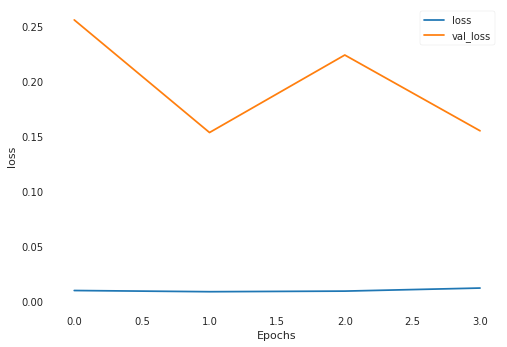

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0113 - val_loss: 0.1044
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0092 - val_loss: 0.1267
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0088 - val_loss: 0.1255
Epoch 00003: early stopping
loss cuts = tf.Tensor([0.03744134], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.061914805, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03316936], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.02669539, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03811771], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.06882972, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03284586], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.024623012, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03412852], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.03333195, shape=(), dtype=float32)


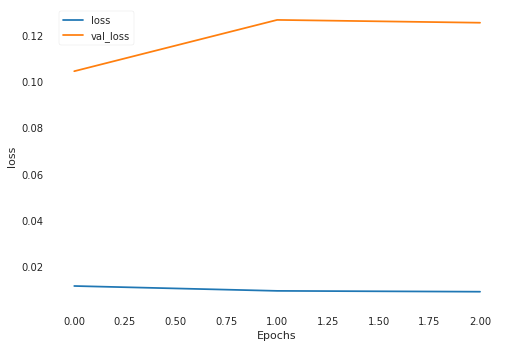

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0090 - val_loss: 0.0861
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0091 - val_loss: 0.1291
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0096 - val_loss: 0.1193
Epoch 00003: early stopping
loss cuts = tf.Tensor([0.01751473], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(5.5781035, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.01711145], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(5.6162667, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.01454397], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(5.862287, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.01573832], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(5.7471867, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.01922243], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(5.417939, shape=(), dtype=float32)
loss cuts

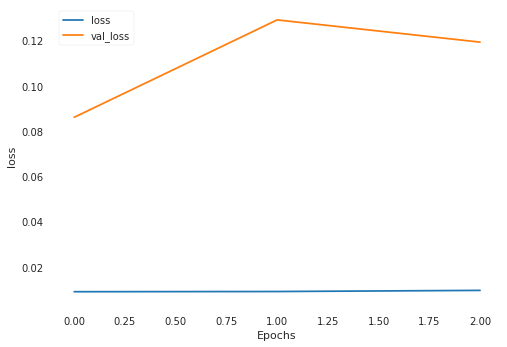

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0097 - val_loss: 0.2186
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0086 - val_loss: 0.2271
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0091 - val_loss: 0.2390
Epoch 00003: early stopping
loss cuts = tf.Tensor([0.02940203], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(37.8234, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03163791], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(37.275364, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.0283326], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(38.086937, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02793288], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(38.185673, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03021498], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(37.623672, shape=(), dtype=float32)
loss cuts 

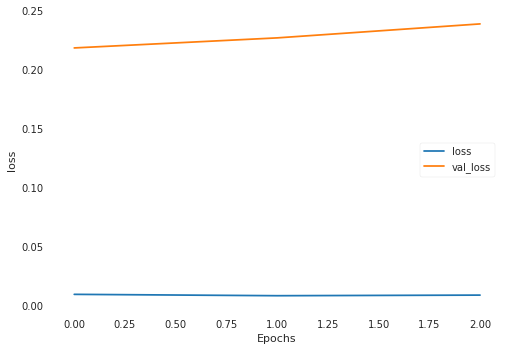

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0096 - val_loss: 0.2638
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0093 - val_loss: 0.2642
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0103 - val_loss: 0.1614
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0093 - val_loss: 0.3990
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0109 - val_loss: 0.1686
Epoch 00005: early stopping
loss cuts = tf.Tensor([0.05281122], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.061320912, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.05699019], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.10970008, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.05673549], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.1063517, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.05354061], shape=(1,)

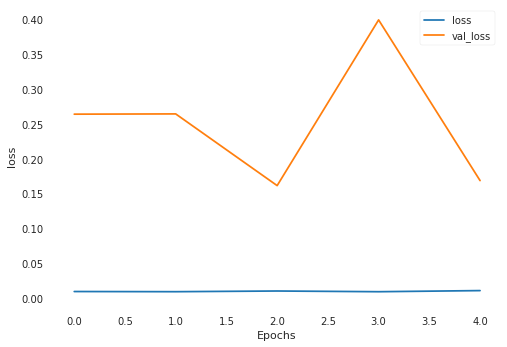

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0097 - val_loss: 0.1616
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0094 - val_loss: 0.1429
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0092 - val_loss: 0.1482
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0092 - val_loss: 0.1082
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0129 - val_loss: 0.1139
Epoch 6/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0088 - val_loss: 0.1181
Epoch 00006: early stopping
loss cuts = tf.Tensor([0.02347301], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.0048247087, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02285953], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.0032707609, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03070619], shape=(1,), dtype=float32)
m

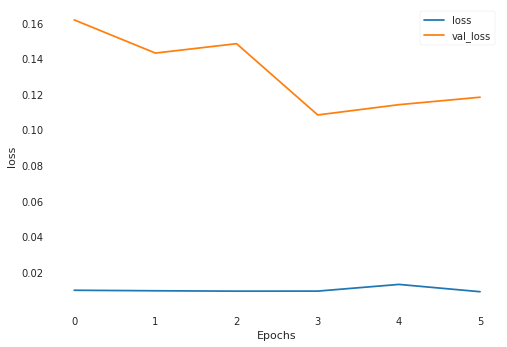

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0085 - val_loss: 0.0907
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0086 - val_loss: 0.0959
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0087 - val_loss: 0.0951
Epoch 00003: early stopping
loss cuts = tf.Tensor([0.05645304], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.14368705, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.0529765], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.09580876, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.05201614], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.084287316, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.05228573], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.08744714, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.05273233], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.09280963, shape=(), dtype=float32)
lo

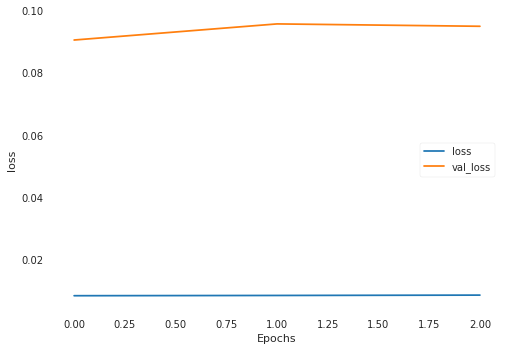

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0093 - val_loss: 0.0605
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0085 - val_loss: 0.0759
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0097 - val_loss: 0.0733
Epoch 00003: early stopping
loss cuts = tf.Tensor([0.07223872], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(1.9885958, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.06397925], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(1.5499915, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.0633203], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(1.5173496, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.06317111], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(1.5100076, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.06215388], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(1.4604216, shape=(), dtype=float32)
loss cut

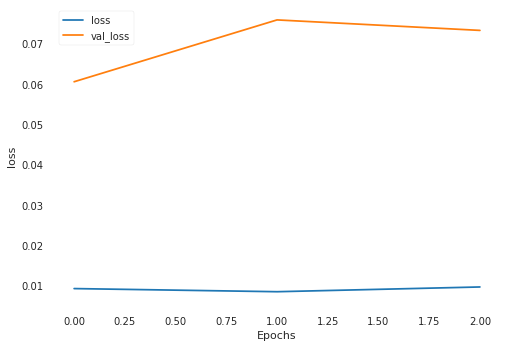

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0090 - val_loss: 0.2055
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0089 - val_loss: 0.2324
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0087 - val_loss: 0.2360
Epoch 00003: early stopping
loss cuts = tf.Tensor([0.04649709], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(11.633718, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.04913258], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(11.276928, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.05181713], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(10.91921, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.04679621], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(11.592945, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.04877336], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(11.3252325, shape=(), dtype=float32)
loss cu

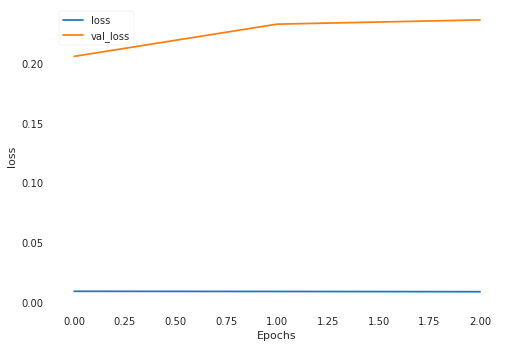

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0268 - val_loss: 0.3348
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0171 - val_loss: 0.1642
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0093 - val_loss: 0.1031
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0088 - val_loss: 0.0844
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0083 - val_loss: 0.1057
Epoch 6/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0089 - val_loss: 0.0999
Epoch 00006: early stopping
loss cuts = tf.Tensor([0.05211743], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(5.0969896, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.05150833], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(5.1521435, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.05545129], shape=(1,), dtype=float32)
model2 

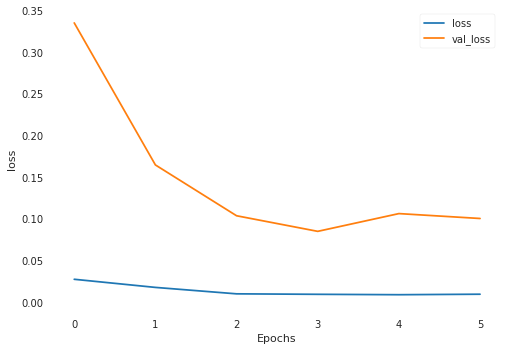

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0084 - val_loss: 0.1668
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0088 - val_loss: 0.1586
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0085 - val_loss: 0.1439
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0085 - val_loss: 0.1419
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0087 - val_loss: 0.1290
Epoch 6/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0087 - val_loss: 0.1554
Epoch 7/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0090 - val_loss: 0.1384
Epoch 00007: early stopping
loss cuts = tf.Tensor([0.04796371], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.09565053, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.05039262], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.1

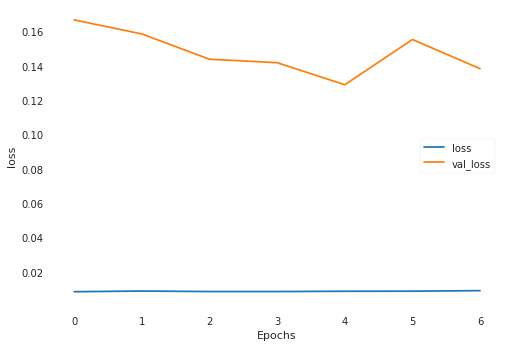

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0089 - val_loss: 0.2036
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0098 - val_loss: 0.2053
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0098 - val_loss: 0.1259
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0093 - val_loss: 0.1099
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0087 - val_loss: 0.1106
Epoch 6/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0090 - val_loss: 0.1105
Epoch 00006: early stopping
loss cuts = tf.Tensor([0.02303372], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(3.6382122, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02156316], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(3.7512755, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.0214612], shape=(1,), dtype=float32)
model2 l

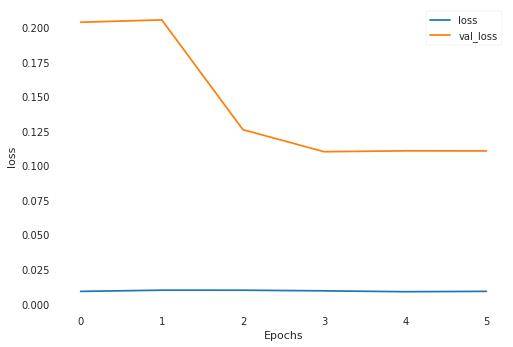

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0088 - val_loss: 0.3391
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0133 - val_loss: 0.1272
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0105 - val_loss: 0.0733
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0082 - val_loss: 0.1041
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0084 - val_loss: 0.0719
Epoch 6/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0084 - val_loss: 0.1007
Epoch 7/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0087 - val_loss: 0.0832
Epoch 00007: early stopping
loss cuts = tf.Tensor([0.03049484], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.21336652, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03533234], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.1

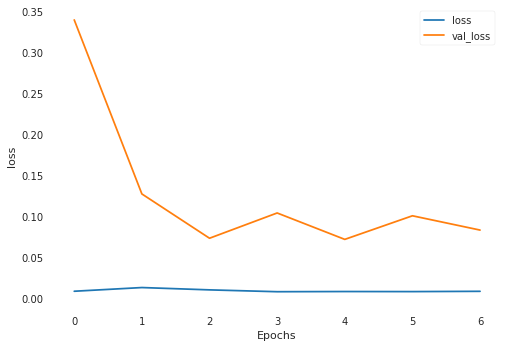

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0088 - val_loss: 0.0722
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0193 - val_loss: 0.0903
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0087 - val_loss: 0.0667
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0085 - val_loss: 0.0595
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0081 - val_loss: 0.0451
Epoch 6/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0079 - val_loss: 0.0951
Epoch 7/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0086 - val_loss: 0.0729
Epoch 00007: early stopping
loss cuts = tf.Tensor([0.08292986], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.48103327, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.07713611], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.6

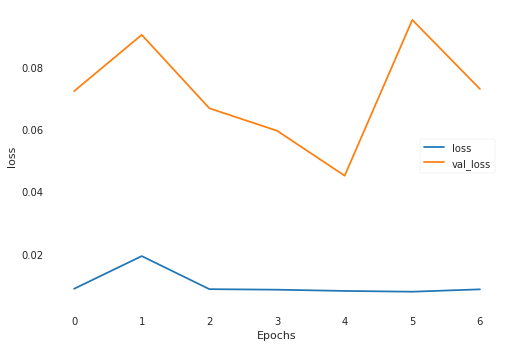

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0085 - val_loss: 0.2175
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0083 - val_loss: 0.2355
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0088 - val_loss: 0.2297
Epoch 00003: early stopping
loss cuts = tf.Tensor([0.04409202], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.30332768, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03982404], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.40463784, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.04183216], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.3551552, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.04613561], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.25997767, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.04511973], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.28110957, shape=(), dtype=float32)
los

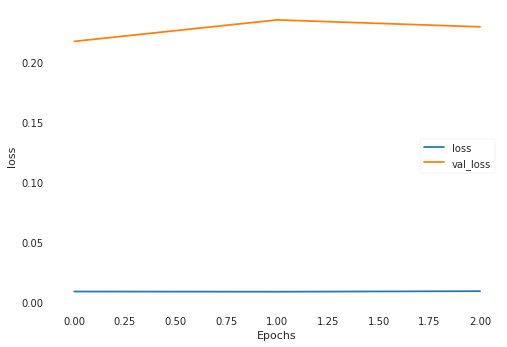

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0093 - val_loss: 0.0693
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0087 - val_loss: 0.0644
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0083 - val_loss: 0.0500
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0084 - val_loss: 0.0588
Epoch 5/10
880/880 [==============================] - 1s 2ms/sample - loss: 0.0085 - val_loss: 0.0501
Epoch 00005: early stopping
loss cuts = tf.Tensor([0.0349048], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(1.0038118, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03566308], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.97365266, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03264163], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(1.0965599, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03119148], shape=(1,), d

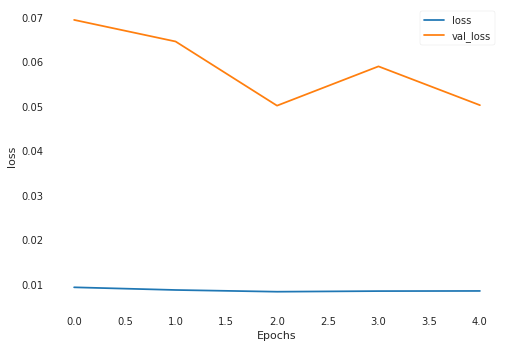

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0088 - val_loss: 0.0862
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0088 - val_loss: 0.0746
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0085 - val_loss: 0.0879
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0088 - val_loss: 0.0797
Epoch 00004: early stopping
loss cuts = tf.Tensor([0.01638055], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.6763236, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.01536912], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.7100044, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.0176396], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.6355404, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02153394], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.5174229, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.0256

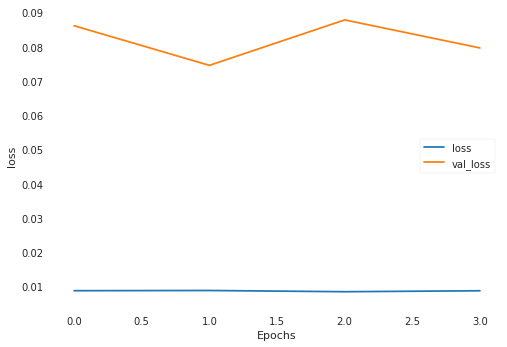

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0090 - val_loss: 0.0989
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0087 - val_loss: 0.0476
Epoch 3/10
880/880 [==============================] - 1s 2ms/sample - loss: 0.0086 - val_loss: 0.0595
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0089 - val_loss: 0.0740
Epoch 00004: early stopping
loss cuts = tf.Tensor([0.05102944], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.14395288, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.04594691], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.23142041, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.0445978], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.25810865, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.04679529], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.2153834, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.0

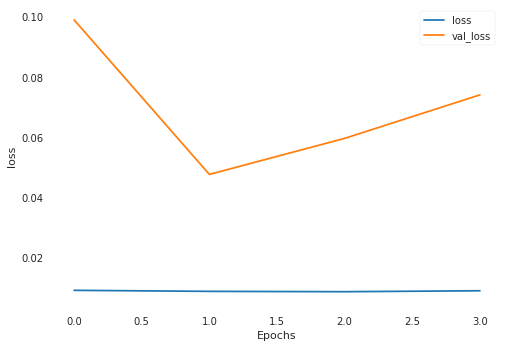

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0092 - val_loss: 0.0873
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0089 - val_loss: 0.0806
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0088 - val_loss: 0.0834
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0088 - val_loss: 0.0977
Epoch 00004: early stopping
loss cuts = tf.Tensor([0.02359829], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.01487567, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02309617], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.012526853, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02280743], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.011267545, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02778264], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.04229305, shape=(), dtype=float32)
loss cuts = tf.Tensor(

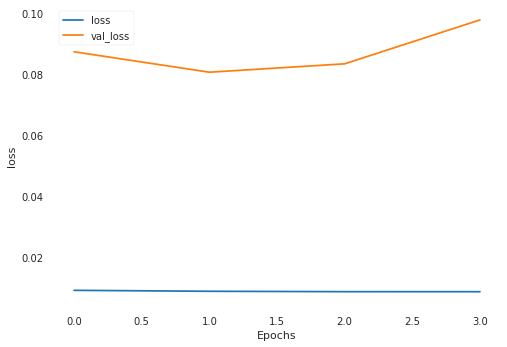

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0088 - val_loss: 0.0521
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0088 - val_loss: 0.0299
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0091 - val_loss: 0.0436
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0100 - val_loss: 0.0286
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0093 - val_loss: 0.0353
Epoch 6/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0082 - val_loss: 0.0750
Epoch 00006: early stopping
loss cuts = tf.Tensor([0.0476219], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(10.224402, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.04541734], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(10.508317, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.05069857], shape=(1,), dtype=float32)
model2 l

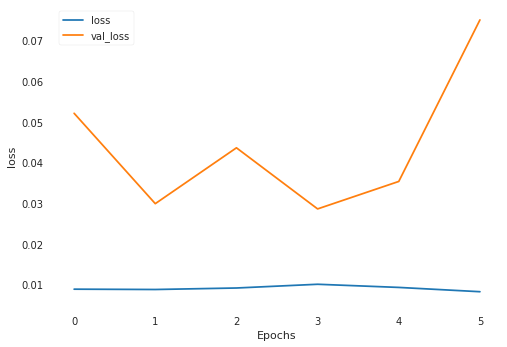

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0086 - val_loss: 0.0746
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0092 - val_loss: 0.1044
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0086 - val_loss: 0.0778
Epoch 00003: early stopping
loss cuts = tf.Tensor([0.03058806], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.115006596, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03499205], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.063024275, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03724815], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.042404857, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03818263], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.035056833, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03868507], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.031394884, shape=(), dtype=float3

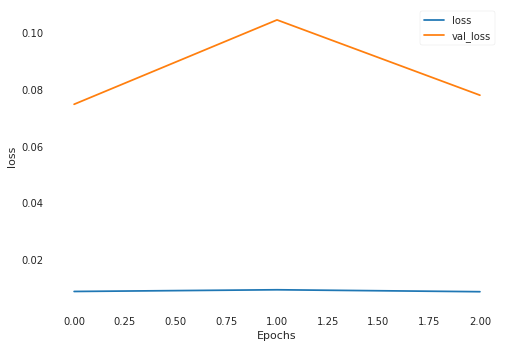

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0088 - val_loss: 0.0849
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0084 - val_loss: 0.0782
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0085 - val_loss: 0.0777
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0086 - val_loss: 0.0730
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0082 - val_loss: 0.0685
Epoch 6/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0084 - val_loss: 0.0798
Epoch 7/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0139 - val_loss: 0.2179
Epoch 00007: early stopping
loss cuts = tf.Tensor([0.03865059], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(5.650074, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03451191], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(6.050

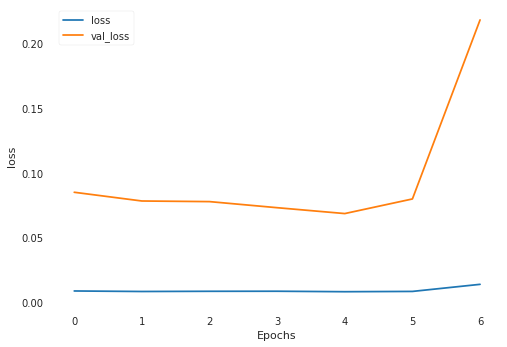

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0133 - val_loss: 0.2824
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0082 - val_loss: 0.2835
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0080 - val_loss: 0.2410
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0082 - val_loss: 0.2877
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0081 - val_loss: 0.2587
Epoch 00005: early stopping
loss cuts = tf.Tensor([0.03277911], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(45.17942, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03315502], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(45.078407, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03147811], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(45.52988, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03239584], shape=(1,), dty

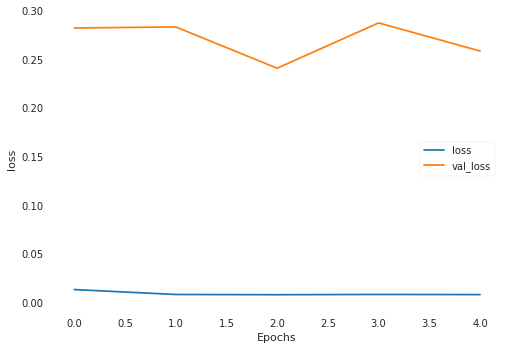

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0081 - val_loss: 0.2007
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0085 - val_loss: 0.1463
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0080 - val_loss: 0.1973
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0093 - val_loss: 0.1756
Epoch 00004: early stopping
loss cuts = tf.Tensor([0.04135666], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(2.714707, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.0431885], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(2.5953212, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.04226867], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(2.6549335, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.04419168], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(2.5310788, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.04108

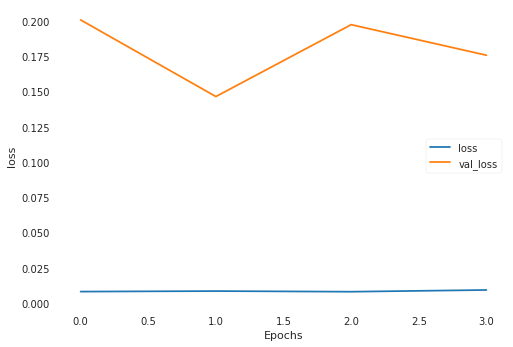

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0092 - val_loss: 0.2347
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0088 - val_loss: 0.1786
Epoch 3/10
880/880 [==============================] - 1s 2ms/sample - loss: 0.0088 - val_loss: 0.1725
Epoch 4/10
880/880 [==============================] - 1s 2ms/sample - loss: 0.0096 - val_loss: 0.1236
Epoch 5/10
880/880 [==============================] - 1s 2ms/sample - loss: 0.0086 - val_loss: 0.1688
Epoch 6/10
880/880 [==============================] - 1s 2ms/sample - loss: 0.0078 - val_loss: 0.1058
Epoch 7/10
880/880 [==============================] - 1s 2ms/sample - loss: 0.0103 - val_loss: 0.1514
Epoch 8/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0261 - val_loss: 0.1598
Epoch 00008: early stopping
loss cuts = tf.Tensor([0.03824944], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(5.6882796, shape=(), dtyp

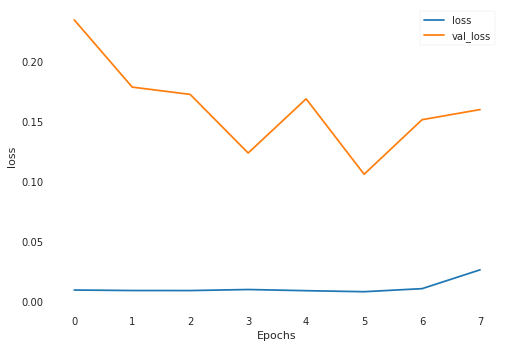

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0128 - val_loss: 0.1289
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0082 - val_loss: 0.1256
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0079 - val_loss: 0.1302
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0076 - val_loss: 0.1301
Epoch 00004: early stopping
loss cuts = tf.Tensor([0.08143179], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.0035498152, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.0791172], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.00017658417, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.08195277], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.004899957, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.08078487], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.00217546, shape=(), dtype=float32)
loss cuts = tf.Tens

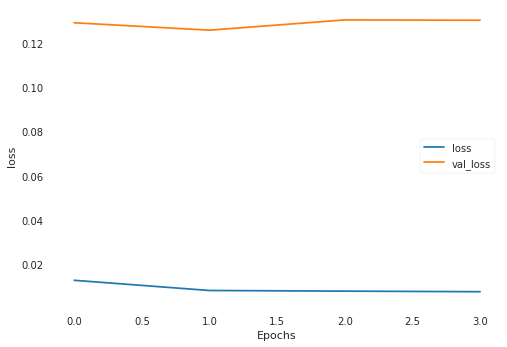

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0080 - val_loss: 0.2597
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0076 - val_loss: 0.2644
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0076 - val_loss: 0.2267
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0076 - val_loss: 0.2262
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0078 - val_loss: 0.2336
Epoch 6/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0076 - val_loss: 0.2179
Epoch 7/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0073 - val_loss: 0.2239
Epoch 8/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0079 - val_loss: 0.2205
Epoch 00008: early stopping
loss cuts = tf.Tensor([0.04666597], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(34.706295, shape=(), dtyp

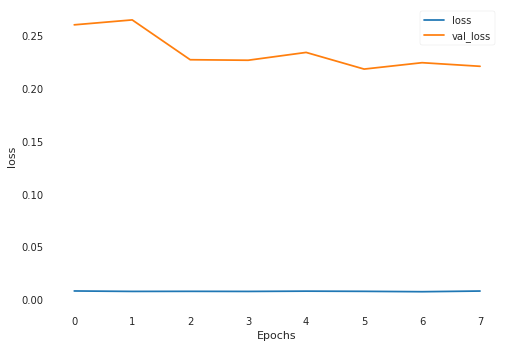

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0081 - val_loss: 0.0806
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0079 - val_loss: 0.0900
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0091 - val_loss: 0.0865
Epoch 00003: early stopping
loss cuts = tf.Tensor([0.03763828], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(1.9473516, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03512647], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(2.0900822, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03948039], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(1.8458844, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03818225], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(1.9171057, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03577748], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(2.052605, shape=(), dtype=float32)
loss cut

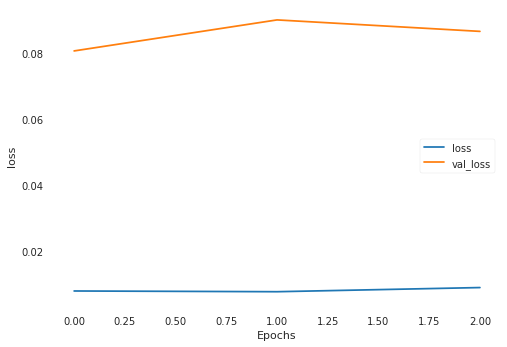

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0076 - val_loss: 0.1031
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0077 - val_loss: 0.0925
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0080 - val_loss: 0.1013
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0081 - val_loss: 0.1037
Epoch 00004: early stopping
loss cuts = tf.Tensor([0.07935514], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.34422746, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.08196294], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.40814847, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.07943966], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.34621388, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.07747068], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.30142274, shape=(), dtype=float32)
loss cuts = tf.Tensor([0

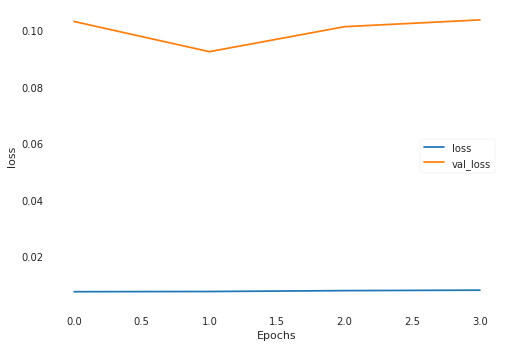

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0081 - val_loss: 0.0594
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0087 - val_loss: 0.0604
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0079 - val_loss: 0.0505
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0077 - val_loss: 0.0347
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0078 - val_loss: 0.0488
Epoch 6/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0085 - val_loss: 0.0701
Epoch 00006: early stopping
loss cuts = tf.Tensor([0.02625188], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.05064191, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02273289], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.02391903, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02797072], shape=(1,), dtype=float32)
model

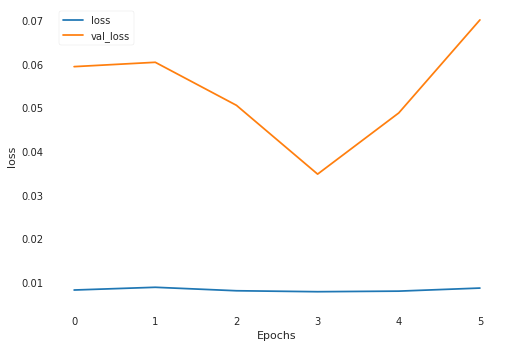

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0081 - val_loss: 0.0402
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0102 - val_loss: 0.0132
Epoch 3/10
880/880 [==============================] - 1s 2ms/sample - loss: 0.0083 - val_loss: 0.0151
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0079 - val_loss: 0.0111
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0077 - val_loss: 0.0090
Epoch 6/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0078 - val_loss: 0.0093
Epoch 7/10
880/880 [==============================] - 1s 2ms/sample - loss: 0.0082 - val_loss: 0.0091
Epoch 00007: early stopping
loss cuts = tf.Tensor([0.07843955], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.86715037, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.07314847], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(1.0

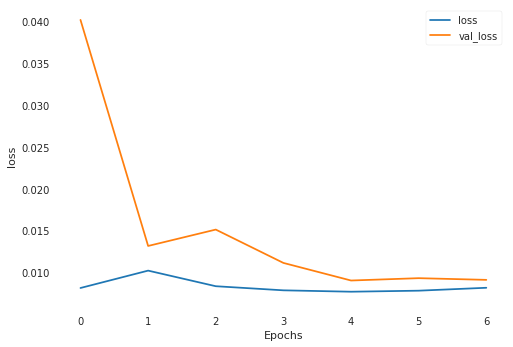

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0076 - val_loss: 0.0301
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0074 - val_loss: 0.0303
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0149 - val_loss: 0.0393
Epoch 00003: early stopping
loss cuts = tf.Tensor([0.04151288], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.13670944, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.04339164], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.11033505, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.04585653], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.08001513, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.04772003], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.06031909, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.04852971], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.05262703, shape=(), dtype=float32)
lo

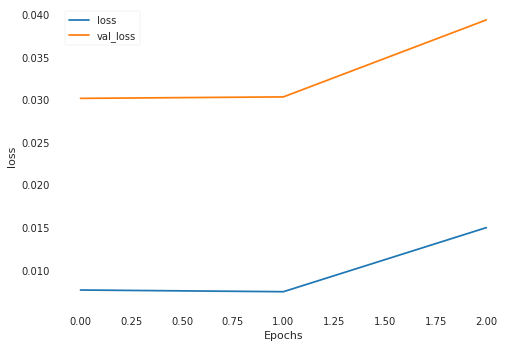

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0093 - val_loss: 0.3005
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0077 - val_loss: 0.3075
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0078 - val_loss: 0.2909
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0072 - val_loss: 0.2877
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0076 - val_loss: 0.2893
Epoch 6/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0076 - val_loss: 0.2946
Epoch 00006: early stopping
loss cuts = tf.Tensor([0.0545917], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(48.09689, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.07363765], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(42.958496, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.0766665], shape=(1,), dtype=float32)
model2 los

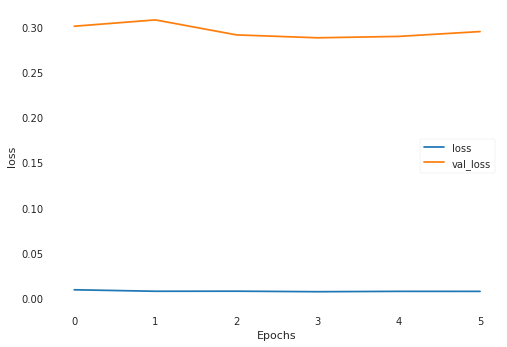

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0080 - val_loss: 0.2775
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0081 - val_loss: 0.2264
Epoch 3/10
880/880 [==============================] - 1s 2ms/sample - loss: 0.0081 - val_loss: 0.2263
Epoch 4/10
880/880 [==============================] - 1s 2ms/sample - loss: 0.0075 - val_loss: 0.2149
Epoch 5/10
880/880 [==============================] - 1s 2ms/sample - loss: 0.0076 - val_loss: 0.1992
Epoch 6/10
880/880 [==============================] - 1s 2ms/sample - loss: 0.0072 - val_loss: 0.1566
Epoch 7/10
880/880 [==============================] - 1s 2ms/sample - loss: 0.0078 - val_loss: 0.1339
Epoch 8/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0075 - val_loss: 0.1258
Epoch 9/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0079 - val_loss: 0.1253
Epoch 10/10
880/880 [=================

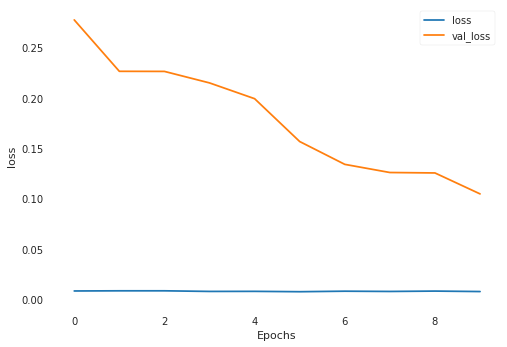

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0079 - val_loss: 0.2278
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0076 - val_loss: 0.2375
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0075 - val_loss: 0.1877
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0087 - val_loss: 0.2035
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0385 - val_loss: 0.8670
Epoch 00005: early stopping
loss cuts = tf.Tensor([0.09347846], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(14.198706, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.09452765], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(14.041008, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.08939224], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(14.821279, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.09024698], shape=(1,), d

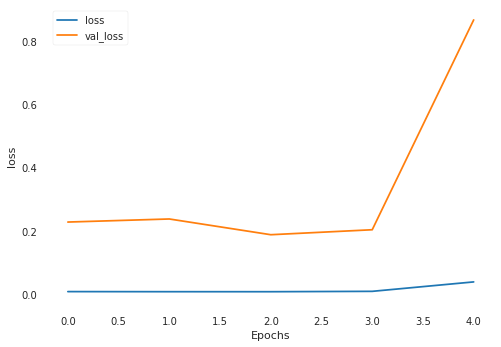

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.1544 - val_loss: 0.7835
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0449 - val_loss: 0.5872
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0291 - val_loss: 0.5441
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0236 - val_loss: 0.4159
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0182 - val_loss: 0.3489
Epoch 6/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0161 - val_loss: 0.3454
Epoch 7/10
880/880 [==============================] - 1s 2ms/sample - loss: 0.0145 - val_loss: 0.3283
Epoch 8/10
880/880 [==============================] - 1s 2ms/sample - loss: 0.0135 - val_loss: 0.3233
Epoch 9/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0124 - val_loss: 0.3482
Epoch 10/10
880/880 [=================

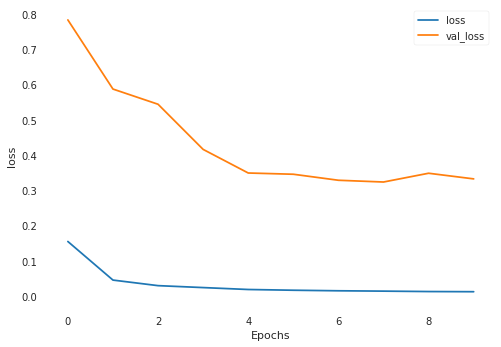

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0121 - val_loss: 0.2236
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0115 - val_loss: 0.1965
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0107 - val_loss: 0.1350
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0105 - val_loss: 0.1306
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0101 - val_loss: 0.1029
Epoch 6/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0095 - val_loss: 0.0875
Epoch 7/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0093 - val_loss: 0.1014
Epoch 8/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0099 - val_loss: 0.1415
Epoch 00008: early stopping
loss cuts = tf.Tensor([0.08561905], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.15391548, shape=(), dty

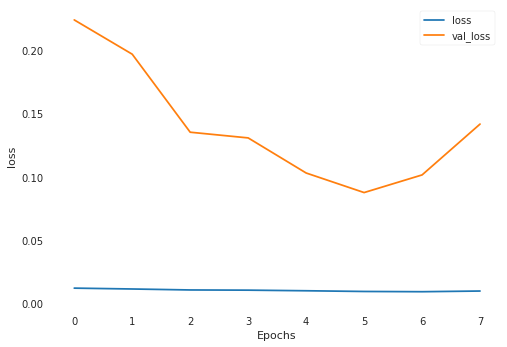

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0815 - val_loss: 2.1161
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.2846 - val_loss: 0.7937
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0833 - val_loss: 0.3160
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0539 - val_loss: 0.1963
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0440 - val_loss: 0.1761
Epoch 6/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0387 - val_loss: 0.2173
Epoch 7/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0351 - val_loss: 0.1610
Epoch 8/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0319 - val_loss: 0.1683
Epoch 9/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0303 - val_loss: 0.1762
Epoch 00009: early stopping
loss cuts 

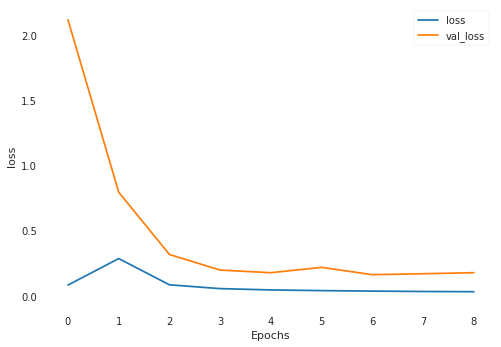

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0287 - val_loss: 0.2112
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0267 - val_loss: 0.1925
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0255 - val_loss: 0.1529
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0239 - val_loss: 0.1530
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0233 - val_loss: 0.1493
Epoch 6/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0227 - val_loss: 0.1532
Epoch 7/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0214 - val_loss: 0.1425
Epoch 8/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0206 - val_loss: 0.0743
Epoch 9/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0200 - val_loss: 0.1247
Epoch 10/10
880/880 [=================

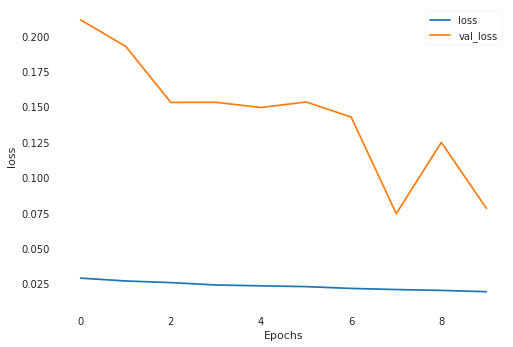

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0192 - val_loss: 0.2738
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0191 - val_loss: 0.2321
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0178 - val_loss: 0.2026
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0178 - val_loss: 0.2384
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0167 - val_loss: 0.2157
Epoch 00005: early stopping
loss cuts = tf.Tensor([0.10579134], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.69584495, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.1182046], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.34328812, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.13970971], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.024275456, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.1505956], shape=(1,),

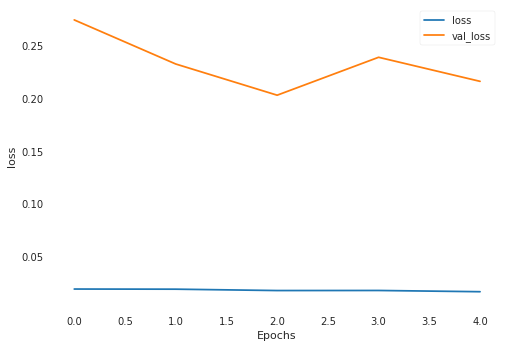

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0185 - val_loss: 0.2994
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0172 - val_loss: 0.2381
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0158 - val_loss: 0.2238
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0154 - val_loss: 0.1836
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0153 - val_loss: 0.1768
Epoch 6/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0147 - val_loss: 0.1879
Epoch 7/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0149 - val_loss: 0.1610
Epoch 8/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0146 - val_loss: 0.1720
Epoch 9/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0145 - val_loss: 0.1440
Epoch 10/10
880/880 [=================

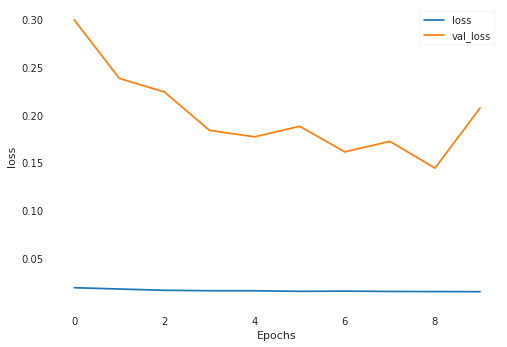

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0145 - val_loss: 1.6581
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0175 - val_loss: 1.3052
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0660 - val_loss: 1.7560
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0308 - val_loss: 1.5340
Epoch 00004: early stopping
loss cuts = tf.Tensor([0.11453738], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(116.055, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.12394744], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(112.035484, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.13298027], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(108.24372, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.13669574], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(106.703026, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.135

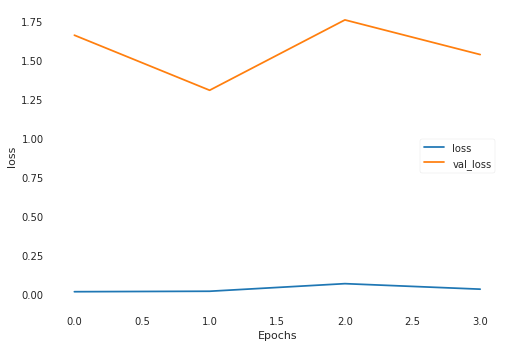

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0192 - val_loss: 1.3886
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0166 - val_loss: 1.1874
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0160 - val_loss: 1.2576
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0148 - val_loss: 1.3859
Epoch 00004: early stopping
loss cuts = tf.Tensor([0.15372391], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(16.609879, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.1440861], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(18.218199, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.13862832], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(19.161926, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.12072335], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(22.42527, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.14188

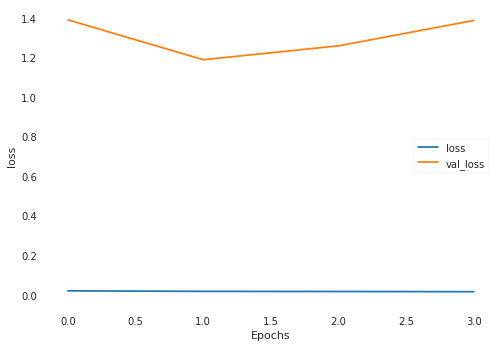

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0246 - val_loss: 1.9514
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0159 - val_loss: 1.5930
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0146 - val_loss: 1.7314
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0141 - val_loss: 1.4451
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0130 - val_loss: 1.4440
Epoch 6/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0132 - val_loss: 1.3400
Epoch 7/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0126 - val_loss: 1.3241
Epoch 8/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0122 - val_loss: 1.3621
Epoch 9/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0128 - val_loss: 1.4276
Epoch 00009: early stopping
loss cuts 

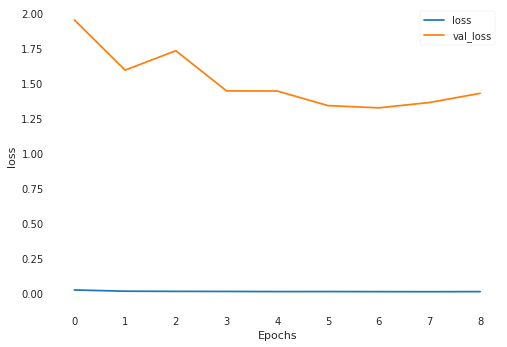

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0204 - val_loss: 1.0810
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0161 - val_loss: 1.0911
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0169 - val_loss: 0.7839
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0155 - val_loss: 1.0769
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0120 - val_loss: 0.9793
Epoch 00005: early stopping
loss cuts = tf.Tensor([0.11990638], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(42.9382, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.12133387], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(42.56486, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.11188656], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(45.065998, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.10200135], shape=(1,), dtyp

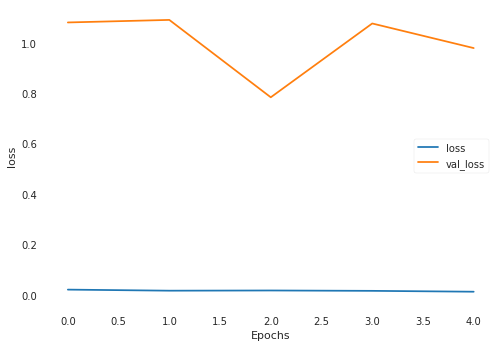

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0234 - val_loss: 0.5908
Epoch 2/10
880/880 [==============================] - 1s 2ms/sample - loss: 0.0206 - val_loss: 0.2841
Epoch 3/10
880/880 [==============================] - 1s 2ms/sample - loss: 0.0119 - val_loss: 0.1948
Epoch 4/10
880/880 [==============================] - 1s 2ms/sample - loss: 0.0112 - val_loss: 0.1095
Epoch 5/10
880/880 [==============================] - 1s 2ms/sample - loss: 0.0110 - val_loss: 0.0847
Epoch 6/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0113 - val_loss: 0.1289
Epoch 7/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0106 - val_loss: 0.1077
Epoch 00007: early stopping
loss cuts = tf.Tensor([0.09631939], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(1.4972271, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.09841009], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(1.39

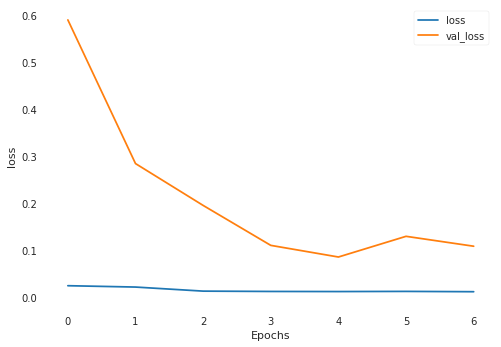

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0110 - val_loss: 0.0933
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0106 - val_loss: 0.1361
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0109 - val_loss: 0.1294
Epoch 00003: early stopping
loss cuts = tf.Tensor([0.2988752], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(54.3537, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.29264742], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(56.20579, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.29135478], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(56.594097, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.29114997], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(56.655743, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.28663766], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(58.022453, shape=(), dtype=float32)
loss cuts =

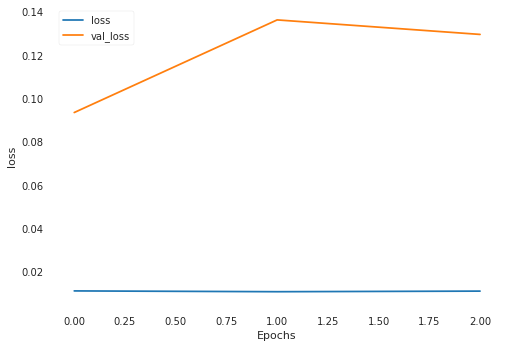

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0109 - val_loss: 0.3706
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0139 - val_loss: 0.6626
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0134 - val_loss: 0.0734
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0106 - val_loss: 0.0755
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0110 - val_loss: 0.0450
Epoch 6/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0102 - val_loss: 0.0546
Epoch 7/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0105 - val_loss: 0.0658
Epoch 00007: early stopping
loss cuts = tf.Tensor([0.1746507], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(20.766125, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.27468732], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(6.534

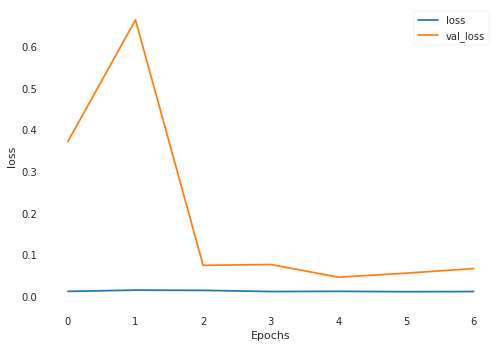

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0104 - val_loss: 0.0918
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0103 - val_loss: 0.0941
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0101 - val_loss: 0.0839
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0102 - val_loss: 0.0944
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0102 - val_loss: 0.0775
Epoch 6/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0100 - val_loss: 0.0908
Epoch 7/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0100 - val_loss: 0.0997
Epoch 00007: early stopping
loss cuts = tf.Tensor([0.19103935], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(4.7123156, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.1856978], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(4.259

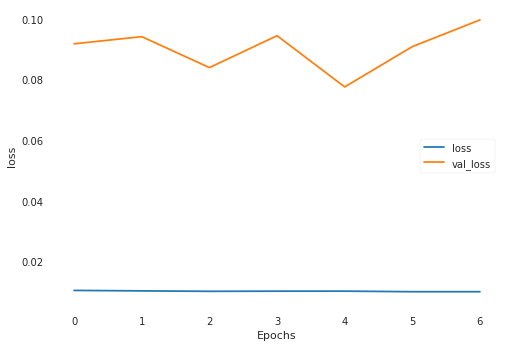

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0099 - val_loss: 0.2657
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0104 - val_loss: 0.1935
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0102 - val_loss: 0.1651
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0101 - val_loss: 0.1537
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0103 - val_loss: 0.1585
Epoch 6/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0100 - val_loss: 0.1822
Epoch 00006: early stopping
loss cuts = tf.Tensor([0.08602623], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(1.0598197, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.07620335], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(1.5029119, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.07925054], shape=(1,), dtype=float32)
model2 

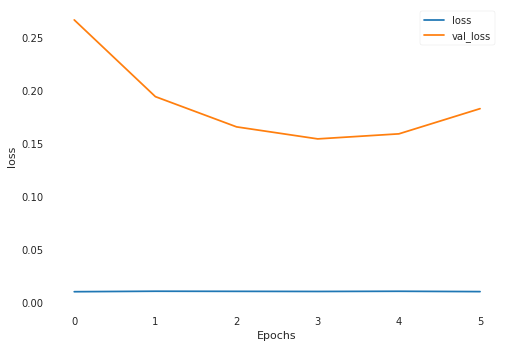

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0106 - val_loss: 0.3376
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.1714 - val_loss: 3.0602
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0683 - val_loss: 3.4022
Epoch 00003: early stopping
loss cuts = tf.Tensor([0.08665497], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(8.014825, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.10058551], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(6.514929, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.10966051], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(5.621336, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.09554917], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(7.0392714, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.10487778], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(6.0840683, shape=(), dtype=float32)
loss cuts 

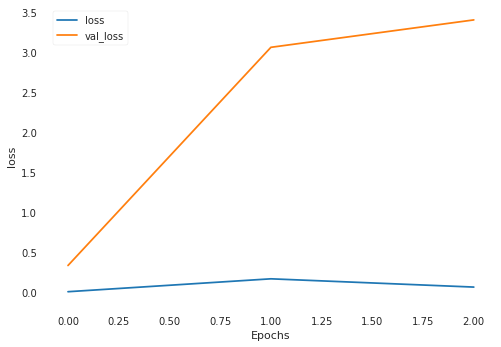

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0474 - val_loss: 0.1876
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0207 - val_loss: 0.1746
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0170 - val_loss: 0.1556
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0142 - val_loss: 0.1684
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0141 - val_loss: 0.1438
Epoch 6/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0119 - val_loss: 0.1173
Epoch 7/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0121 - val_loss: 0.2037
Epoch 8/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0147 - val_loss: 0.1371
Epoch 00008: early stopping
loss cuts = tf.Tensor([0.1110426], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(4.932184, shape=(), dtype=

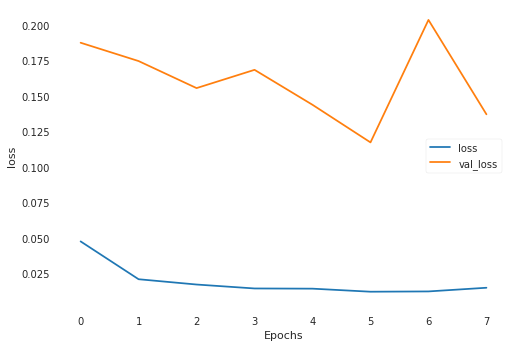

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0115 - val_loss: 0.3752
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0380 - val_loss: 0.5277
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0219 - val_loss: 0.3570
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0133 - val_loss: 0.3602
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0113 - val_loss: 0.3432
Epoch 6/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0105 - val_loss: 0.3343
Epoch 7/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0099 - val_loss: 0.3189
Epoch 8/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0096 - val_loss: 0.3271
Epoch 9/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0097 - val_loss: 0.3288
Epoch 00009: early stopping
loss cuts 

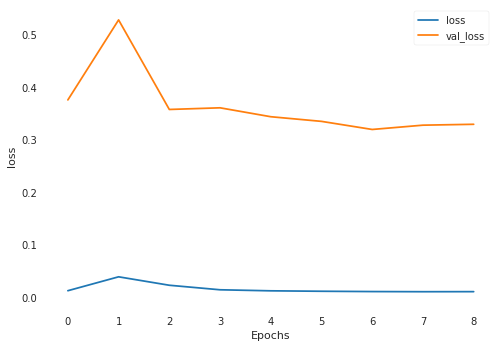

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0099 - val_loss: 0.2257
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0092 - val_loss: 0.2245
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0094 - val_loss: 0.1526
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0089 - val_loss: 0.1886
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0092 - val_loss: 0.1810
Epoch 00005: early stopping
loss cuts = tf.Tensor([0.18050644], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.1375496, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.19213837], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.3642308, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.19181073], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.35636416, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.18953681], shape=(1,), 

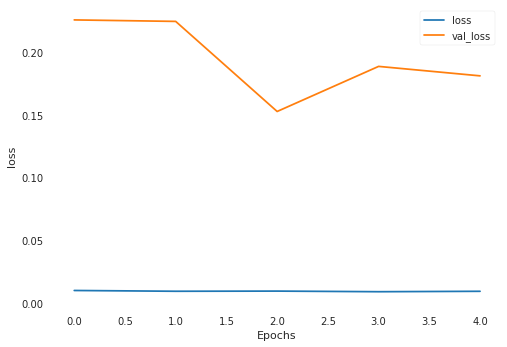

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0106 - val_loss: 0.0998
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0099 - val_loss: 0.0857
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0335 - val_loss: 2.0448
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.1080 - val_loss: 0.4353
Epoch 00004: early stopping
loss cuts = tf.Tensor([0.14108723], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.0007983577, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.16276148], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.164211, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.20537795], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(1.5814553, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.21750231], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(2.2501388, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.2

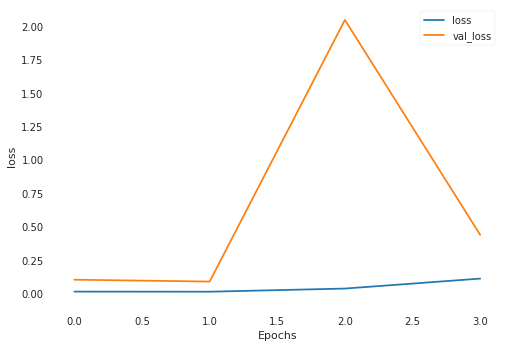

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0276 - val_loss: 0.1271
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0135 - val_loss: 0.1120
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0110 - val_loss: 0.1047
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0100 - val_loss: 0.1049
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0093 - val_loss: 0.0925
Epoch 6/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0091 - val_loss: 0.0995
Epoch 7/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0088 - val_loss: 0.0917
Epoch 8/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0085 - val_loss: 0.0973
Epoch 9/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0084 - val_loss: 0.1024
Epoch 00009: early stopping
loss cuts 

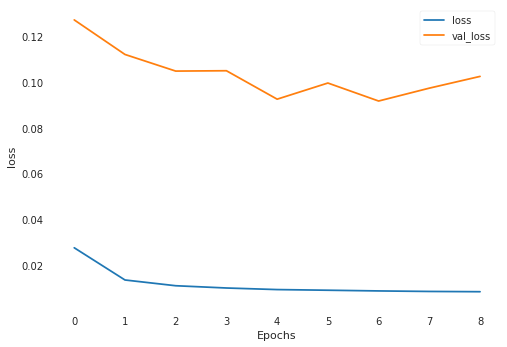

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0086 - val_loss: 0.1716
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0085 - val_loss: 0.1320
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0083 - val_loss: 0.1394
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0085 - val_loss: 0.1265
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0084 - val_loss: 0.1253
Epoch 6/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0081 - val_loss: 0.1114
Epoch 7/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0081 - val_loss: 0.1147
Epoch 8/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0081 - val_loss: 0.1203
Epoch 00008: early stopping
loss cuts = tf.Tensor([0.13562028], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(1.647512, shape=(), dtype

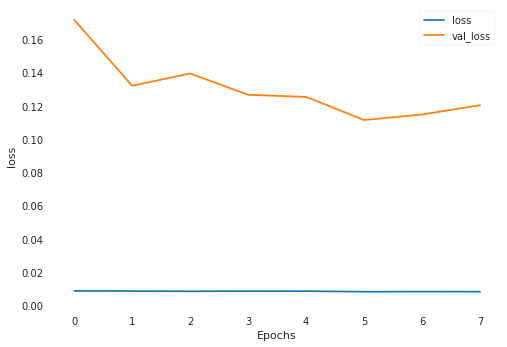

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0083 - val_loss: 0.0557
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0085 - val_loss: 0.0420
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0082 - val_loss: 0.0370
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0079 - val_loss: 0.0381
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0082 - val_loss: 0.0332
Epoch 6/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0079 - val_loss: 0.0422
Epoch 7/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0084 - val_loss: 0.0392
Epoch 00007: early stopping
loss cuts = tf.Tensor([0.15013874], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(5.302771, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.14835118], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(5.139

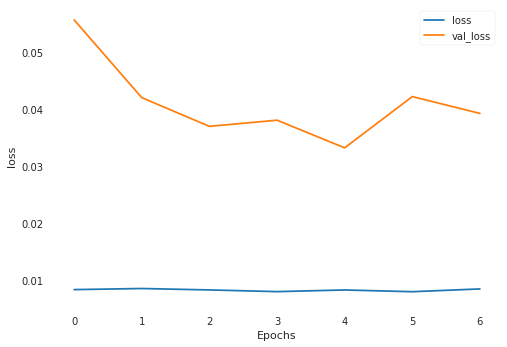

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0089 - val_loss: 0.1017
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0087 - val_loss: 0.1067
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0085 - val_loss: 0.1373
Epoch 00003: early stopping
loss cuts = tf.Tensor([0.13885263], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.38666454, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.16255213], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.021854699, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.18354344], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.07398015, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.19454917], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.24216992, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.19854014], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.3271003, shape=(), dtype=float32)
lo

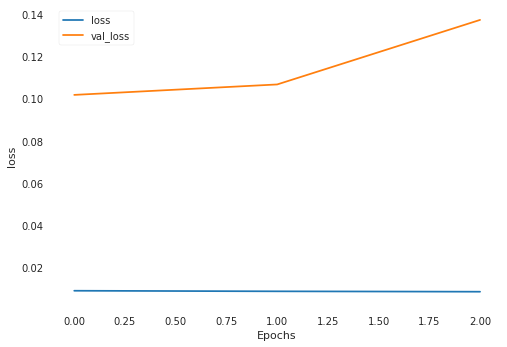

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0090 - val_loss: 0.0316
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0087 - val_loss: 0.0302
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0083 - val_loss: 0.0268
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0087 - val_loss: 0.0265
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0083 - val_loss: 0.0328
Epoch 6/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0086 - val_loss: 0.0310
Epoch 00006: early stopping
loss cuts = tf.Tensor([0.06267313], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.9524949, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.06900322], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(1.2156395, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.08172532], shape=(1,), dtype=float32)
model2 

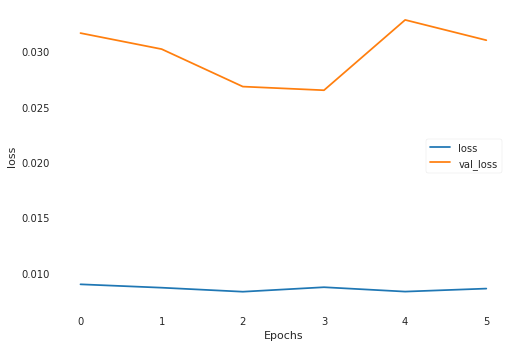

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0086 - val_loss: 0.1751
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0081 - val_loss: 0.1541
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0091 - val_loss: 0.1644
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0085 - val_loss: 0.1716
Epoch 00004: early stopping
loss cuts = tf.Tensor([0.0885309], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(13.082714, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.08594449], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(13.459592, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.07394645], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(15.277876, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.07974742], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(14.384369, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.0781

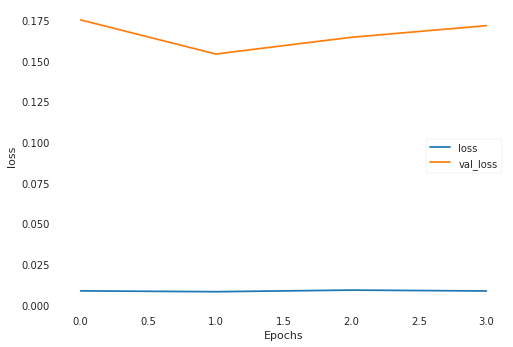

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0088 - val_loss: 0.0395
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0088 - val_loss: 0.0272
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0085 - val_loss: 0.0199
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0081 - val_loss: 0.0202
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0087 - val_loss: 0.0208
Epoch 00005: early stopping
loss cuts = tf.Tensor([0.13429451], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(2.5150476, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.1236321], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(1.8841459, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.10288118], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.917043, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.10163433], shape=(1,), dty

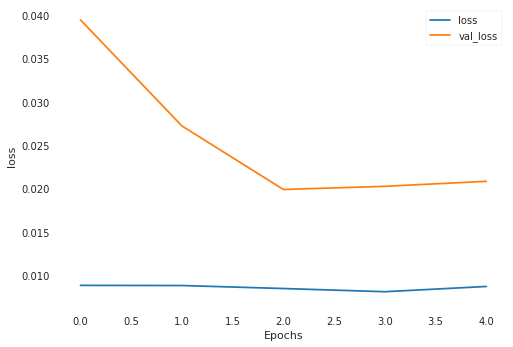

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0084 - val_loss: 0.0898
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0085 - val_loss: 0.0808
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0092 - val_loss: 0.0852
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0109 - val_loss: 0.0763
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0083 - val_loss: 0.0598
Epoch 6/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0080 - val_loss: 0.0738
Epoch 7/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0081 - val_loss: 0.0659
Epoch 00007: early stopping
loss cuts = tf.Tensor([0.09673981], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(9.9778204e-05, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.09818275], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(

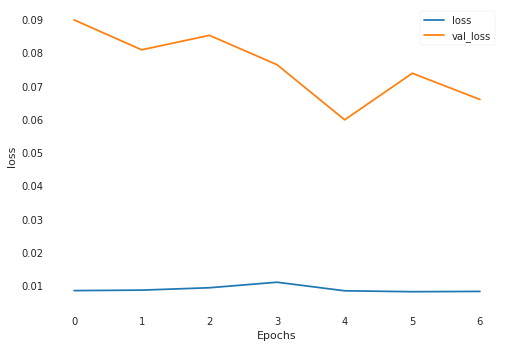

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0086 - val_loss: 0.1159
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0084 - val_loss: 0.1138
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0084 - val_loss: 0.0957
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0080 - val_loss: 0.1095
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0086 - val_loss: 0.1108
Epoch 00005: early stopping
loss cuts = tf.Tensor([0.14444429], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(1.6004207, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.14812353], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(1.7920164, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.14532486], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(1.6452901, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.15066516], shape=(1,), d

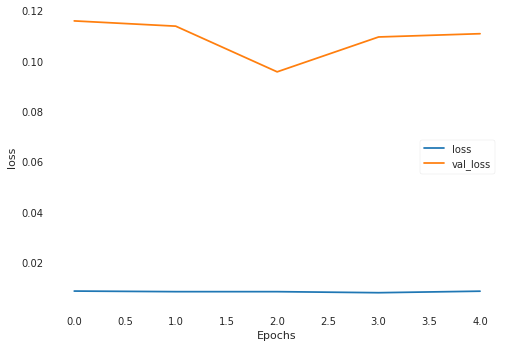

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0088 - val_loss: 0.1183
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0085 - val_loss: 0.0903
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0082 - val_loss: 0.0979
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0084 - val_loss: 0.1121
Epoch 00004: early stopping
loss cuts = tf.Tensor([0.02826186], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(3.3435066, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02491112], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(3.5930731, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02767897], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(3.3862748, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.02782704], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(3.3753846, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.024

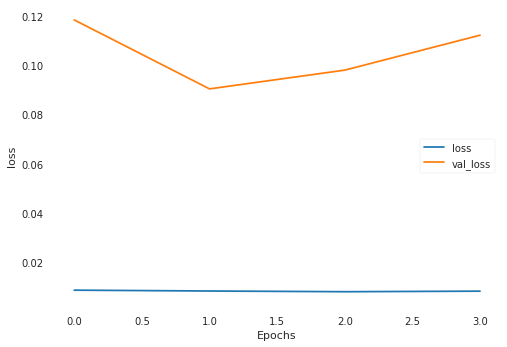

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0082 - val_loss: 0.1983
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0083 - val_loss: 0.1700
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0082 - val_loss: 0.1433
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0085 - val_loss: 0.1903
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0084 - val_loss: 0.2462
Epoch 00005: early stopping
loss cuts = tf.Tensor([0.0393345], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(7.9262295, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.04217879], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(7.609157, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03950696], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(7.90682, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03718209], shape=(1,), dtype

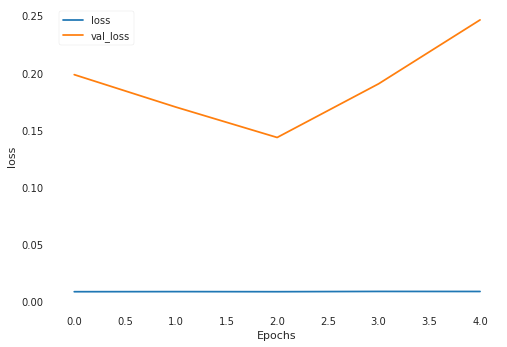

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0085 - val_loss: 0.0867
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0094 - val_loss: 0.0555
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0082 - val_loss: 0.0485
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0074 - val_loss: 0.0569
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0079 - val_loss: 0.0450
Epoch 6/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0076 - val_loss: 0.0395
Epoch 7/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0077 - val_loss: 0.0443
Epoch 8/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0086 - val_loss: 0.0512
Epoch 00008: early stopping
loss cuts = tf.Tensor([0.07276605], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.81960624, shape=(), dty

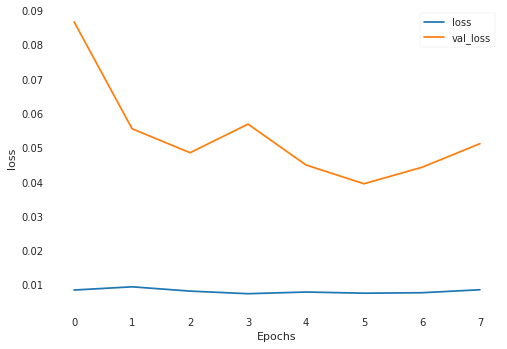

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0081 - val_loss: 0.0168
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0077 - val_loss: 0.0232
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0087 - val_loss: 0.0126
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0078 - val_loss: 0.0149
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0075 - val_loss: 0.0097
Epoch 6/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0085 - val_loss: 0.0245
Epoch 7/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0085 - val_loss: 0.0173
Epoch 00007: early stopping
loss cuts = tf.Tensor([0.07542153], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.41161126, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.07171136], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.5

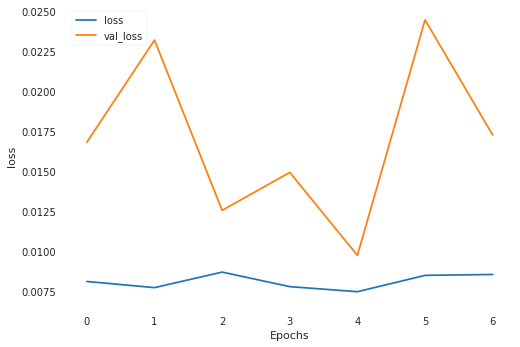

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0079 - val_loss: 0.0191
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0076 - val_loss: 0.0158
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0073 - val_loss: 0.0088
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0078 - val_loss: 0.0200
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0075 - val_loss: 0.0048
Epoch 6/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0079 - val_loss: 0.0166
Epoch 7/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0074 - val_loss: 0.0187
Epoch 00007: early stopping
loss cuts = tf.Tensor([0.05830548], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.09992524, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.04575356], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.0

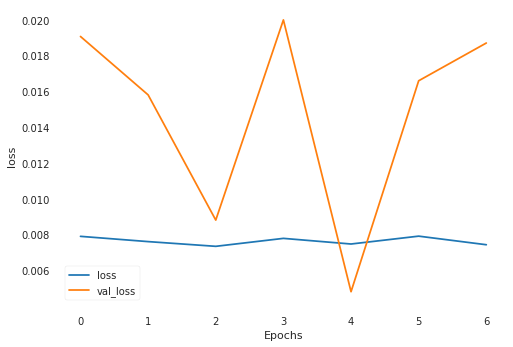

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0077 - val_loss: 0.0796
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0079 - val_loss: 0.0969
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0082 - val_loss: 0.0916
Epoch 00003: early stopping
loss cuts = tf.Tensor([0.0382513], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.69718176, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.0354177], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.79503256, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03270896], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.894577, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03386001], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.8515595, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03342319], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.8677597, shape=(), dtype=float32)
loss cut

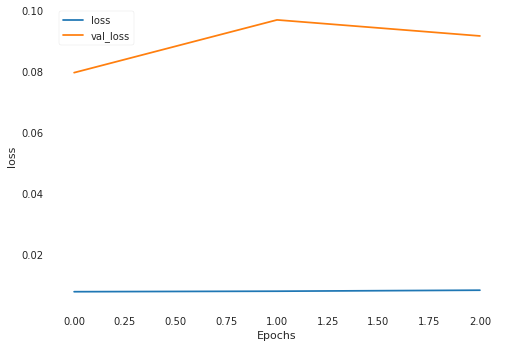

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0084 - val_loss: 0.1401
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0087 - val_loss: 0.1274
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0076 - val_loss: 0.1100
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0078 - val_loss: 0.0946
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0070 - val_loss: 0.0991
Epoch 6/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0079 - val_loss: 0.0932
Epoch 7/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0086 - val_loss: 0.0495
Epoch 8/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0079 - val_loss: 0.1097
Epoch 9/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0074 - val_loss: 0.1018
Epoch 00009: early stopping
loss cuts 

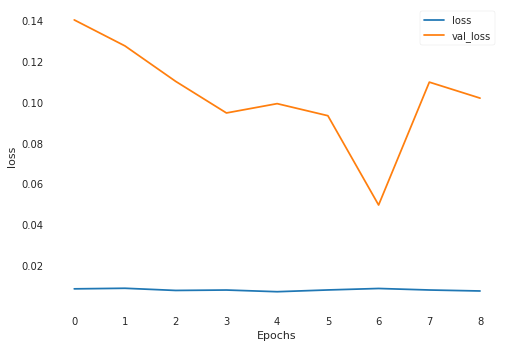

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0078 - val_loss: 0.0612
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0079 - val_loss: 0.0189
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0072 - val_loss: 0.0541
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0071 - val_loss: 0.0468
Epoch 00004: early stopping
loss cuts = tf.Tensor([0.05469428], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(1.9771578, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.05165941], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(2.1515367, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.04378816], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(2.6381452, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.04325616], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(2.672822, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.0469

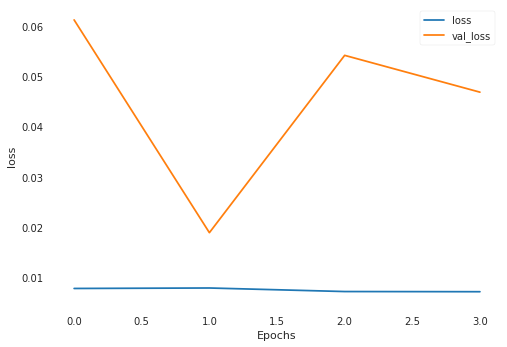

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0075 - val_loss: 0.0588
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0074 - val_loss: 0.0562
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0077 - val_loss: 0.0535
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0078 - val_loss: 0.0653
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0074 - val_loss: 0.0987
Epoch 00005: early stopping
loss cuts = tf.Tensor([0.04996628], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(1.0189772, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.05187362], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.9434179, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.05091959], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.98084813, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.0499908], shape=(1,), d

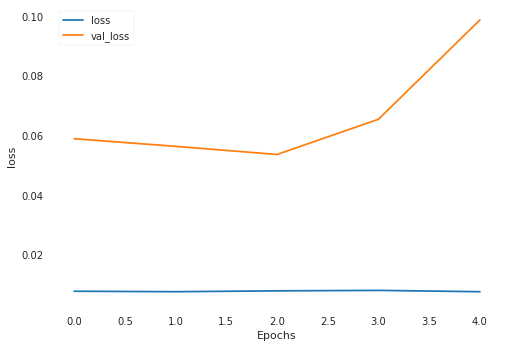

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0075 - val_loss: 0.0413
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0073 - val_loss: 0.0444
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0074 - val_loss: 0.1314
Epoch 00003: early stopping
loss cuts = tf.Tensor([0.0505666], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.23879638, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.04912274], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.2678531, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.04812348], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.28893903, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.04787415], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.29432476, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.03764606], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.5581267, shape=(), dtype=float32)
loss 

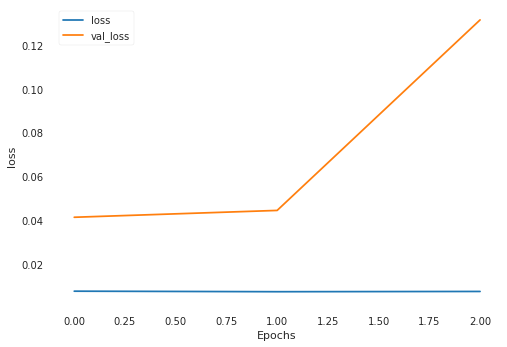

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.9950 - val_loss: 3.1514
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.5501 - val_loss: 0.8060
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.2883 - val_loss: 0.4473
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.2154 - val_loss: 0.2582
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.1630 - val_loss: 0.2448
Epoch 6/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.1390 - val_loss: 0.1813
Epoch 7/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.1180 - val_loss: 0.1724
Epoch 8/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.1240 - val_loss: 4.1834
Epoch 9/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.2135 - val_loss: 0.2463
Epoch 00009: early stopping
loss cuts 

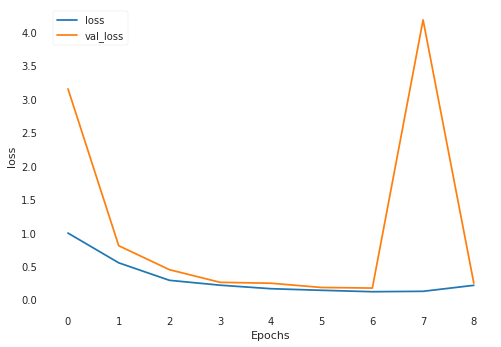

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.1069 - val_loss: 0.3996
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0945 - val_loss: 0.1568
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0836 - val_loss: 0.1729
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0761 - val_loss: 0.0943
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0702 - val_loss: 0.0868
Epoch 6/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0666 - val_loss: 0.0771
Epoch 7/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0625 - val_loss: 0.0761
Epoch 8/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0601 - val_loss: 0.0623
Epoch 9/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0577 - val_loss: 0.0859
Epoch 10/10
880/880 [=================

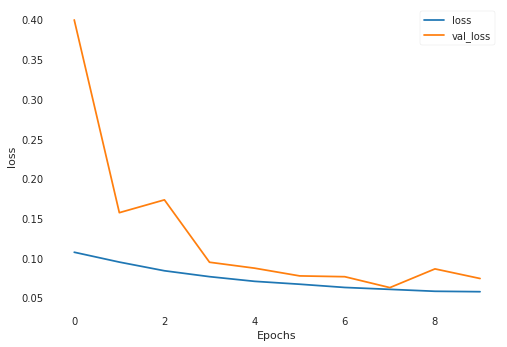

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0534 - val_loss: 0.1441
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0516 - val_loss: 0.1639
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0494 - val_loss: 0.1080
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0482 - val_loss: 0.1116
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0455 - val_loss: 0.1047
Epoch 6/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0437 - val_loss: 0.1138
Epoch 7/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0434 - val_loss: 0.1060
Epoch 00007: early stopping
loss cuts = tf.Tensor([0.07643557], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.5763102, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.07081041], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(0.75

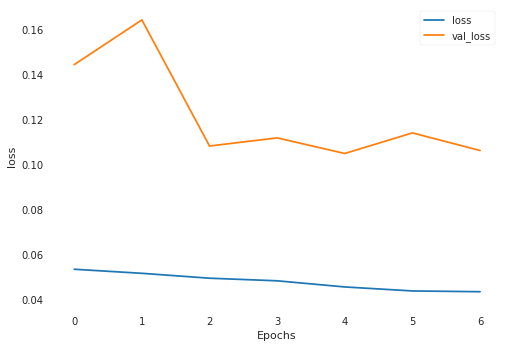

Train on 880 samples, validate on 1 samples
Epoch 1/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0450 - val_loss: 0.1621
Epoch 2/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0446 - val_loss: 0.1565
Epoch 3/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0404 - val_loss: 0.0998
Epoch 4/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0382 - val_loss: 0.1075
Epoch 5/10
880/880 [==============================] - 2s 2ms/sample - loss: 0.0461 - val_loss: 0.1307
Epoch 00005: early stopping
loss cuts = tf.Tensor([0.06424689], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(3.8614697, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.05799283], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(4.3686996, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.05750736], shape=(1,), dtype=float32)
model2 loss = tf.Tensor(4.409382, shape=(), dtype=float32)
loss cuts = tf.Tensor([0.05989708], shape=(1,), dt

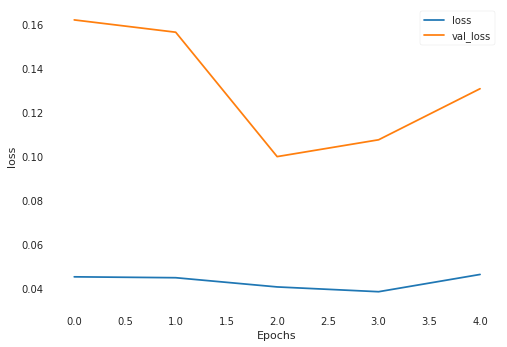

In [15]:
current_train_start = df.loc[prepro.date_to_index(df, train_start), 'date']
current_train_end = df.loc[prepro.date_to_index(df, train_end), 'date']
current_test_start = df.loc[prepro.date_to_index(df, test_start), 'date']
current_test_end = df.loc[prepro.date_to_index(df, test_start) + trans_day - 1, 'date']


#  각 transfer 구간의 예측값들을 합치기 위하여
test_prediction1 = []
test_prediction2 = []
test_target = []

while True:

    gc.collect()

    train_data, test_data = prepro.get_train_test_data(df, target_column, remove_columns, 
                                                           current_train_start, current_train_end,
                                                           current_test_start, current_test_end,
                                                           future_day, n_timestep, time_interval)


    train_x, train_y = prepro.get_LSTM_dataset(train_data, n_timestep, time_interval, input_size, future_day)
    test_x, test_y = prepro.get_LSTM_dataset(test_data, n_timestep, time_interval, input_size, future_day)
    test_y_target = np.expand_dims(test_y[:, :, 3], axis=2)

    # the firs training dataset
    train_x = train_x[:train_end_back]
    train_y_target = np.expand_dims(train_y[:train_end_back, :, 3], axis=2)


    # model1 training
    early_stopping1 = tf.keras.callbacks.EarlyStopping(patience=2, verbose=1)
    model1.load_weights(checkpoint_path)
    history = model1.fit(train_x, train_y_target, batch_size=batch_size, epochs=10, callbacks=[early_stopping1], validation_data=(test_x, test_y_target))
    model1.save_weights(checkpoint_path)

    # model2 training
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)    
    early_stopping2 = learn.EarlyStopping(patience=2, verbose=1)
    epochs = 100
    iter = epochs
    basic_epochs = tf.cast(epochs / 5, dtype=tf.int32)
    for iteration in range(iter):
        batch_input, batch_output = learn.next_random_interval_batch(train_x, train_y, batch_size, future_day)

        gradients2 = gradient2(model1, model2, batch_input, batch_output)
        optimizer.apply_gradients(zip(gradients2, model2.trainable_variables))
        if iteration % 10 == 0:

            # model2의 input 생성
            preds = tf.cast(tf.math.sign(model1(test_x)), dtype=tf.float64)
            test_x_m2 = tf.concat([test_x, preds], 2)

            # model2의 output 생성
            loss_cuts = tf.reshape(model2(test_x_m2)[:, -1, 0], [-1])
            print('loss cuts =', loss_cuts)       

            # model2의 loss
            loss2 = loss_fn_model2(model1, model2, test_x, test_y)
            print('model2 loss =', loss2)  


        if iteration > iter / 2 and early_stopping2.validate(loss2)==True:
            break    

    if iter > basic_epochs: iter -= basic_epochs
    if iter < basic_epochs: iter = basic_epochs

    print('test dates ' + current_test_start + "~" + current_test_end)

    # prediction1 accuracy
    updown = np.sign(test_y[:, -1, 0]).reshape((-1))
    prediction1 = model1.predict(test_x)[:, -1, 0].reshape(-1)
    temp = tf.math.multiply(updown, prediction1)
    accu = tf.reduce_sum(list(map(lambda x: 1 if x > 0 else 0, temp)))/len(temp)
    print('prediction1 accuracy = ', accu)

    # reinforced prediction2
    preds = tf.cast(tf.math.sign(model1(test_x)), dtype=tf.float64)
    test_x_m2 = tf.concat([test_x, preds], 2)
    prediction2 = tf.reshape(model2(test_x_m2)[:, -1, 0]*10, [-1])    
    print('prediction2 = ', prediction2)

    # loss graph
    plot_graphs(history, 'loss')

    test_prediction1.append(prediction1)
    test_prediction2.append(prediction2)

    # escape from while
    if current_test_end == test_end:
     break

    #train, start dates shift
    current_train_end = df.loc[prepro.date_to_index(df, current_train_end) + trans_day, 'date']
    current_train_start = df.loc[prepro.date_to_index(df, current_train_end) - 1000, 'date']
    current_test_start = df.loc[prepro.date_to_index(df, current_test_start) + trans_day, 'date']
    if prepro.date_to_index(df, test_end) - prepro.date_to_index(df, current_test_start) < trans_day:
        current_test_end = test_end
    else:
        current_test_end = df.loc[prepro.date_to_index(df, current_test_end) + trans_day, 'date']

In [16]:
t1 = np.concatenate(test_prediction1)
t2 = np.concatenate(test_prediction2)

In [17]:
#test_prediction = np.concatenate(test_prediction, axis=0).reshape((-1, n_timestep, 1))
#train_prediction = learn.predict_batch_test(model1, train_x[:batch_size], len(train_x[:batch_size]))

# 원 지수, 날짜는 target conversion이 되기 전 dataframe에서 가져옴
test_dates, test_base_prices, train_dates, train_base_prices = prepro.get_test_dates_prices(dataframe, test_start, test_end,
                                                      train_start, train_end, n_timestep, time_interval, future_day, target_column)

# 전체 test_oouput 생성
_, test_data = prepro.get_train_test_data(df, target_column, remove_columns,
                                                   train_start, train_end,
                                                   test_start, test_end,
                                                   future_day, n_timestep, time_interval)
_, test_y = prepro.get_LSTM_dataset(test_data, n_timestep, time_interval, input_size, future_day)

In [18]:
updown = np.sign(test_y[:, -1, 3]).reshape((-1))
#calculate accuracy
temp = tf.math.multiply(updown, t1.reshape((-1)))
accu = tf.reduce_sum(list(map(lambda x: 1 if x > 0 else 0, temp)))/len(temp)
print('accuracy = ', accu)

accuracy =  tf.Tensor(0.4362017804154303, shape=(), dtype=float64)


In [19]:
updown.shape

(337,)

In [20]:
#train_base_prices = train_base_prices[:batch_size]
#train_prediction = train_prediction[:batch_size]
#train_y = train_y[:batch_size]

In [21]:
result = GenerateResult(t1, t2, test_y[:, -1, 3].reshape(-1), test_dates, n_timestep, future_day, trans_day)

In [22]:
#result.extract_last_output()
result.convert_price(test_base_prices,conversion_type=target_type)

info : loss_cut_kospi200f_loss_cut_120_1_1_0.445
MSE : 3.2764 , Accuracy : 0.445
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: models/loss_cut_kospi200f_loss_cut_120_1_1_0.445/assets


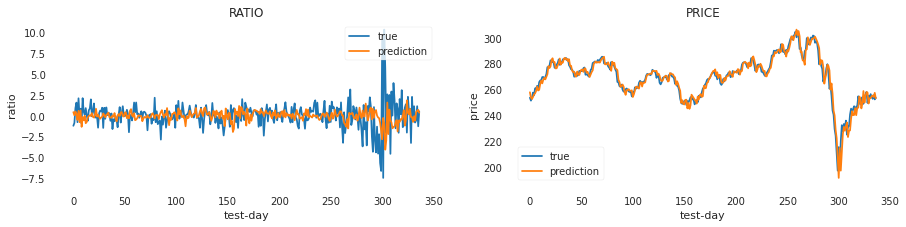

In [23]:
result.evaluation()
result.table()
result.save_result(model_name,item_name,n_unit,target_type,batch_size,n_timestep,time_interval,epochs,str(alpha),comment)
result.save_visualization()
result.save_model(model2)

In [24]:
"""
current_train_start = df.loc[prepro.date_to_index(df, train_start), 'date']
current_train_end = df.loc[prepro.date_to_index(df, train_end), 'date']
current_test_start = df.loc[prepro.date_to_index(df, test_start), 'date']
current_test_end = df.loc[prepro.date_to_index(df, test_start) + trans_day - 1, 'date']


#  각 transfer 구간의 예측값들을 합치기 위하여
test_prediction1 = []
test_prediction2 = []
test_target = []

# early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, verbose=1)
early_stopping = learn.EarlyStopping(patience=2, verbose=1)


gc.collect()

train_data, test_data = prepro.get_train_test_data(df, target_column, remove_columns, 
                                                       current_train_start, current_train_end,
                                                       current_test_start, current_test_end,
                                                       future_day, n_timestep, time_interval)

# input_size, columns reset
input_size = len(df.columns) - len(remove_columns)
input_columns = df.columns.copy()

train_x, train_y = prepro.get_LSTM_dataset(train_data, n_timestep, time_interval, input_size, future_day)
test_x, test_y = prepro.get_LSTM_dataset(test_data, n_timestep, time_interval, input_size, future_day)

#model.compile(optimizer='adam',
#          loss=loss_fn)
#          #callbacks=[cp-callback]
#          #metrics=['accuracy'])

# the firs training dataset
train_x = train_x[:-future_day]
train_y = train_y[:-future_day]    

#global_step = tf.train.get_or_create_global_step()
global_step = tf.Variable(0, trainable=False)
#lr_decay = tf.train.exponential_decay(learning_rate, global_step,
#                                      train_input.shape[0]/batch_size*5, 0.5, staircase=True)
lr_decay = tf.compat.v1.train.exponential_decay(learning_rate,global_step, int(len(train_y)/batch_size), 0.96, staircase=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
#optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

updown = np.sign(test_y[:, -1, 0]).reshape((-1))    
epochs = len(train_y)
for iteration in range(399):
    batch_input, batch_output = learn.next_random_interval_batch(train_x, train_y, batch_size, future_day)

    #noise = 2*np.random.randn(batch_size,n_timestep,1)
    #batch_output = batch_output+noise
    #batch_input = encoder(train_input[idx])
    gradients1 = gradient1(model1, model2, batch_input, batch_output)
    optimizer.apply_gradients(zip(gradients1, model1.trainable_variables))
    
    targets = tf.reshape(train_y[:, -1, 0], [-1])
    rates = targets / 100
    preds = tf.reshape(model1(train_x, training=False)[:, -1, 0], [-1])
    
    n = len(targets)    
    returns = [1.0]
    losses = []
    for i in range(n - 1):
       
        # average_return, std of returns, remaining days, preds[0] 
        state = []
        
        random_rates = []
        for k in range(i+1):
            random_rates.append(rates[k])
        # 실재 수익률을 기반으로 random 수익률 생성, 예측에 의한 porfits 생성 
        for k in range(i+1, n):
            random_rates.append(tf.random.normal((), mean=targets[k] / 100, stddev=0.1, dtype=tf.float64))
        profits = tf.convert_to_tensor(random_rates, dtype=tf.float64)*tf.cast(preds, dtype=tf.float64) + 1
        
        # 현재까지의 예측에 의한 수익률 기하평균 구하기
        returns_past = []
        for k in range(i+1):
            returns_past.append(profits[k])
        avg_return = tf.cast(tf.math.reduce_prod(returns_past)**(1/(i+1)), dtype=tf.float64)
        
        state.append(avg_return)
        state.append(tf.math.reduce_std(returns))
        state.append((n - i) / n)
        state.append(preds[i])
        state = np.array(state).reshape((1, 4))
     
        # 목표일까지의 기대 기하 평균 수익률 구하기 
        returns_future = []
        for j in range(i+1, n):
            returns_future.append(profits[j])
        avg_return_future = tf.math.reduce_prod(returns_future)**(1/(n-i-1))

        # 예측 기하 평균 수익률과 기대 기하 평균 수익률의 MSE
        value = tf.cast(model2(state, training=True)[0, 0], dtype=tf.float64)
        losses.append((value - avg_return_future)**2)
        if n == 3: break
    print("losses", losses)
    print("value", value)    
    with tf.GradientTape() as tape:
        gradients2 = tape.gradient(tf.math.reduce_sum(losses), model2.trainable_variables)
    optimizer.apply_gradients(zip(gradients2, model2.trainable_variables))
    

    
    if iteration % 100 == 0:
        #test_MSE = model.evaluate(test_x, test_y)
        prediction = model1.predict(test_x)
        prediction_MSE = sum((updown - np.sign(prediction[:, -1, 0]).reshape(-1))**2)/len(test_y)
        print('prediction_MSE =', prediction_MSE)

    if iteration > epochs / 2 and early_stopping.validate(prediction_MSE)==True:
        break
epochs -= epochs / 5
if epochs <= 0: epochs = 100
"""

'\ncurrent_train_start = df.loc[prepro.date_to_index(df, train_start), \'date\']\ncurrent_train_end = df.loc[prepro.date_to_index(df, train_end), \'date\']\ncurrent_test_start = df.loc[prepro.date_to_index(df, test_start), \'date\']\ncurrent_test_end = df.loc[prepro.date_to_index(df, test_start) + trans_day - 1, \'date\']\n\n\n#  각 transfer 구간의 예측값들을 합치기 위하여\ntest_prediction1 = []\ntest_prediction2 = []\ntest_target = []\n\n# early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, verbose=1)\nearly_stopping = learn.EarlyStopping(patience=2, verbose=1)\n\n\ngc.collect()\n\ntrain_data, test_data = prepro.get_train_test_data(df, target_column, remove_columns, \n                                                       current_train_start, current_train_end,\n                                                       current_test_start, current_test_end,\n                                                       future_day, n_timestep, time_interval)\n\n# input_size, columns reset\ninput_size 